# Run a complete consensus workflow

Based on [this workflow](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/index.html)

![](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/overview-Consensus.png)

The steps are as follows:
 1. Data input and cleaning, including re-formatting the data for consensus analysis: [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-DataInput.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-DataInput.R)
 1. Network construction and consensus module detection
    1. Automatic, one-step network construction and consensus module detection: [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-NetworkConstruction-auto.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-NetworkConstruction-auto.R) **THIS ONE**
    1. Step-by-step network construction and module detection, including scaling of Topological Overlap Matrices: [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-NetworkConstruction-man.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-NetworkConstruction-man.R)
    1. Dealing with large datasets: block-wise network construction and consensus module detection, including comparing the block-wise approach to the standard single-block method: [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-NetworkConstruction-blockwise.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-NetworkConstruction-blockwise.R).
 1. Relating the consensus modules to female set-specific modules (this section requires the results of Section 2.a of the female turorial): [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-RelateToFemMods.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-RelateToFemMods.R)
 1. Relating consensus module to external microarray sample traits and exporting the results of network analysis: [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-RelateModsToTraits.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-RelateModsToTraits.R)
 1. Studying and comparing the relationships among modules and traits between the two data sets, including the visualization of consensus eigengene networks and the results of the differential analysis: [PDF document](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-EigengeneNetworks.pdf), [R script](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/Consensus-EigengeneNetworks.R)

## Perform the cleaning

In [9]:
library(RaceID)
library(WGCNA)

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




In [10]:
sc <- readRDS('~/Downloads/sc_object_RaceID.RDS')
mydata <- sc@expdata

The data contains two sets of **K**ases and **C**ontrols

In [11]:
tab <- as.matrix(mydata)
controls <- grepl("^C8", colnames(tab))
kases <- grepl("^K8*", colnames(tab))

In [12]:
print(paste("Controls=", sum(controls), " Cases=", sum(kases), " (+added) ", 
      (sum(controls) + sum(kases)), " expected=", length(colnames(tab))))

[1] "Controls= 1417  Cases= 2718  (+added)  4135  expected= 4135"


### Building the multiExpr set

In [13]:
# transpose for compatibility
data.controls <- t(tab[,controls])
data.kases <- t(tab[,kases])

In [14]:
nSets = 2
setLabels = c("Cases (K)", "Controls (C)")
shortLabels = c("Cases", "Controls")

multiExpr = vector(mode = "list", length = nSets)
multiExpr[[1]] = list(data = as.data.frame(data.kases))
multiExpr[[2]] = list(data = as.data.frame(data.controls))

names(multiExpr[[1]]$data) = colnames(data.kases)
names(multiExpr[[2]]$data) = colnames(data.controls)

rownames(multiExpr[[1]]$data) = rownames(data.kases)
rownames(multiExpr[[2]]$data) = rownames(data.controls)

In [15]:
# Check that the data has the correct format for many functions operating on multiple sets:
exprSize = checkSets(multiExpr)

In [16]:
exprSize

$nSets
[1] 2

$nGenes
[1] 23774

$nSamples
[1] 2718 1417

$structureOK
[1] TRUE

## Cleaning and Outlier Removal

In [17]:
gsg = goodSamplesGenesMS(multiExpr, verbose = 3);
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 6991 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 6991, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 6991, bad sample counts: 0, 0


[1] FALSE

Nope, we need to prune some samples

In [18]:
if (!gsg$allOK){
    # Print information about the removed genes:
    if (sum(!gsg$goodGenes) > 0){
        printFlush(paste("Removing genes:", 
                         paste(names(multiExpr[[1]]$data)[!gsg$goodGenes],
                               collapse = ", ")));
    }
    for (set in 1:exprSize$nSets){
        if (sum(!gsg$goodSamples[[set]])){
            printFlush(paste("In set", setLabels[set], "removing samples",
                             paste(rownames(multiExpr[[set]]$data)[!gsg$goodSamples[[set]]], 
                                   collapse = ", ")))
        } 
        # Remove the offending genes and samples
        multiExpr[[set]]$data = multiExpr[[set]]$data[gsg$goodSamples[[set]], gsg$goodGenes];
    }
    # Update exprSize
    exprSize = checkSets(multiExpr)
}

Removing genes: Cd209f, Ugt3a1, Usp17lb, V1ra8, Vmn1r10, Vmn1r16, Vmn1r167, Vmn1r168, Vmn1r17, Vmn1r172, Cd300lh, Vmn1r18, Vmn1r184, Vmn1r189, Vmn1r192, Vmn1r193, Vmn1r197, Vmn1r2, Vmn1r25, Vmn1r33, Vmn1r40, Vmn1r42, Vmn1r86, Vmn2r-ps130, Cela3a, Vmn2r108, Vmn2r20, Vmn2r23, Vmn2r58, Ces1b, Vmn2r88, Wfdc6a, Xlr5a, Ces2c, n-R5s166, Ces3a, n-R5s176, n-R5s194, n-R5s10, 1700040F15Rik, Cldn34b1, Cldn34c2, Clec2g, Cml3, Cphx1, Crisp1, Crygd, Cts3, Cyp2a12, Cyp2a4, Cyp2b13, Cyp2c40, Cyp2d10, Cyp4a12a, Cypt14, Cypt2, D13Ertd608e, 1810009J06Rik, D830030K20Rik, DXBay18, Dcpp1, Defa-rs7, Defa2, Defb10, Defb15, Dmrtc1c1, Dsg1b, E330010L02Rik, E330016L19Rik, Ear1, Entpd4, Fbxw25, Fpr-rs6, Fthl17b, Gal3st2, 4921509C19Rik, 4921511M17Rik, 4930442J19Rik, Dppa1, 4930449I24Rik, 4930524N10Rik, 4930558F17Rik, 4933402N22Rik, 4933406F09Rik, 1700003E24Rik, 5430401F13Rik, 5430402E10Rik, 9230110F15Rik, AC099934.1, 1700010D01Rik, AC099934.2, AC124193.1, AC125099.1, AL645522.1, 1700011M02Rik, AV320801, AW822073, A

Check again:

In [19]:
exprSize

$nSets
[1] 2

$nGenes
[1] 16783

$nSamples
[1] 2718 1417

$structureOK
[1] TRUE

In [20]:
gsg = goodSamplesGenesMS(multiExpr, verbose = 3);
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


[1] TRUE

Okay, we can now proceed with the clustering using Euclidean as a distance metric

In [21]:
sampleTrees = list()
for (set in 1:nSets){
    sampleTrees[[set]] = hclust(dist(multiExpr[[set]]$data), method = "average")
}

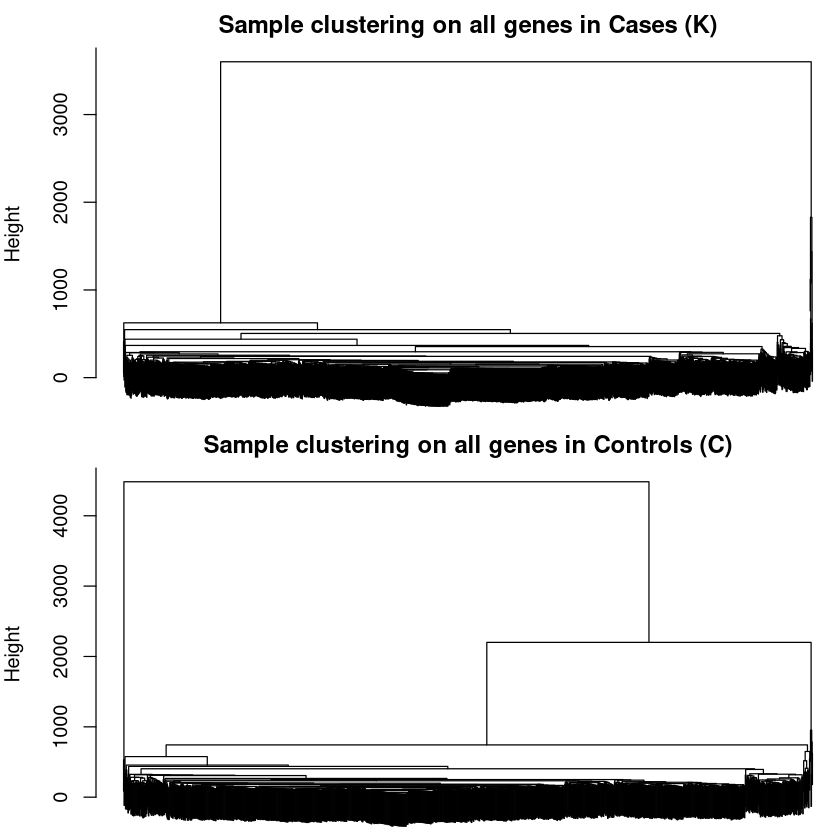

In [22]:
par(mfrow=c(2, 1))
par(mar = c(0, 4, 2, 0))
for (set in 1:nSets){
    plot(sampleTrees[[set]], 
         main = paste("Sample clustering on all genes in", setLabels[set]),
         xlab="", sub="", cex = 1e-20)
}

there appears to be a few small outliers in the cases (far right) which cluster immediately alone, so maybe it makes sense to remove them? We can set a base height cut off at 2000

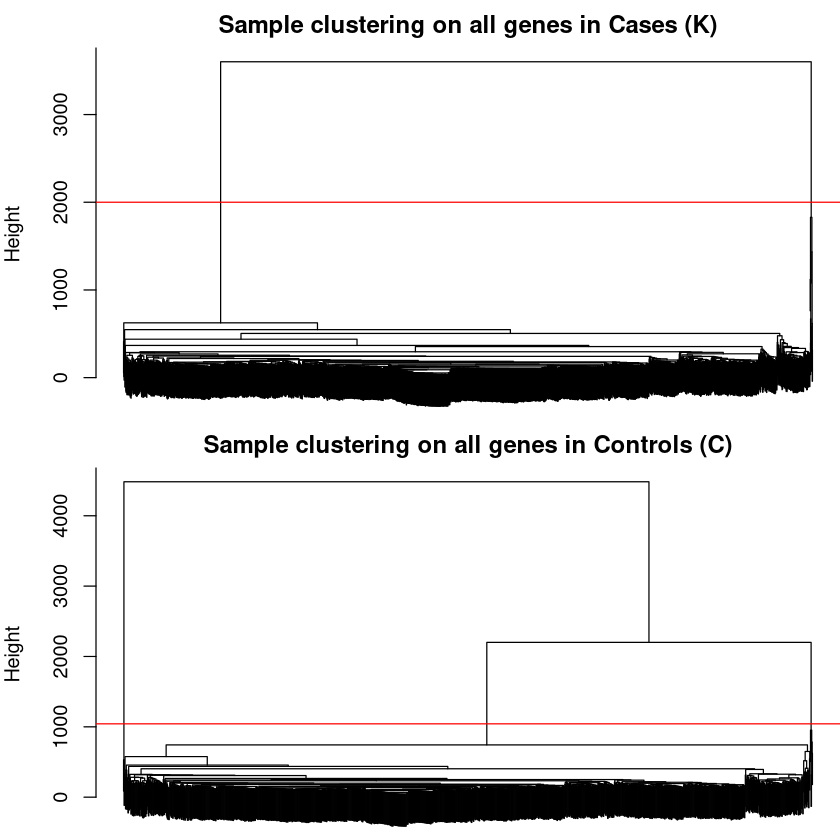

In [23]:
baseHeight = 2000
cutHeights = c(baseHeight, baseHeight * exprSize$nSamples[2]/exprSize$nSamples[1])

par(mfrow=c(2, 1))
par(mar = c(0, 4, 2, 0))
for (set in 1:nSets){
    plot(sampleTrees[[set]], 
         main = paste("Sample clustering on all genes in", setLabels[set]),
         xlab="", sub="", cex = 1e-20)
    abline(h=cutHeights[set], col = "red");
}

and now we trim:

In [24]:
for (set in 1:nSets){
    # Find clusters cut by the line
    labels = cutreeStatic(sampleTrees[[set]], 
                          cutHeight = cutHeights[set])
    # Keep the largest one (labeled by the number 1)
    keep = (labels==1)
    multiExpr[[set]]$data = multiExpr[[set]]$data[keep, ]
}
collectGarbage();# Check the size of the leftover data
exprSize = checkSets(multiExpr)
exprSize

$nSets
[1] 2

$nGenes
[1] 16783

$nSamples
[1] 2708 1409

$structureOK
[1] TRUE

In [25]:
saveRDS(multiExpr, file = "files/7_wgcna2/multiExpr.RDS")
saveRDS(exprSize, file = "files/7_wgcna2/exprSize.RDS")
saveRDS(sampleTrees, file = "files/7_wgcna2/sampleTrees.RDS")


In [28]:
#gc(verbose = getOption("verbose"), reset = FALSE, full = TRUE)

(checkpoint, and a chance to garbage collect)

In [1]:
multiExpr <- readRDS(file = "files/7_wgcna2/multiExpr.RDS")
exprSize <- readRDS(file = "files/7_wgcna2/exprSize.RDS")
sampleTrees <- readRDS(file = "files/7_wgcna2/sampleTrees.RDS")

In [2]:
exprSize

$nSets
[1] 2

$nGenes
[1] 16783

$nSamples
[1] 2708 1409

$structureOK
[1] TRUE

## Perform the Network Construction

In [4]:
library(WGCNA)
enableWGCNAThreads()
nSets = checkSets(multiExpr)$nSets

Allowing parallel execution with up to 3 working processes.


Choosing a soft thresholding power

In [ ]:
# Choose a set of soft-thresholding powers
powers = c(seq(4,10,by=1), seq(12,20, by=2));
# Initialize a list to hold the results of scale-free analysis
powerTables = vector(mode = "list", length = nSets);
# Call the network topology analysis function for each set in turn
for (set in 1:nSets)
    powerTables[[set]] = list(data = pickSoftThreshold(
        multiExpr[[set]]$data, 
        powerVector=powers,
        verbose = 2)[[2]]);

pickSoftThreshold: will use block size 2665.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2665 of 16783


In [ ]:
collectGarbage();
# Plot the results:
colors = c("black", "red")
# Will plot these columns of the returned scale free analysis tables
plotCols = c(2,5,6,7)
colNames = c("Scale Free Topology Model Fit", 
             "Mean connectivity", "Median connectivity","Max connectivity");
# Get the minima and maxima of the plotted points
ylim = matrix(NA, nrow = 2, ncol = 4);


(Ran out of memory and crashed.)

## Run on subset of cells

The above plots were relatively indecipherable given the number of samples, so let's reduce this to a single cluster-by-cluster basis (as talked about it).

In [36]:
library(RaceID)
library(WGCNA)

In [4]:
sc <- readRDS('~/Downloads/sc_object_RaceID.RDS')
str(sc, max.level=2)

Formal class 'SCseq' [package "RaceID"] with 20 slots


Warning message:
“Not a validObject(): no slot of name "noise" for this object of class "SCseq"”


  ..@ expdata   :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ ndata     :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ counts    : Named num [1:3701] 4283 6883 4734 6106 7365 ...
  .. ..- attr(*, "names")= chr [1:3701] "C81711_1" "C81711_4" "C81711_5" "C81711_6" ...
  ..@ genes     : chr [1:7477] "Zfp942" "Cox16" "Cpne1" "Ctnnd1" ...
  ..@ dimRed    : list()
  ..@ distances : num [1:3701, 1:3701] 0 0.249 0.351 0.347 0.66 ...
  .. ..- attr(*, "dimnames")=List of 2
  ..@ imputed   : list()
  ..@ tsne      :'data.frame':	3701 obs. of  2 variables:
  ..@ fr        :'data.frame':	3701 obs. of  2 variables:
  ..@ cluster   :List of 5
  ..@ background:List of 1
  ..@ out       :List of 5
  ..@ cpart     : Named int [1:3701] 1 2 25 4 18 1 3 3 5 2 ...
  .. ..- attr(*, "names")= chr [1:3701] "C81711_1" "C81711_4" "C81711_5" "C81711_6" ...
  ..@ medoids   : chr [1:27] "C81713_76" "K81312_146" "C81714_164" "C81732_159" ...
  ..@ fcol      : chr [1:27] "#0000FFFF"

So only 3701 cells have cluster ids, so these are the cells we will use. Let's subselect the ones from cluster 1.

# Methods

In [101]:
# some globals
nSets = 2
setLabels = c("Cases (K)", "Controls (C)")
shortLabels = c("Cases", "Controls")

In [127]:
pickOutCluster <- function(sc, cln=1){
    cln.names <- names(sc@cpart)[sc@cpart == cln]
    mydata <- sc@expdata[,cln.names]
    tab <- as.matrix(mydata)
    controls <- grepl("^C8", colnames(tab))
    kases <- grepl("^K8*", colnames(tab))
    print(paste("Controls=", sum(controls), " Cases=", sum(kases), " (+added) ", 
          (sum(controls) + sum(kases)), " expected=", length(colnames(tab))))
    ## transpose for compatibility
    data.controls <- t(tab[,controls])
    data.kases <- t(tab[,kases])
    ##
    multiExpr = vector(mode = "list", length = nSets)
    multiExpr[[1]] = list(data = as.data.frame(data.kases))
    multiExpr[[2]] = list(data = as.data.frame(data.controls))
    names(multiExpr[[1]]$data) = colnames(data.kases)
    names(multiExpr[[2]]$data) = colnames(data.controls)
    rownames(multiExpr[[1]]$data) = rownames(data.kases)
    rownames(multiExpr[[2]]$data) = rownames(data.controls)
    ##
    exprSize = checkSets(multiExpr)
    print(paste("[Initial] nSets=", exprSize$nSets, "nGenes=", exprSize$nGenes, 
                "nSamples=", exprSize$nSamples, "structureOK=", exprSize$structureOK))
    return(list(exprSize=exprSize, multiExpr=multiExpr))
}

cleanAndFilter <- function(multiExpr){
    gsg = goodSamplesGenesMS(multiExpr, verbose = 3);
    gsg$allOK
    if (!gsg$allOK){
        # Print information about the removed genes:
        if (sum(!gsg$goodGenes) > 0){
            printFlush(paste("Removing genes:", length(names(multiExpr[[1]]$data)[!gsg$goodGenes])))
        }
        for (set in 1:exprSize$nSets){
            if (sum(!gsg$goodSamples[[set]])){
                printFlush(paste("In set", setLabels[set], "removing samples", 
                                 length(rownames(multiExpr[[set]]$data)[!gsg$goodSamples[[set]]])))
            } 
            # Remove the offending genes and samples
            multiExpr[[set]]$data = multiExpr[[set]]$data[gsg$goodSamples[[set]], gsg$goodGenes];
        }
        # Update exprSize
        exprSize = checkSets(multiExpr)
    }
    # Check again
    print(paste("[Cleaned] nSets=", exprSize$nSets, "nGenes=", exprSize$nGenes, 
                "nSamples=", exprSize$nSamples, "structureOK=", exprSize$structureOK))
    gsg = goodSamplesGenesMS(multiExpr, verbose = 3);
    gsg$allOK
    return(list(exprSize=exprSize, multiExpr=multiExpr))
}

plotDendroesFiltered <- function(multiExpr, cln=1){
    sampleTrees = list()
    for (set in 1:nSets){
        sampleTrees[[set]] = hclust(dist(multiExpr[[set]]$data), method = "average")
    }
    options(repr.plot.width = 11, repr.plot.height = 7, repr.plot.res = 300)
    par(mfrow=c(2, 1), mar = c(0, 4, 2, 0))
    for (set in 1:nSets){
        ngenes <- length(colnames(multiExpr[[set]]$data))
        ncells <- length(rownames(multiExpr[[set]]$data))
        plot(sampleTrees[[set]], 
             main = paste("Sample clustering on" , ngenes, "genes in", 
                          setLabels[set], "(", ncells, "cells ) [ cluster", cln, "]"),
             xlab="", sub="", cex=0.4, cex.lab=0.7, cex.axis=0.7)
    }
    return(sampleTrees)
}

processClust <- function(sc, cln=1){
    # Filter to specific cluster
    message(paste("Cluster", cln))
    tmp <- pickOutCluster(sc, cln)
    exprSize <- tmp$exprSize
    multiExpr <- tmp$multiExpr
    # Filter bad data
    tmp <- cleanAndFilter(multiExpr)
    exprSize <- tmp$exprSize
    multiExpr <- tmp$multiExpr
    # Plot the dendrograms
    sampleTrees <- plotDendroesFiltered(multiExpr, cln)
    tmp <- list(exprSize=exprSize, multiExpr=multiExpr,
                sampleTrees=sampleTrees)
    saveRDS(tmp, file = paste("files/7_wgcna2/cluster", cln, ".RDS", sep=""))
}


# Process all Clusters

Cluster 1



[1] "Controls= 158  Cases= 77  (+added)  235  expected= 235"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 77 structureOK= TRUE" 
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 158 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 11385 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 11385, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 11385, bad sample counts: 0, 0
Removing genes: 11385
[1] "[Cleaned] nSets= 2 nGenes= 12389 nSamples= 77 structureOK= TRUE" 
[2] "[Cleaned] nSets= 2 nGenes= 12389 nSamples= 158 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


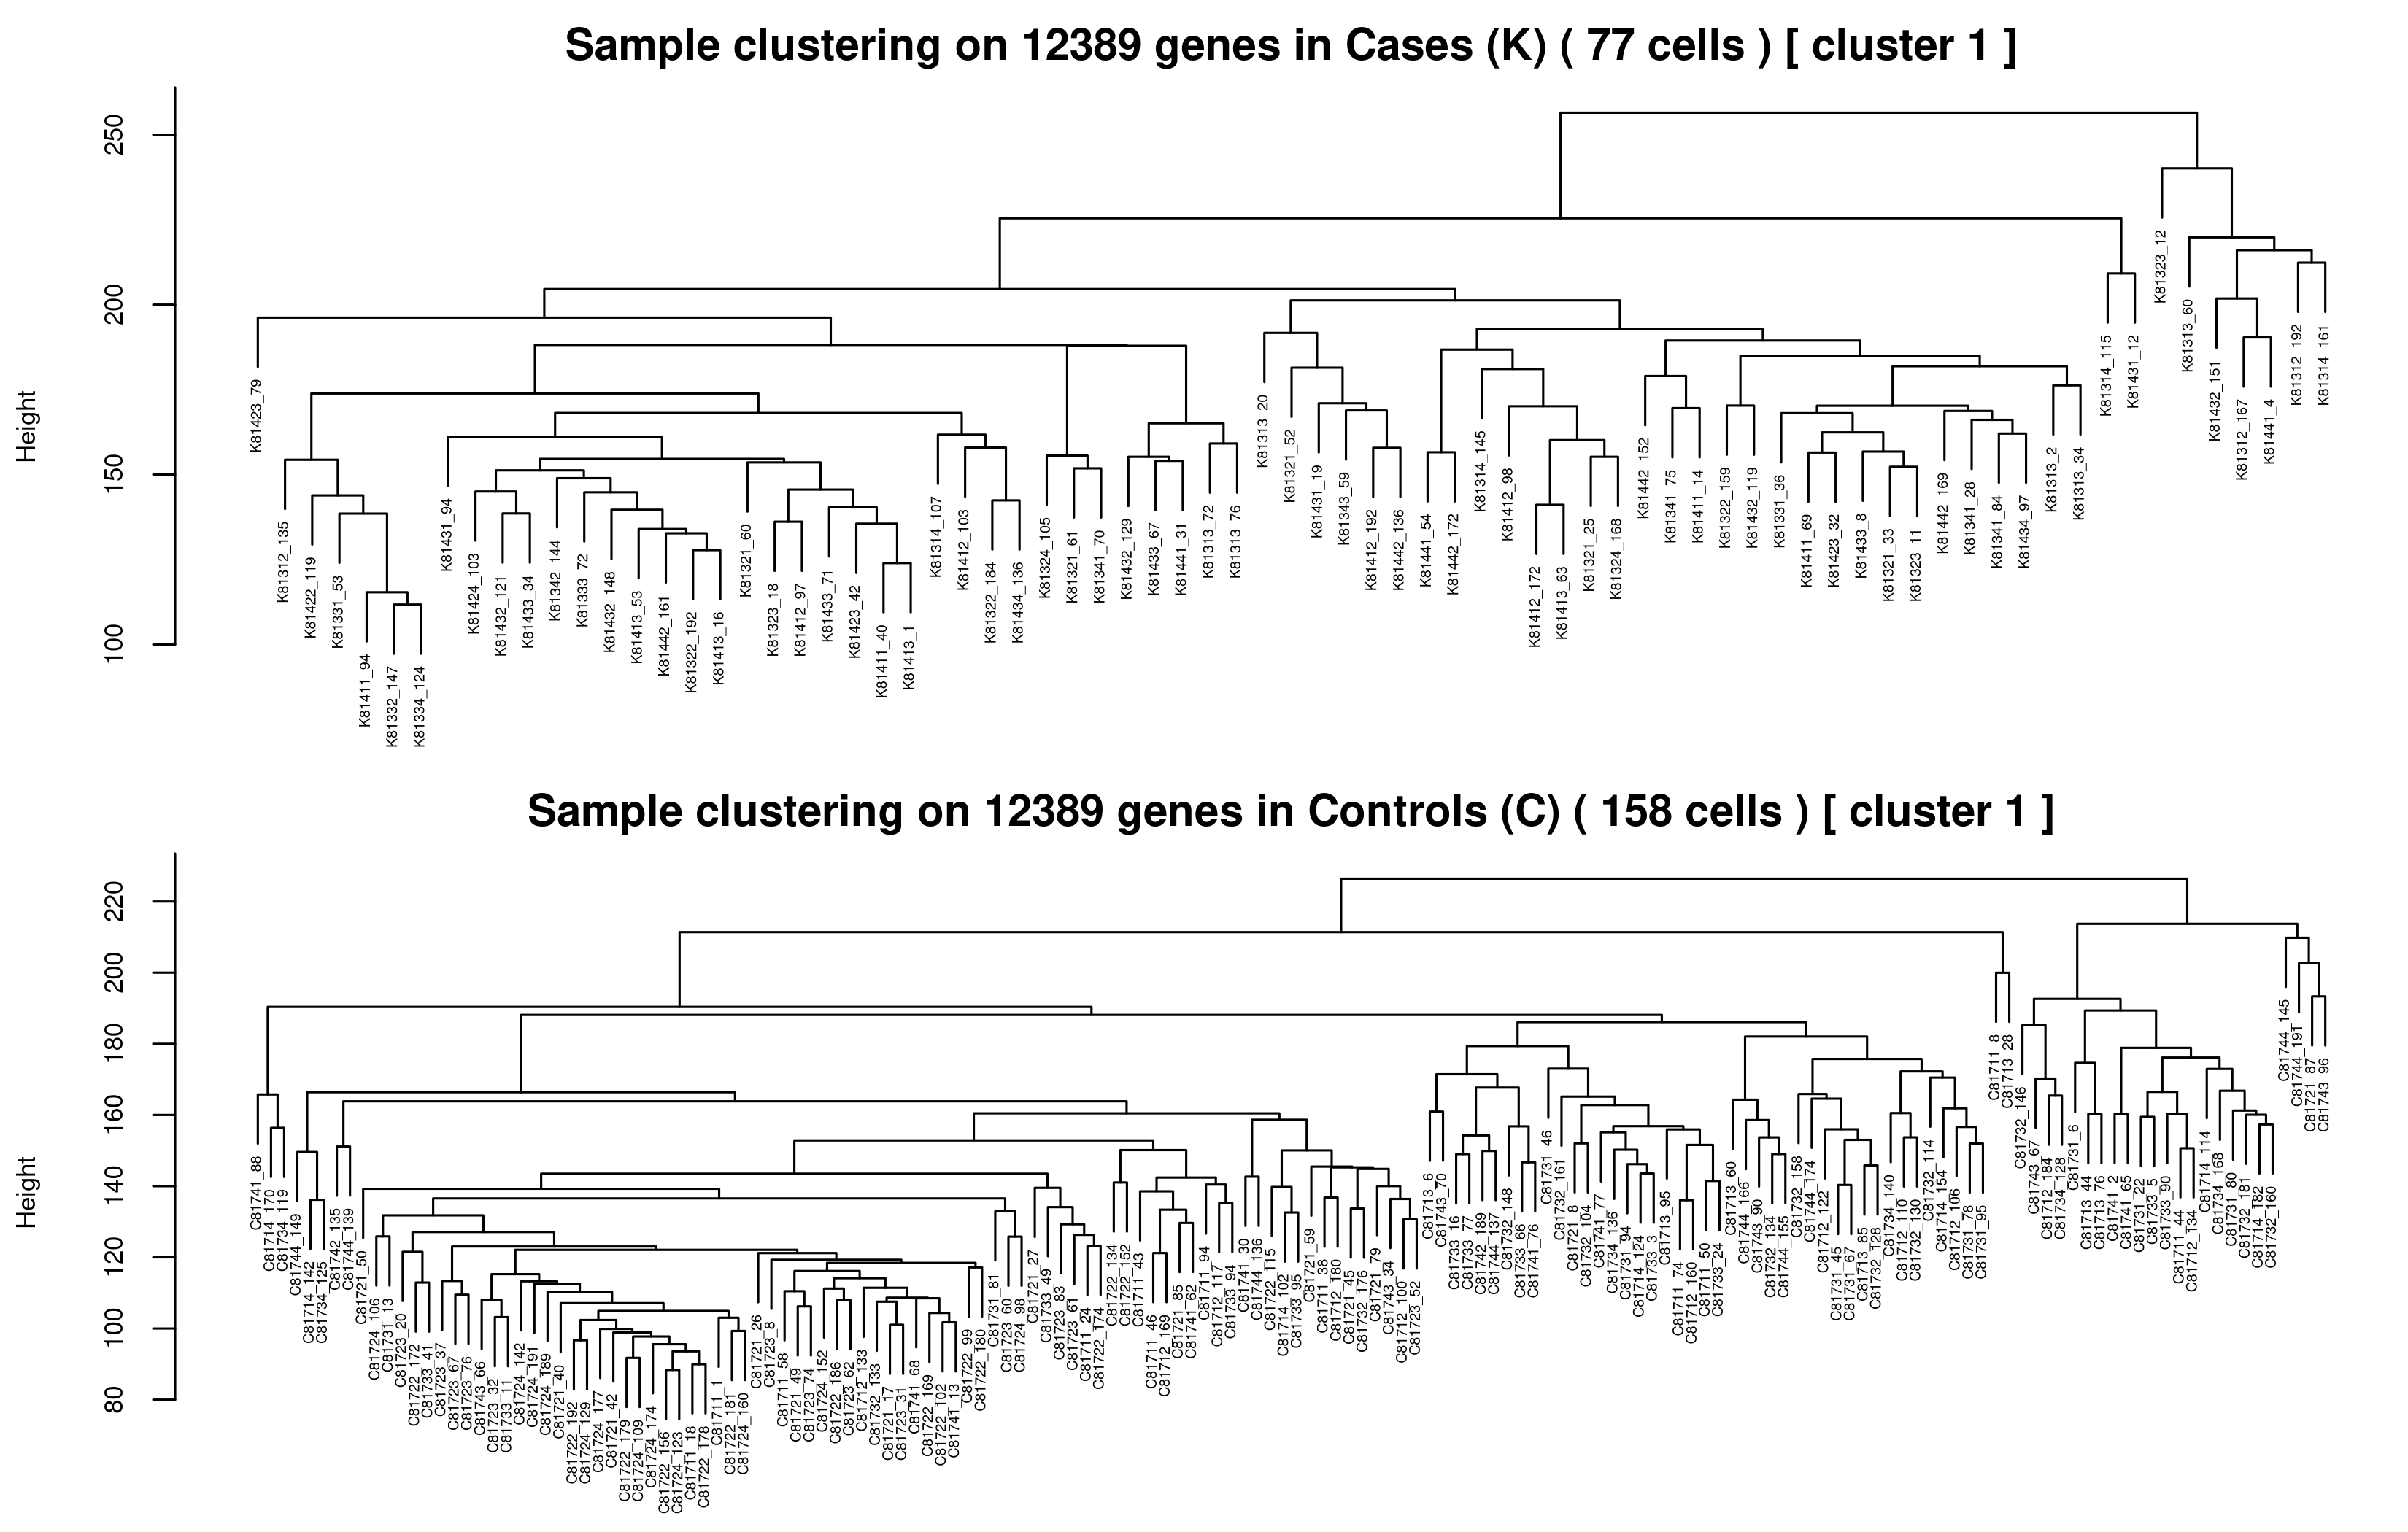

In [128]:
processClust(sc, cln=1)

Cluster 2



[1] "Controls= 110  Cases= 296  (+added)  406  expected= 406"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 296 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 110 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 11734 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 11734, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 11734, bad sample counts: 0, 0
Removing genes: 11734
[1] "[Cleaned] nSets= 2 nGenes= 12040 nSamples= 296 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 12040 nSamples= 110 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


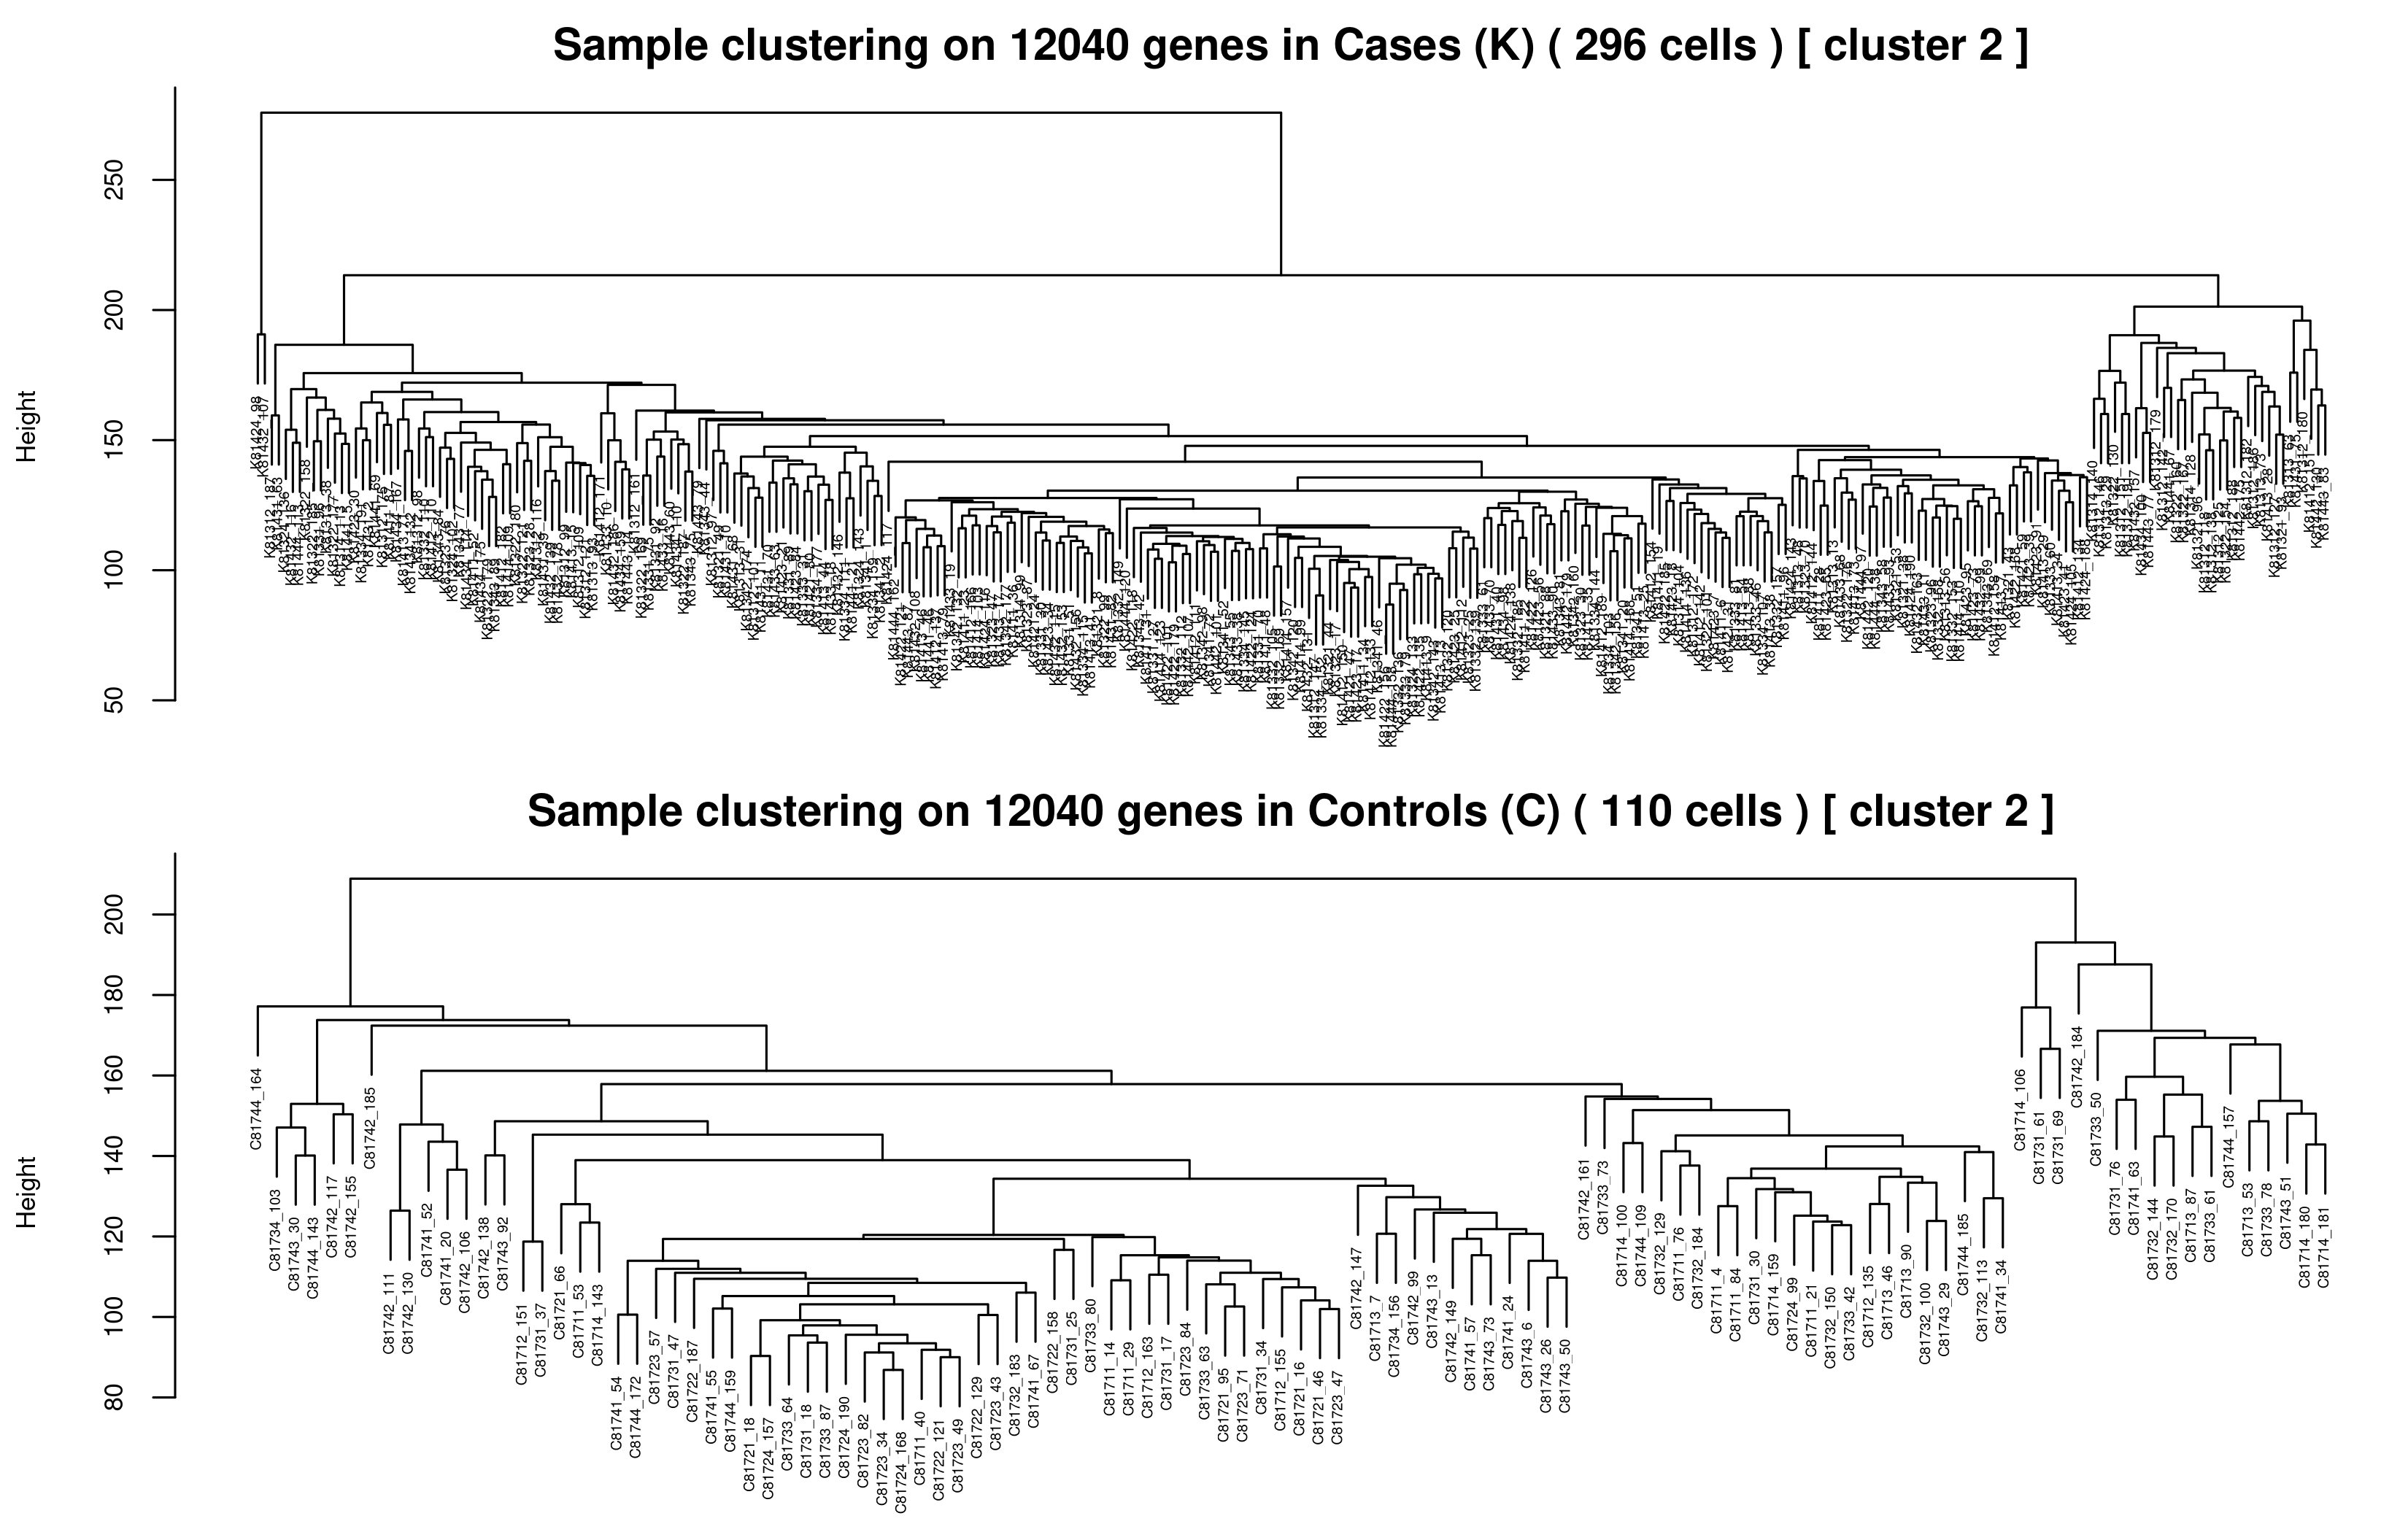

In [129]:
processClust(sc, cln=2)

Cluster 3



[1] "Controls= 93  Cases= 35  (+added)  128  expected= 128"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 35 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 93 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 12139 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 12139, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 12139, bad sample counts: 0, 0
Removing genes: 12139
[1] "[Cleaned] nSets= 2 nGenes= 11635 nSamples= 35 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 11635 nSamples= 93 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


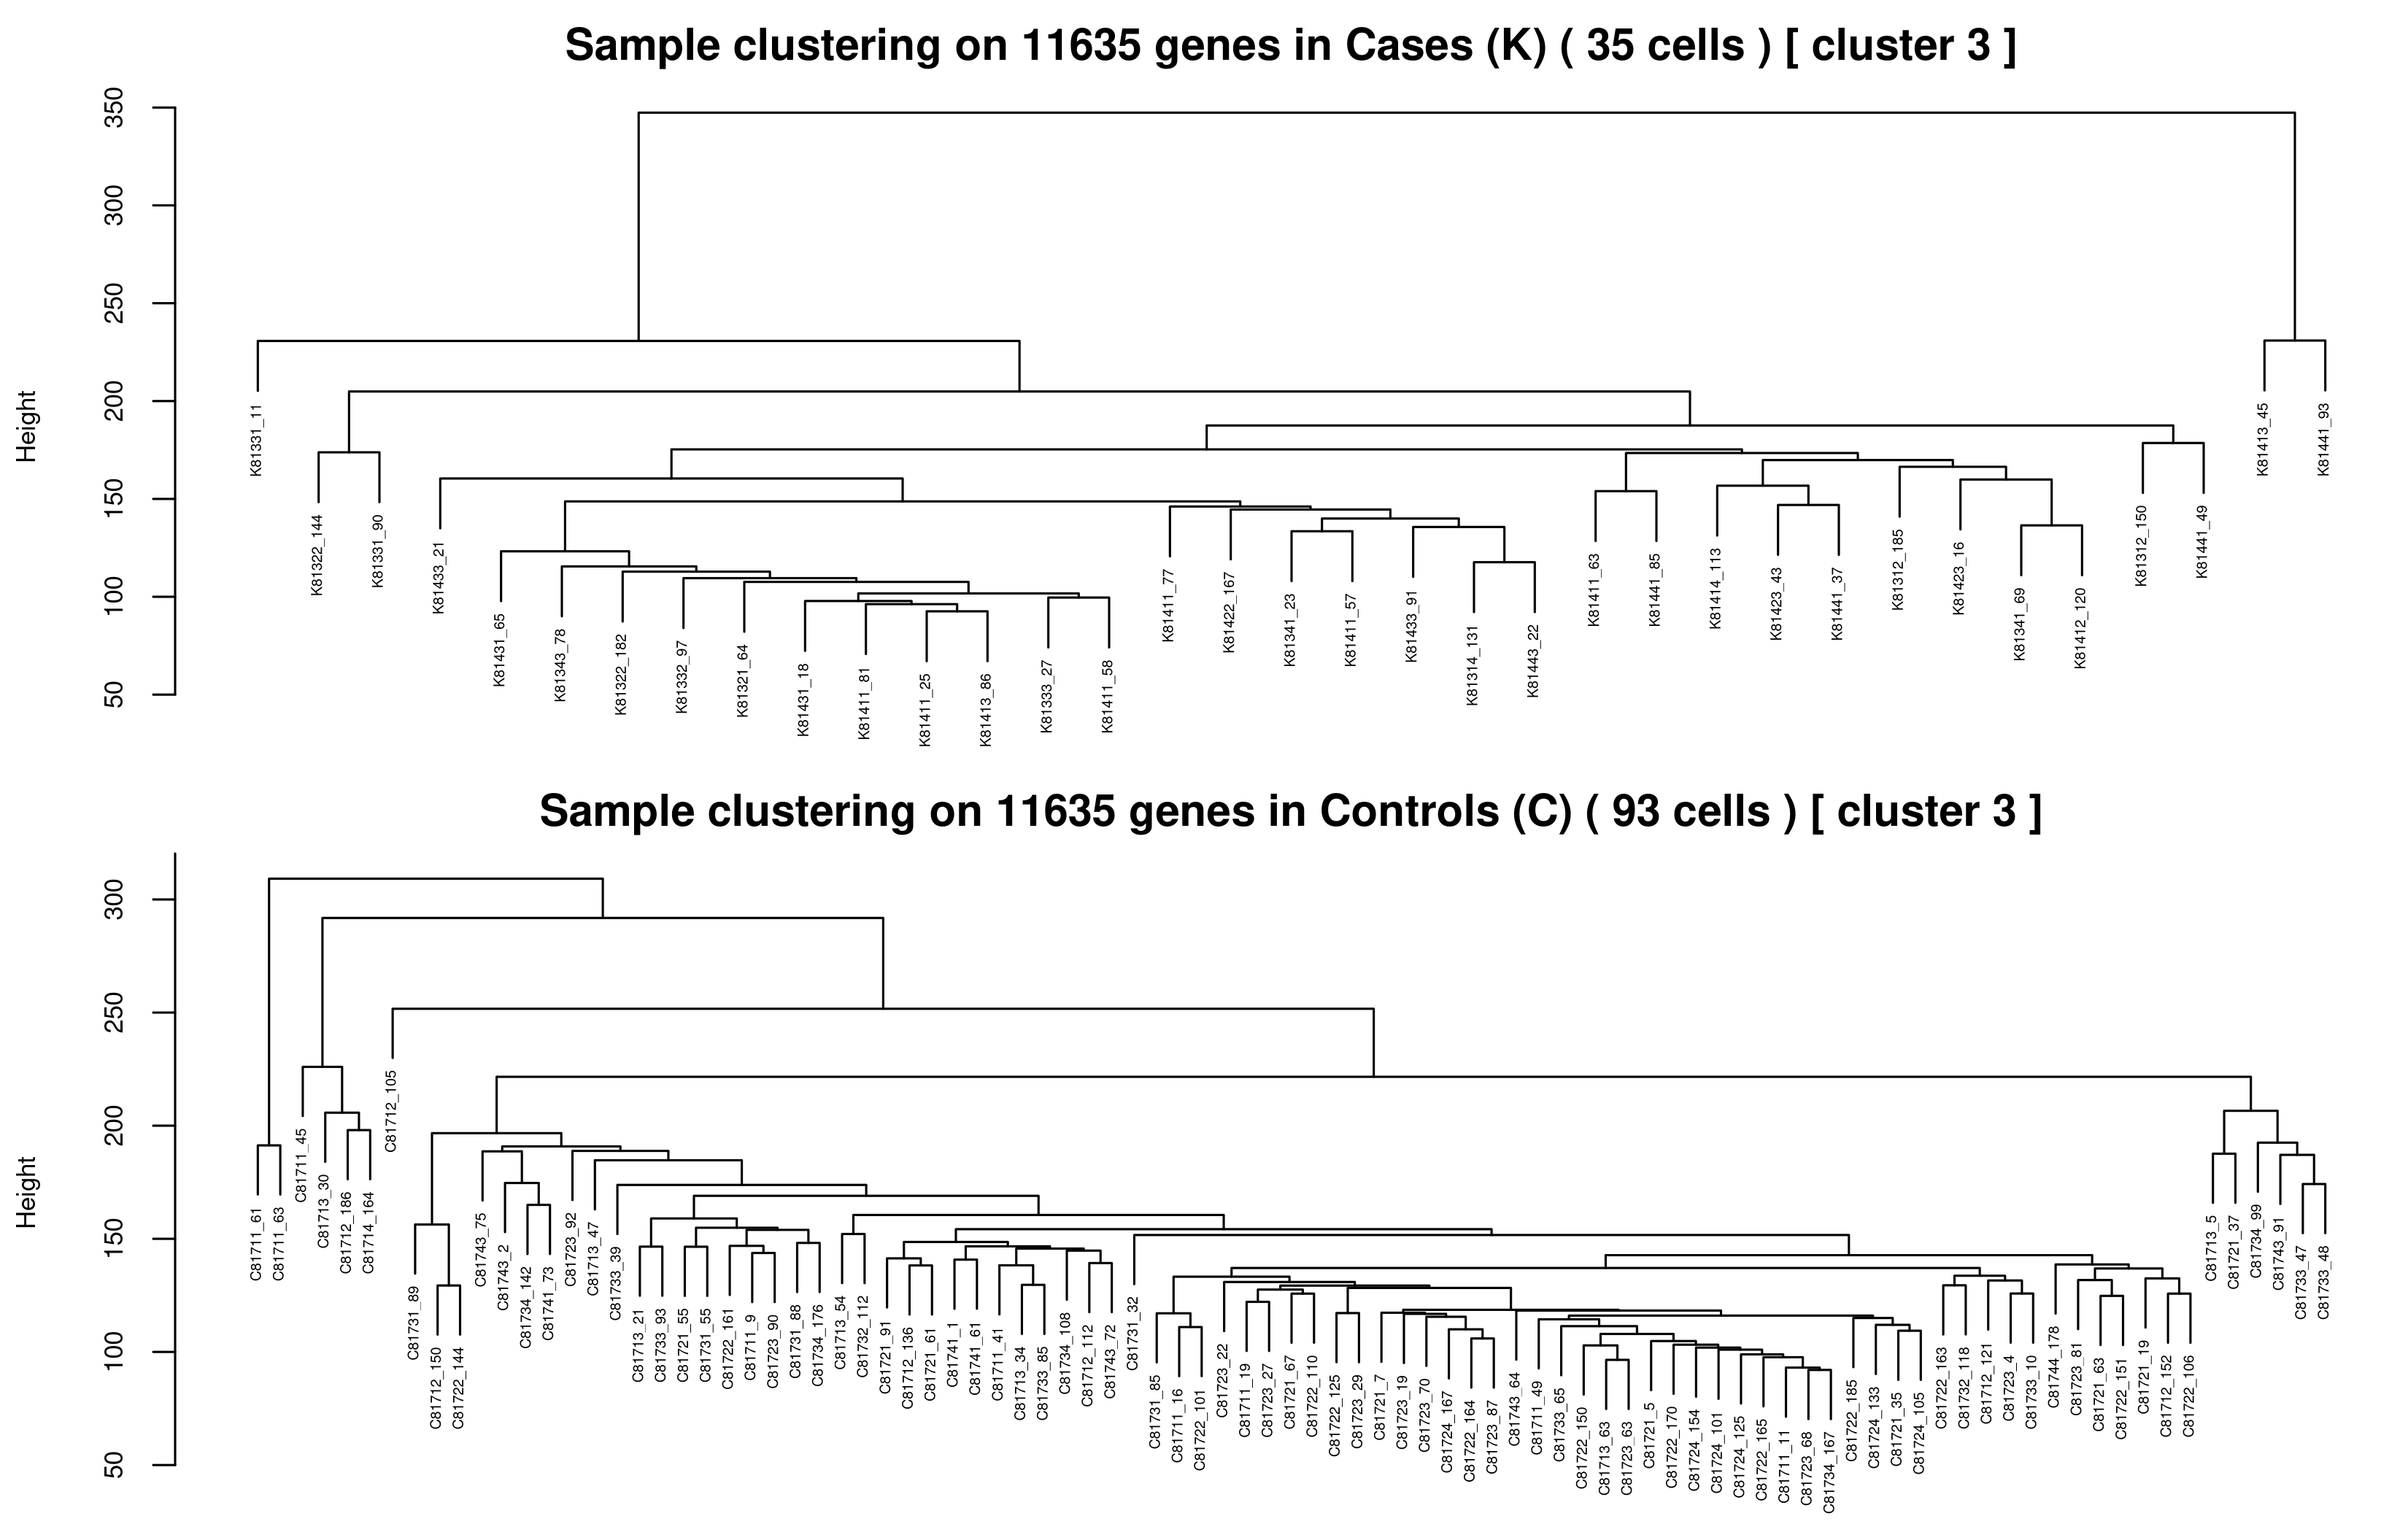

In [130]:
processClust(sc, cln=3)

Cluster 4



[1] "Controls= 271  Cases= 189  (+added)  460  expected= 460"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 189 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 271 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 10361 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 10361, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 10361, bad sample counts: 0, 0
Removing genes: 10361
[1] "[Cleaned] nSets= 2 nGenes= 13413 nSamples= 189 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 13413 nSamples= 271 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


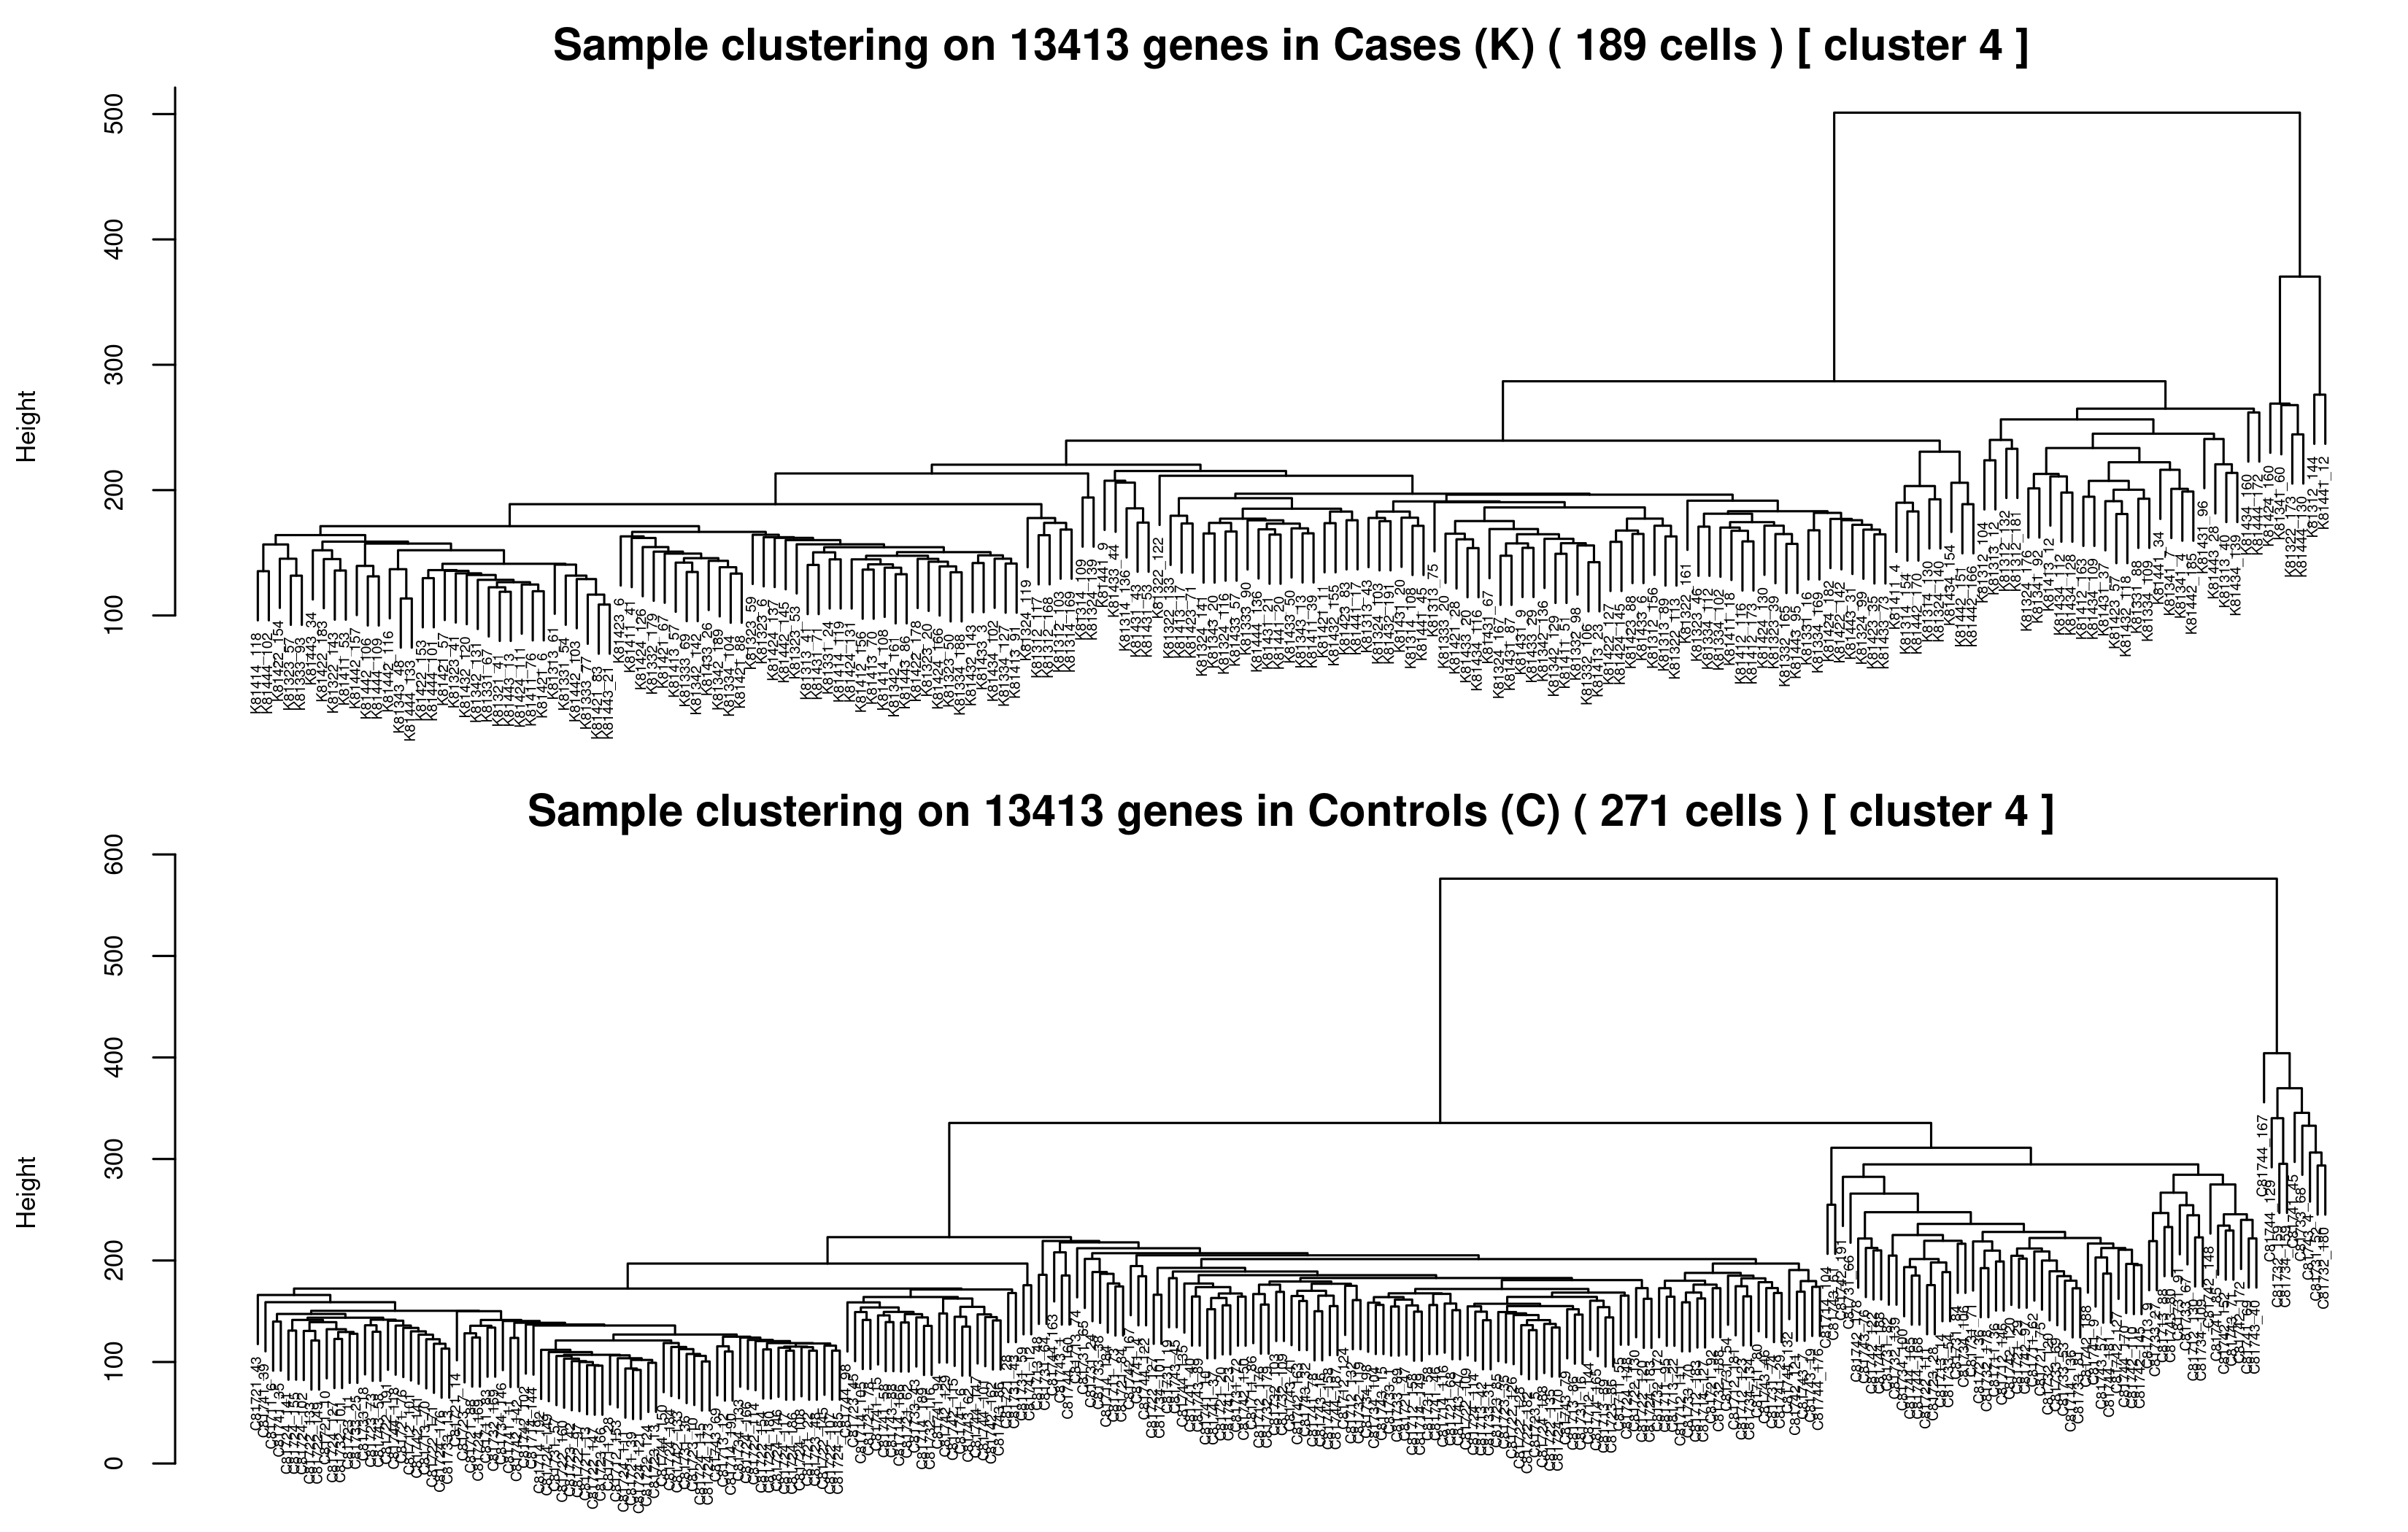

In [131]:
processClust(sc, cln=4)

Cluster 5



[1] "Controls= 130  Cases= 91  (+added)  221  expected= 221"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 91 structureOK= TRUE" 
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 130 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 11665 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 11665, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 11665, bad sample counts: 0, 0
Removing genes: 11665
[1] "[Cleaned] nSets= 2 nGenes= 12109 nSamples= 91 structureOK= TRUE" 
[2] "[Cleaned] nSets= 2 nGenes= 12109 nSamples= 130 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


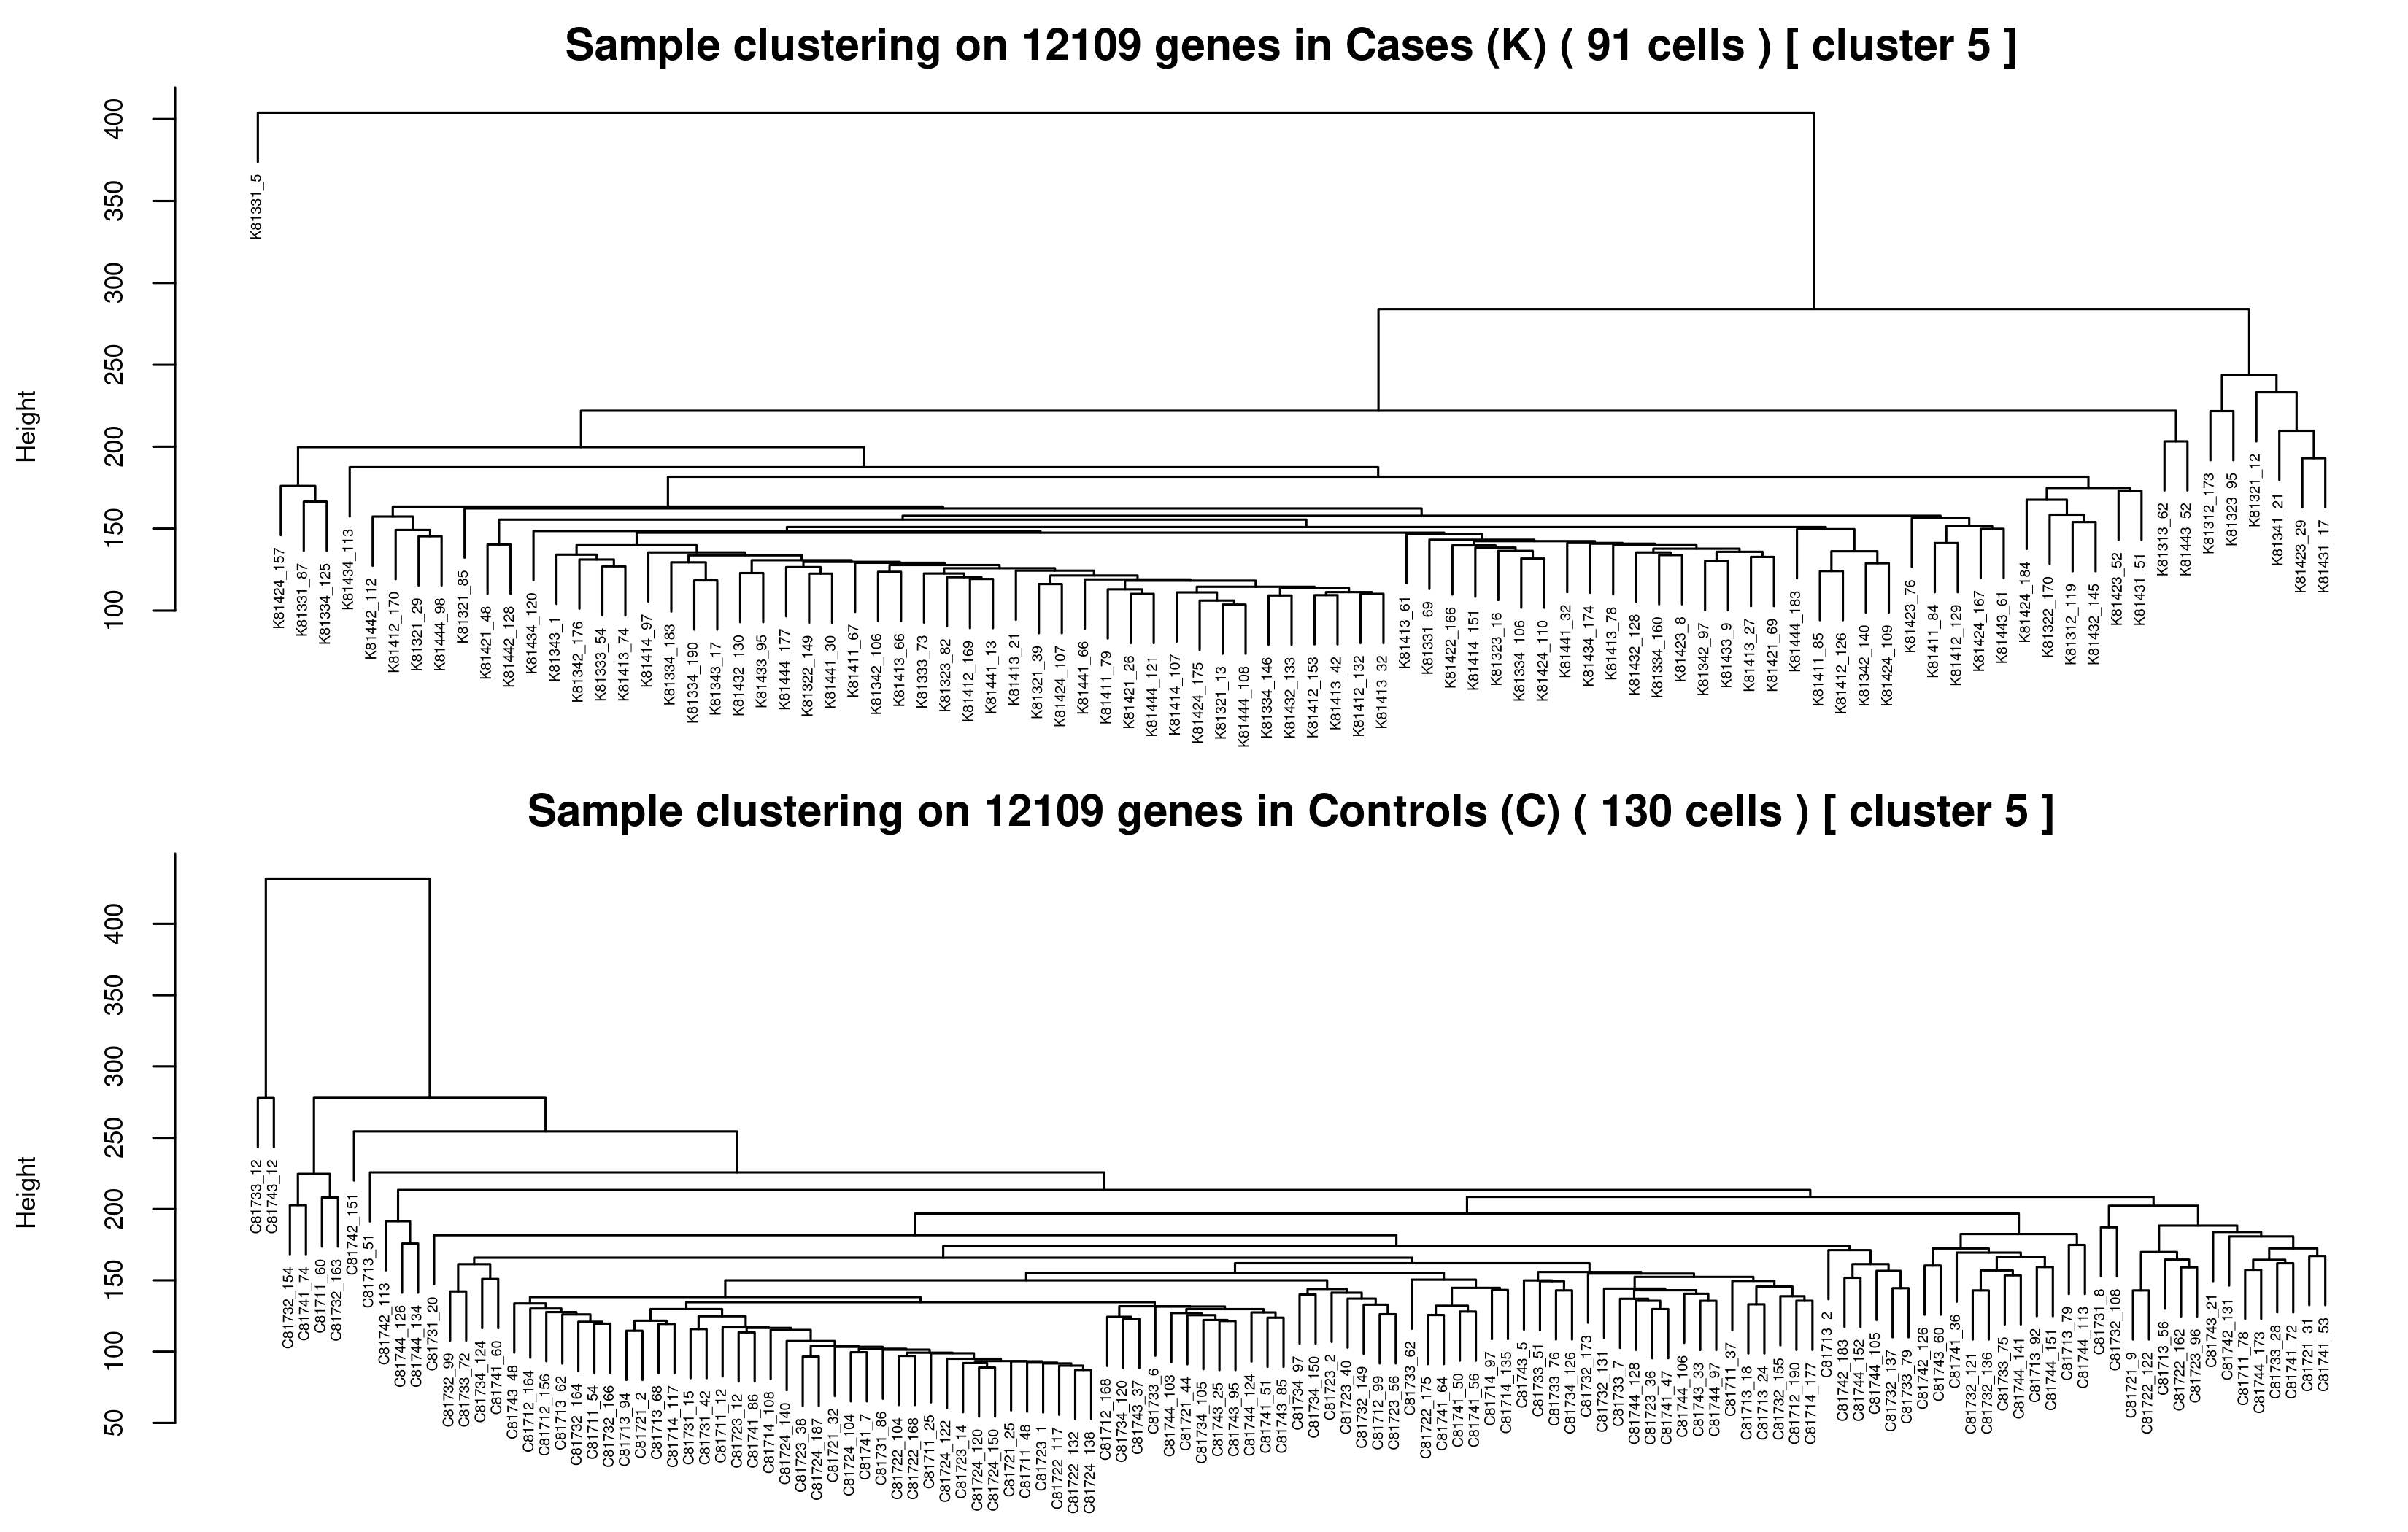

In [134]:
processClust(sc, cln=5)

One outlier in cases

Cluster 6



[1] "Controls= 67  Cases= 314  (+added)  381  expected= 381"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 314 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 67 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 11222 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 11222, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 11222, bad sample counts: 0, 0
Removing genes: 11222
[1] "[Cleaned] nSets= 2 nGenes= 12552 nSamples= 314 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 12552 nSamples= 67 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


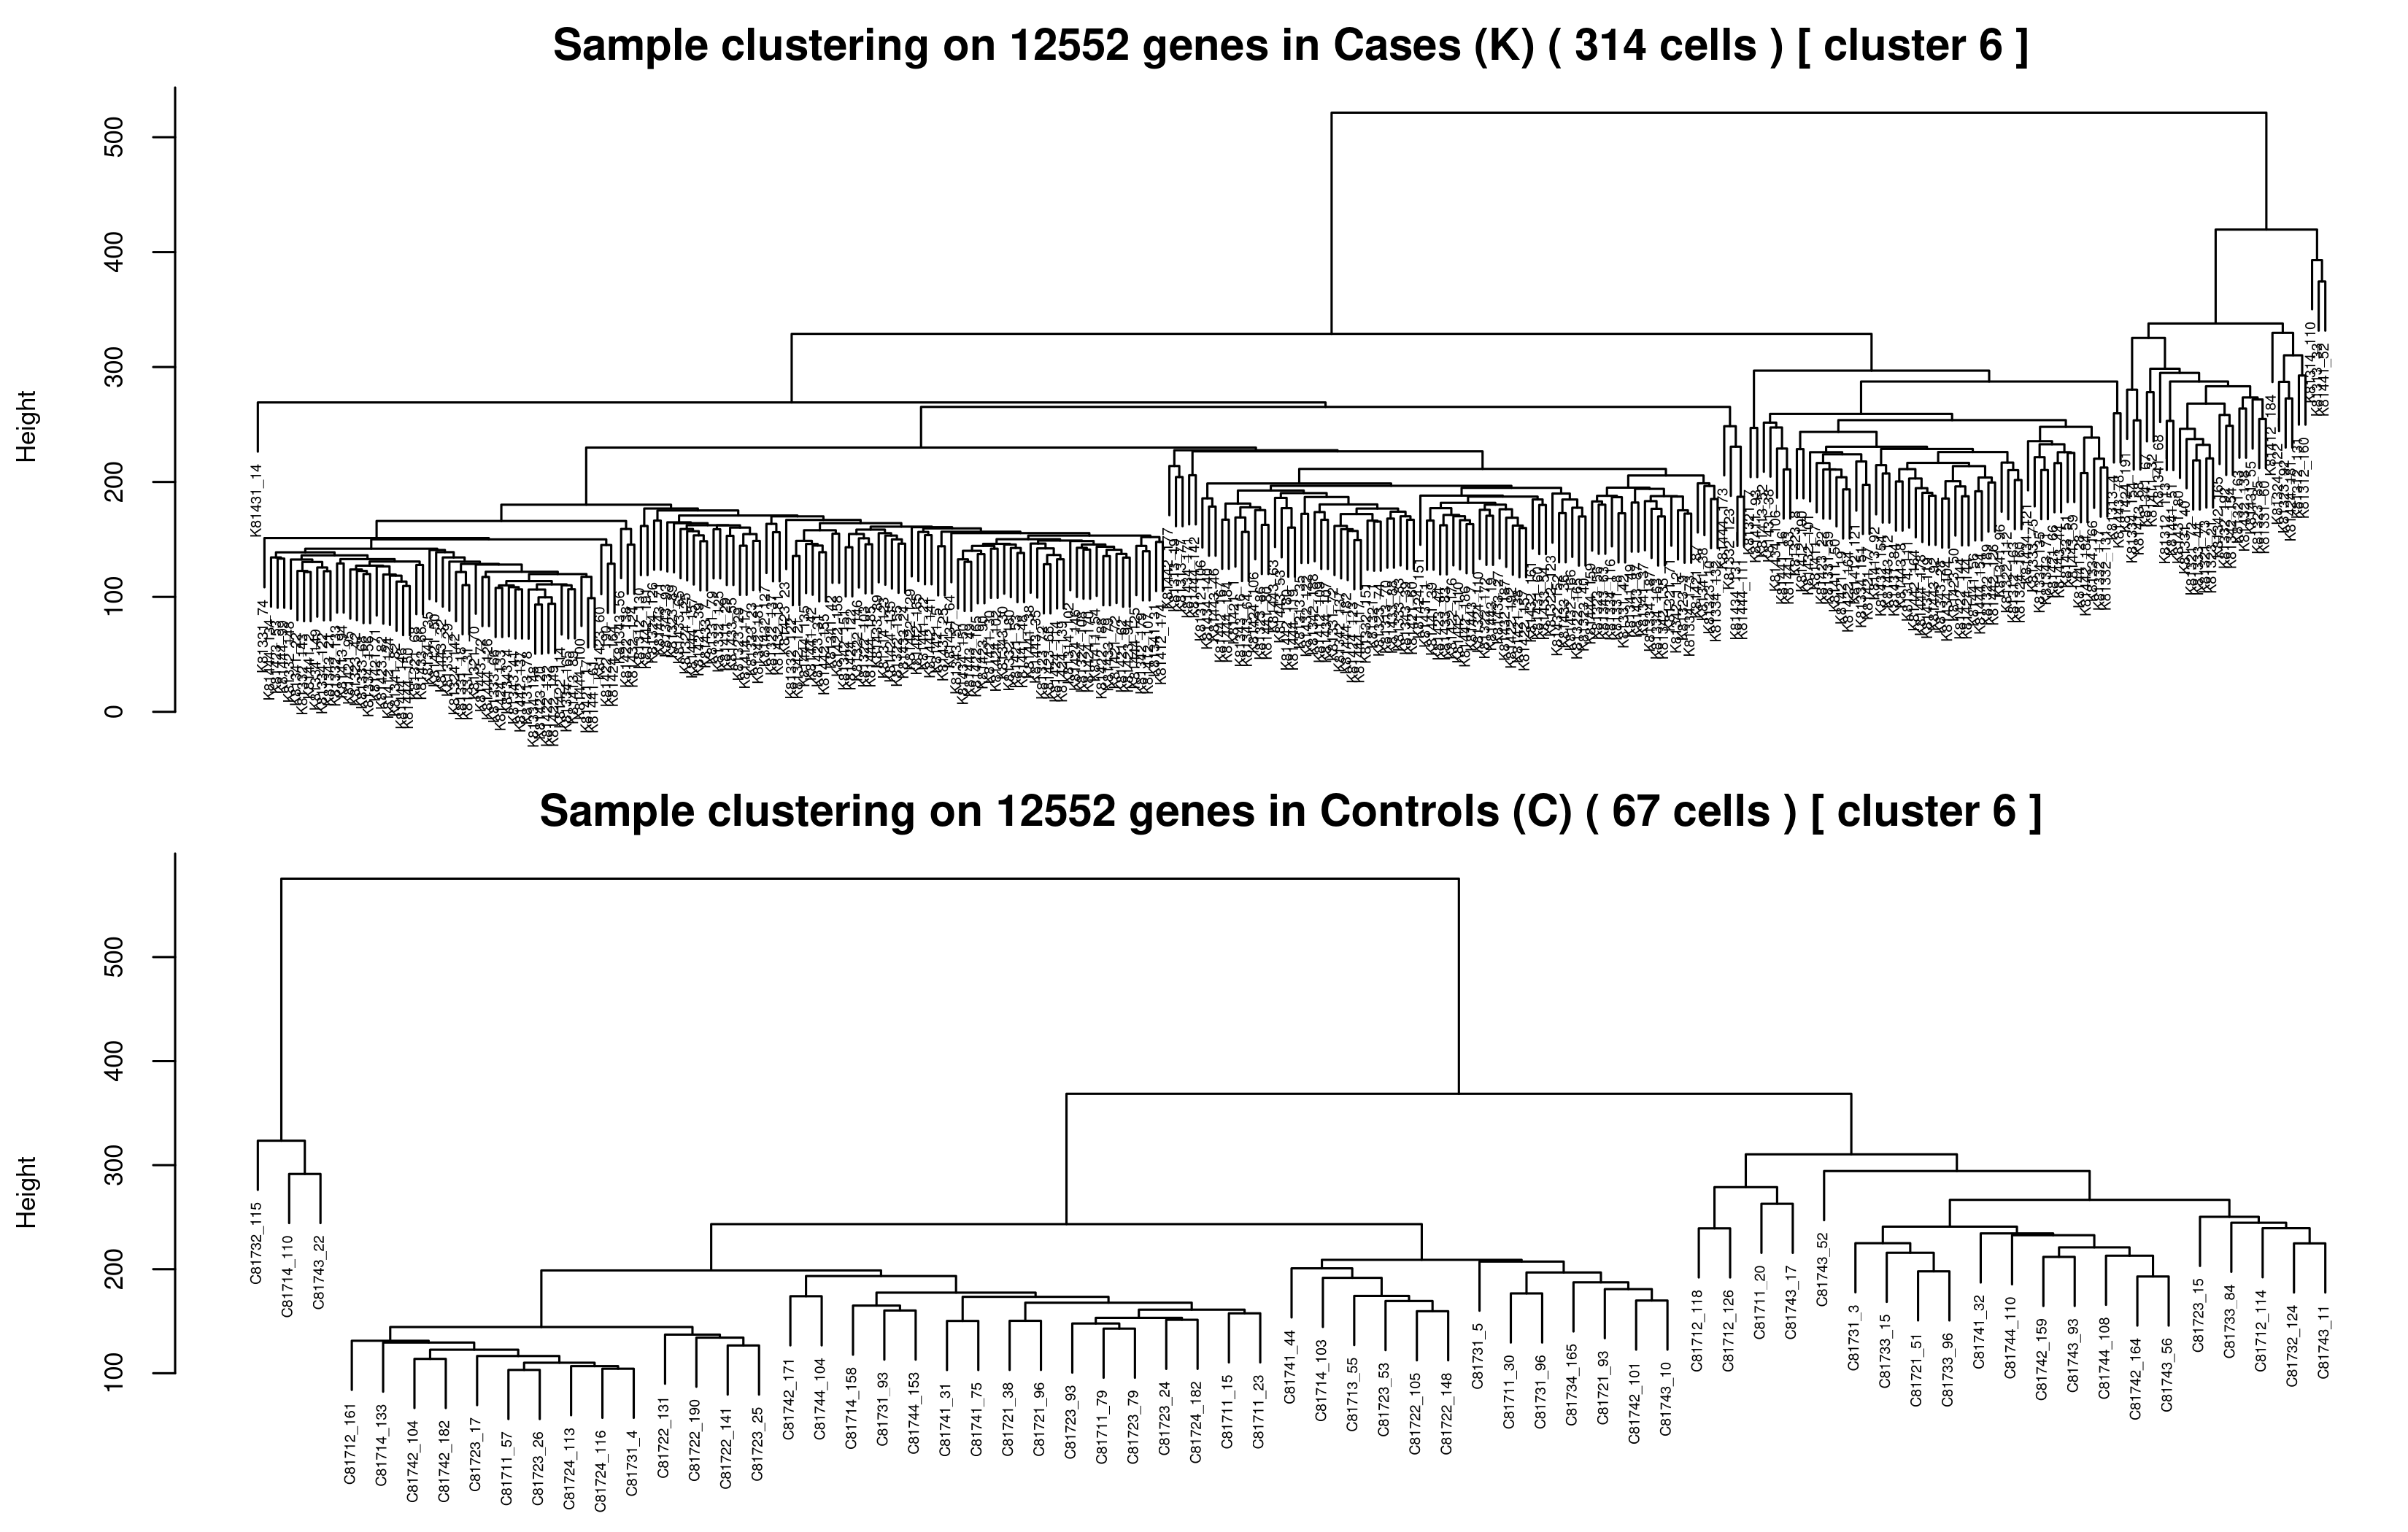

In [135]:
processClust(sc, cln=6)

One outlier (far left) in cases

Cluster 7



[1] "Controls= 25  Cases= 43  (+added)  68  expected= 68"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 43 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 25 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 13004 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 13004, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 13004, bad sample counts: 0, 0
Removing genes: 13004
[1] "[Cleaned] nSets= 2 nGenes= 10770 nSamples= 43 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 10770 nSamples= 25 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


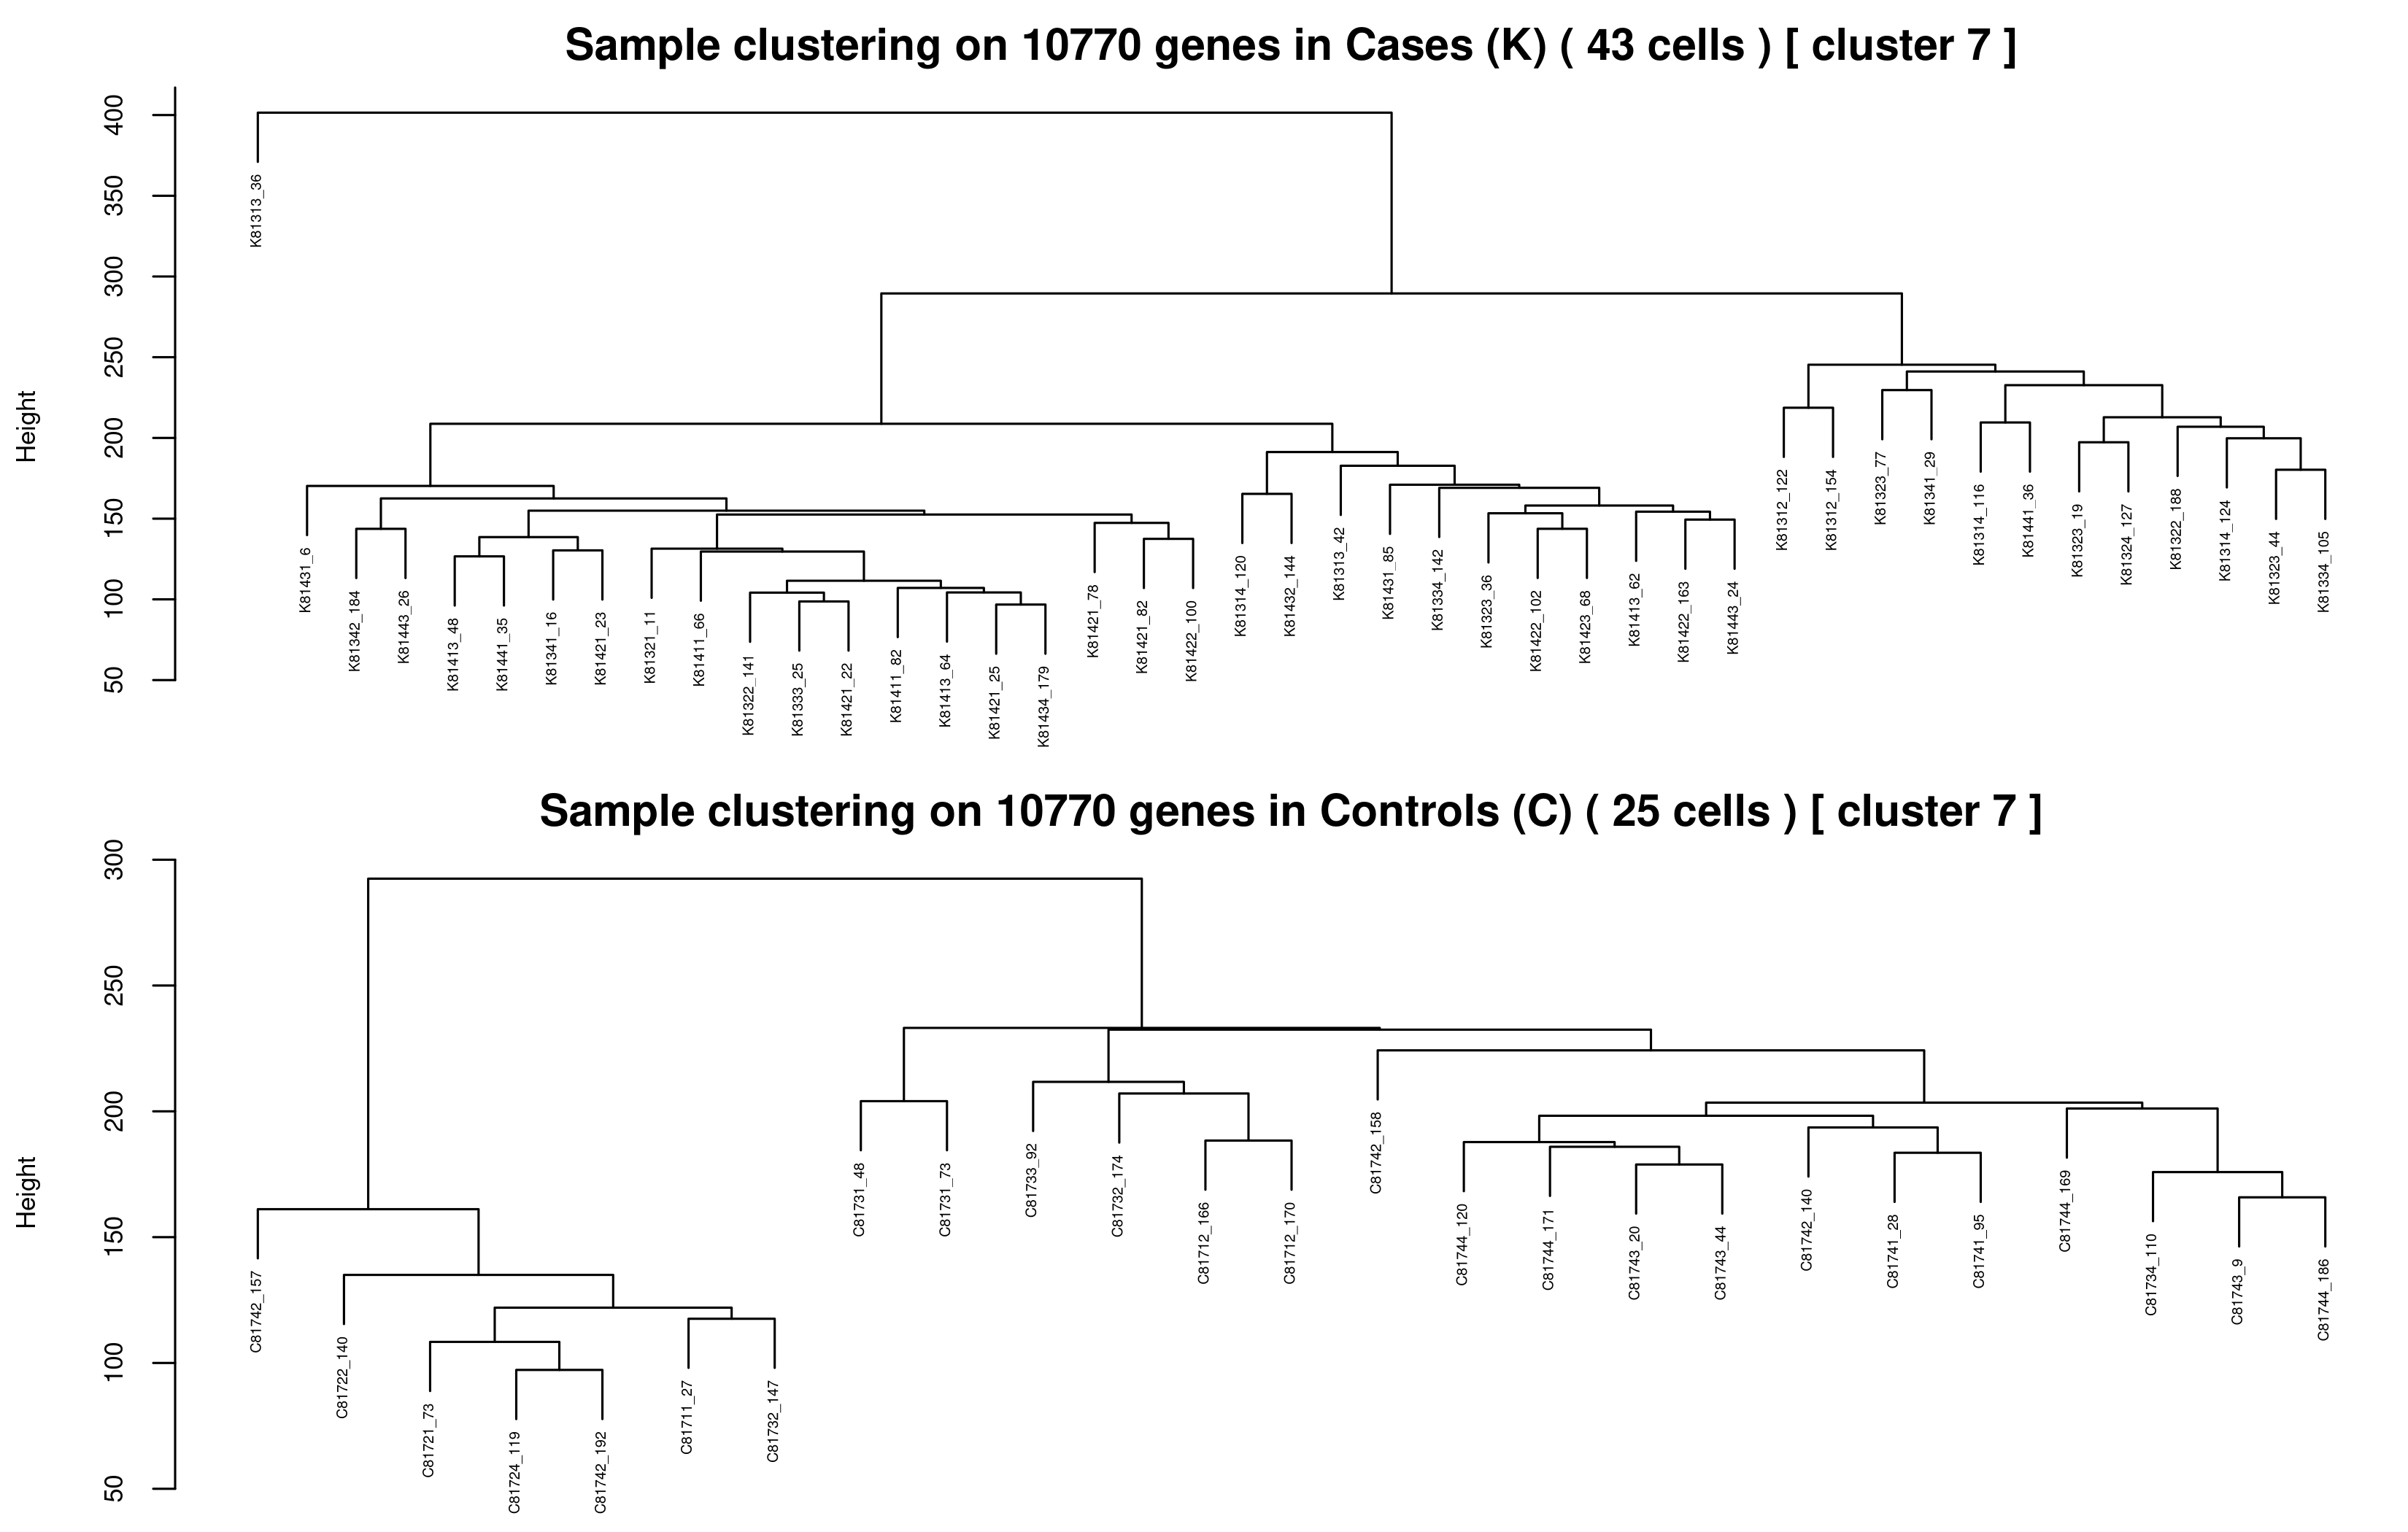

In [136]:
processClust(sc, cln=7)

One outlier in the cases

Cluster 8



[1] "Controls= 64  Cases= 125  (+added)  189  expected= 189"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 125 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 64 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 11519 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 11519, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 11519, bad sample counts: 0, 0
Removing genes: 11519
[1] "[Cleaned] nSets= 2 nGenes= 12255 nSamples= 125 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 12255 nSamples= 64 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


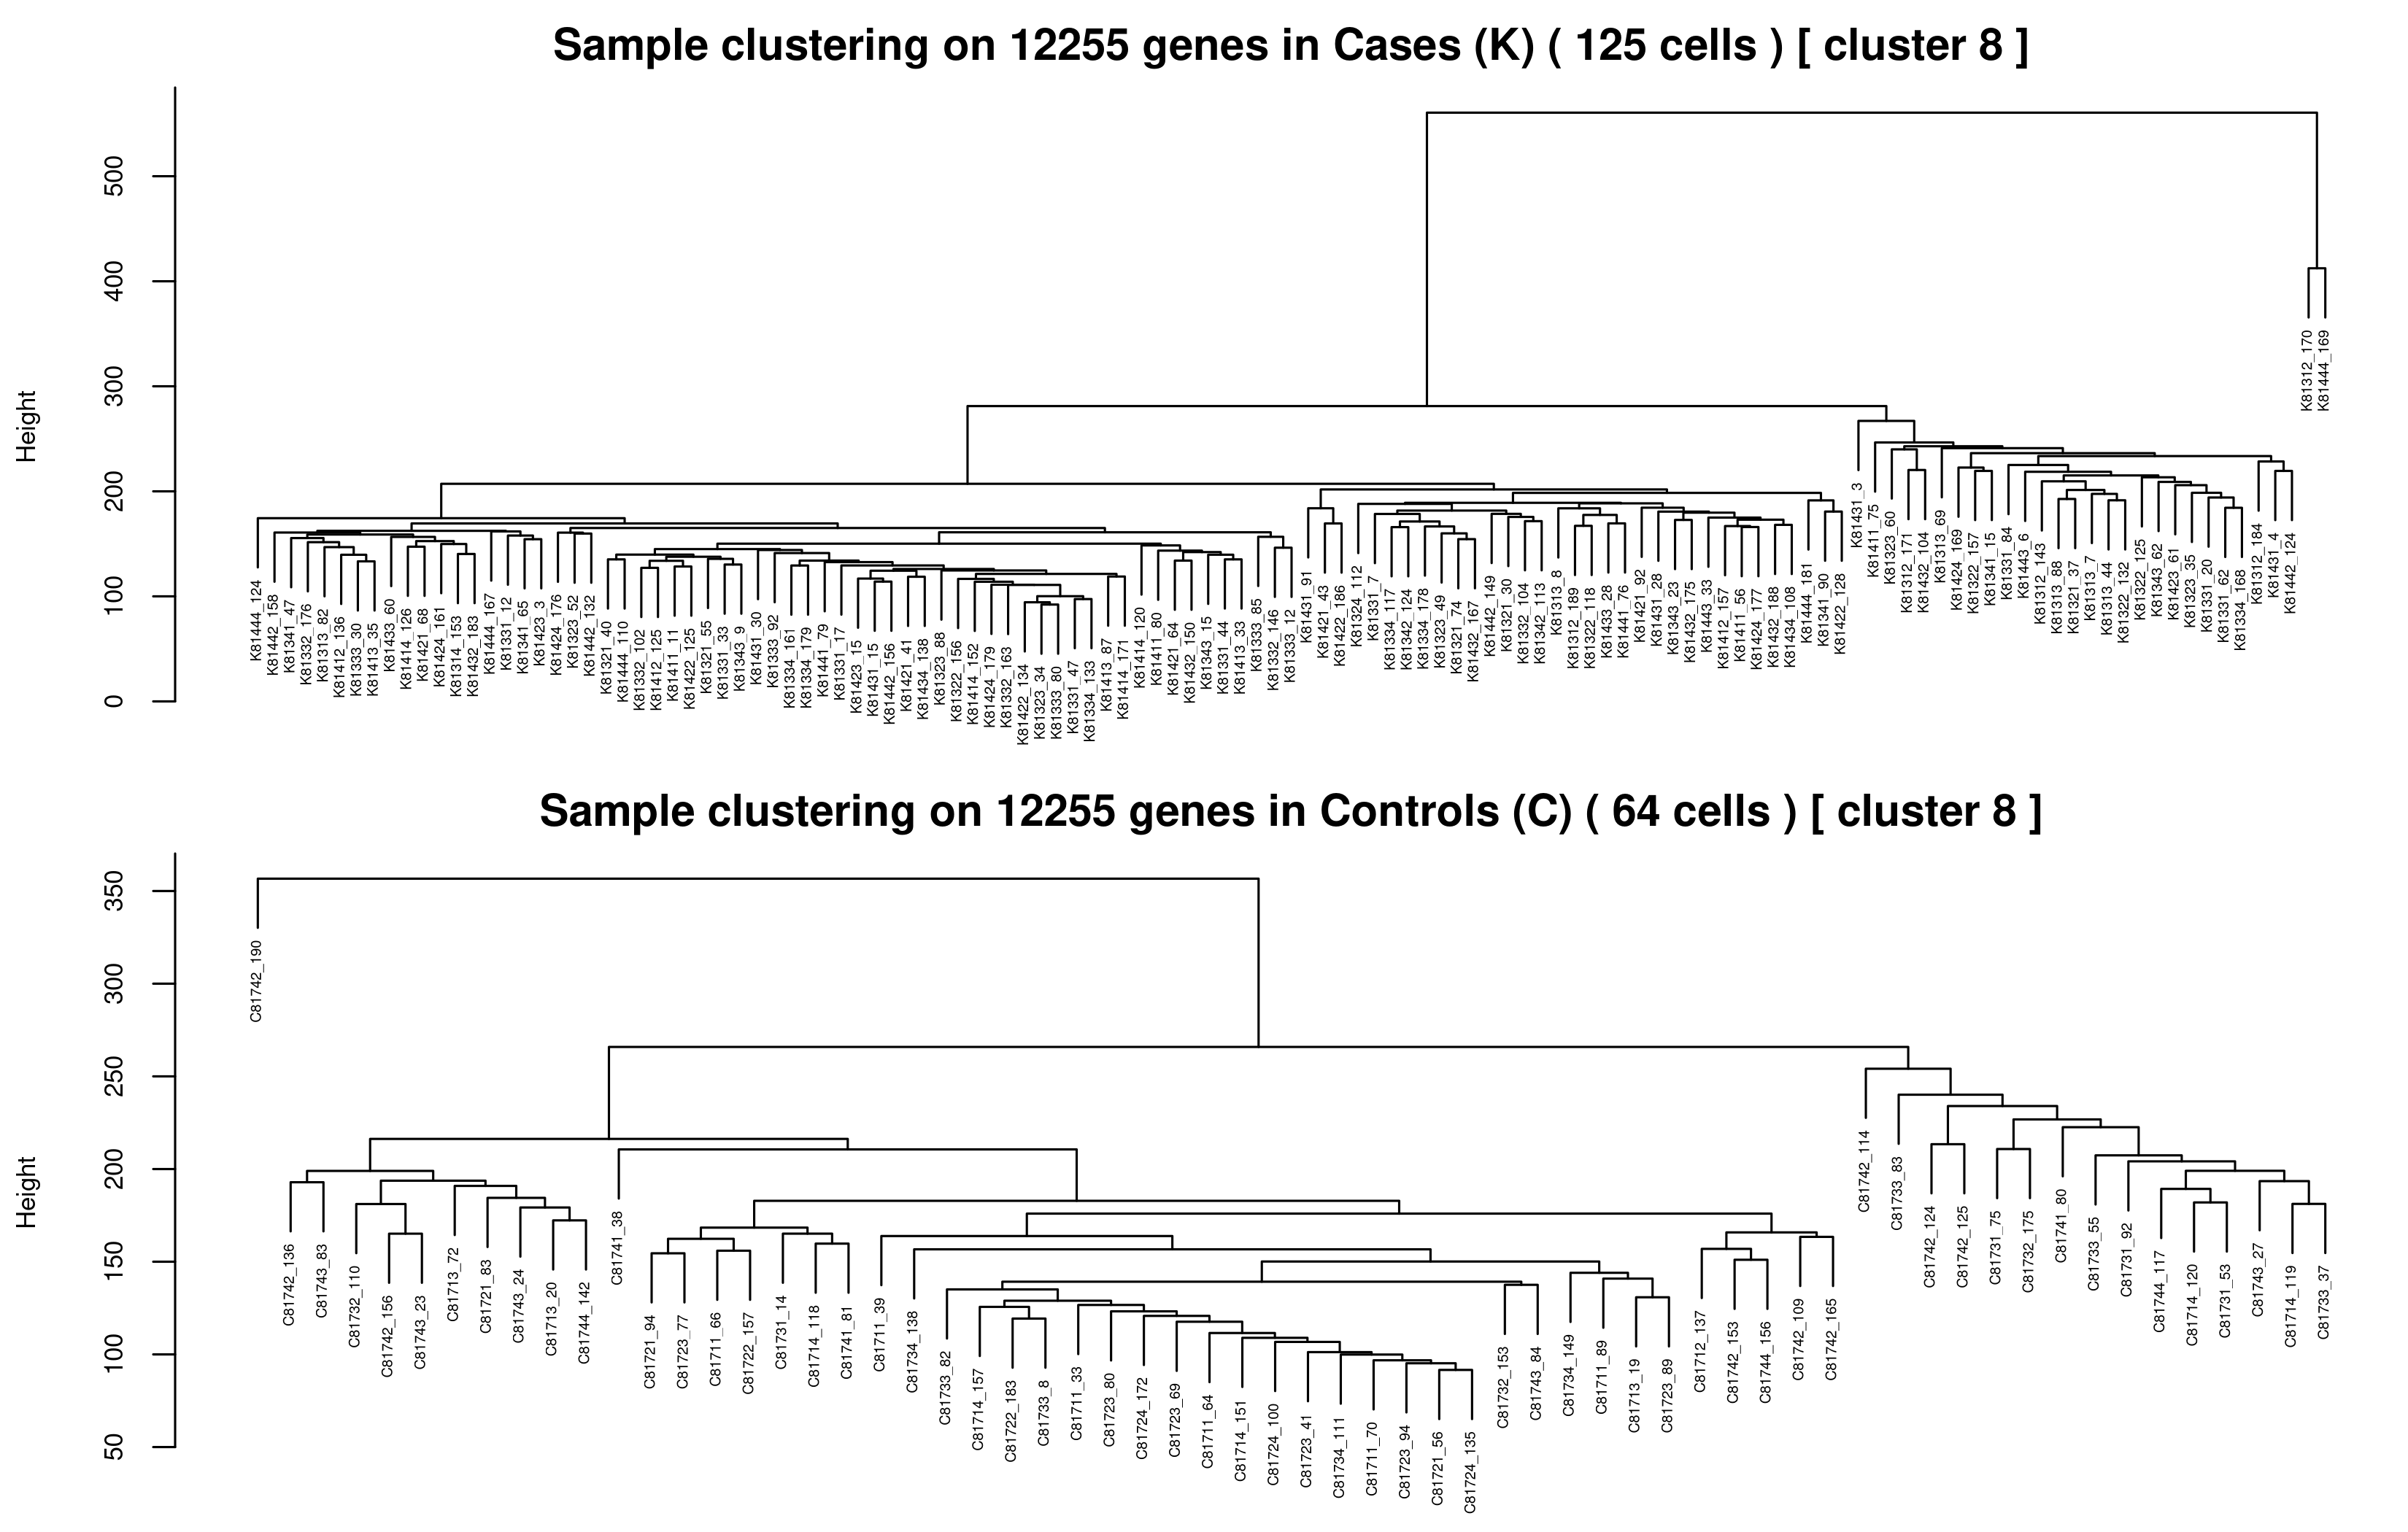

In [137]:
processClust(sc, cln=8)

We have some outliers in this cluster (2 in cases and 1 in control), we should prune this later.

Cluster 9



[1] "Controls= 72  Cases= 191  (+added)  263  expected= 263"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 191 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 72 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 12361 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 12361, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 12361, bad sample counts: 0, 0
Removing genes: 12361
[1] "[Cleaned] nSets= 2 nGenes= 11413 nSamples= 191 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 11413 nSamples= 72 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


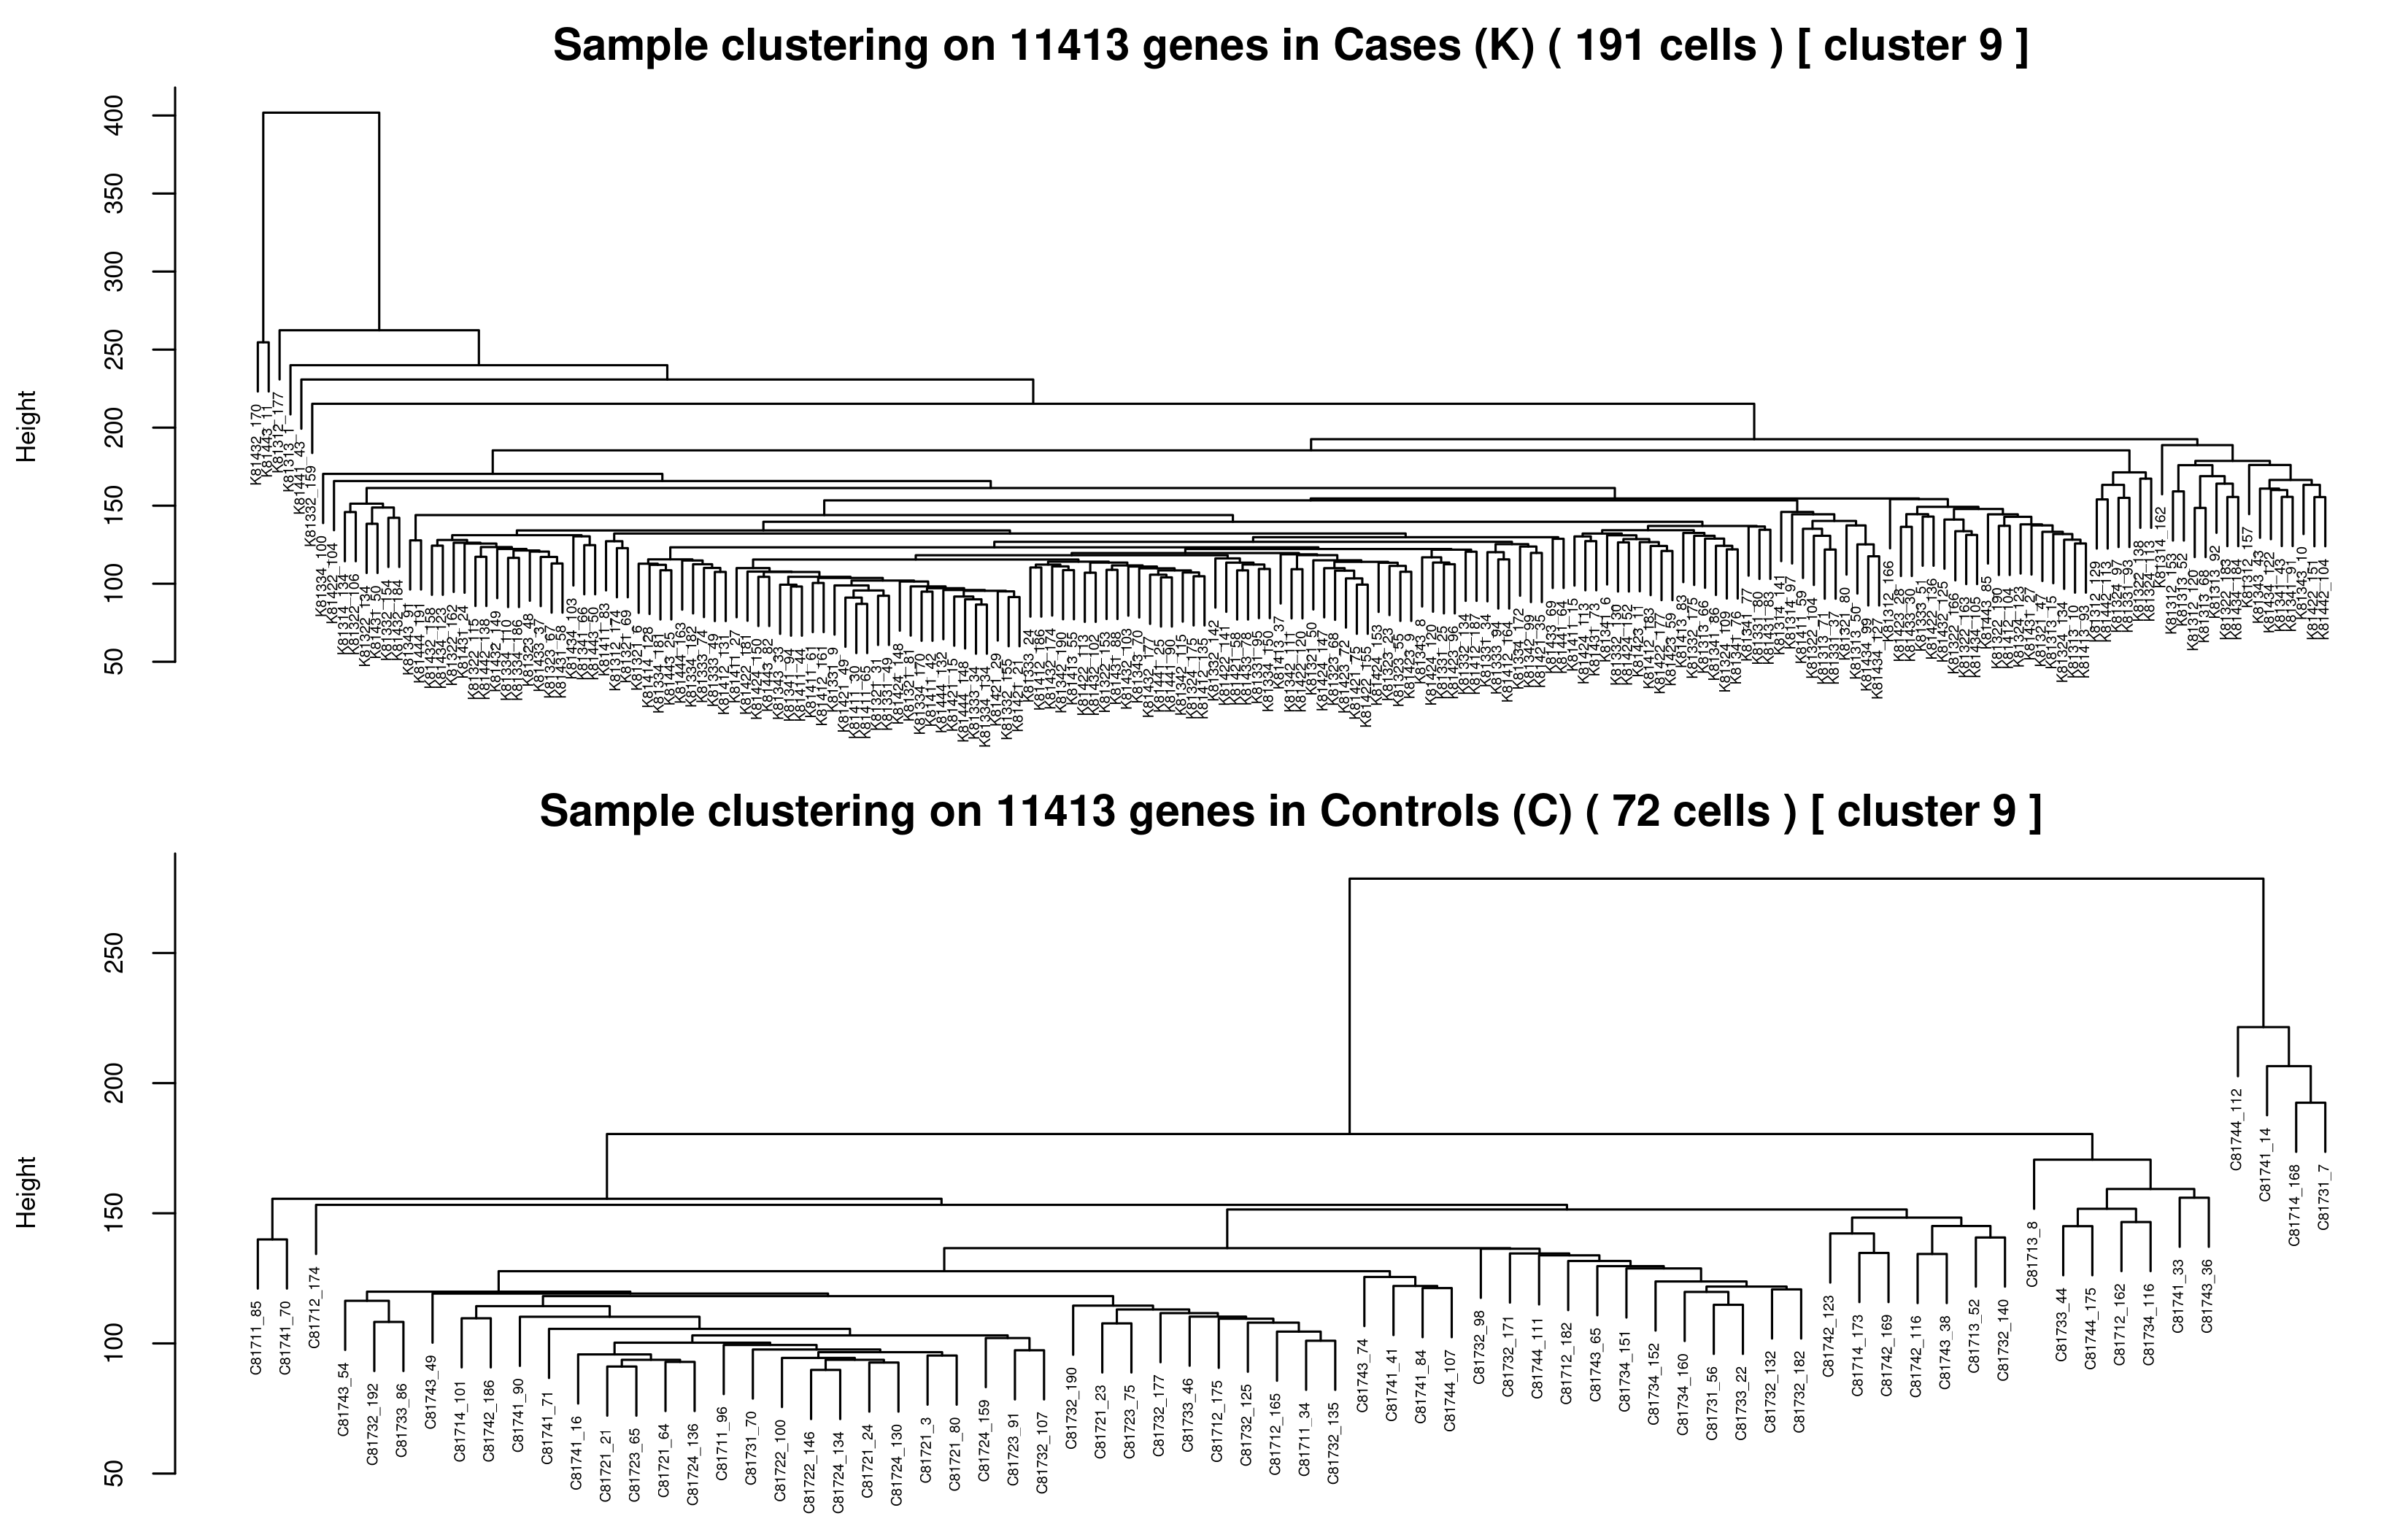

In [149]:
processClust(sc, cln=9)

outliers: 2 in cases and possibly 4 in controls. Not sure if these are really outliers, the top tree is really unbalanced.

Cluster 10



[1] "Controls= 33  Cases= 59  (+added)  92  expected= 92"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 59 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 33 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 12580 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 12580, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 12580, bad sample counts: 0, 0
Removing genes: 12580
[1] "[Cleaned] nSets= 2 nGenes= 11194 nSamples= 59 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 11194 nSamples= 33 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


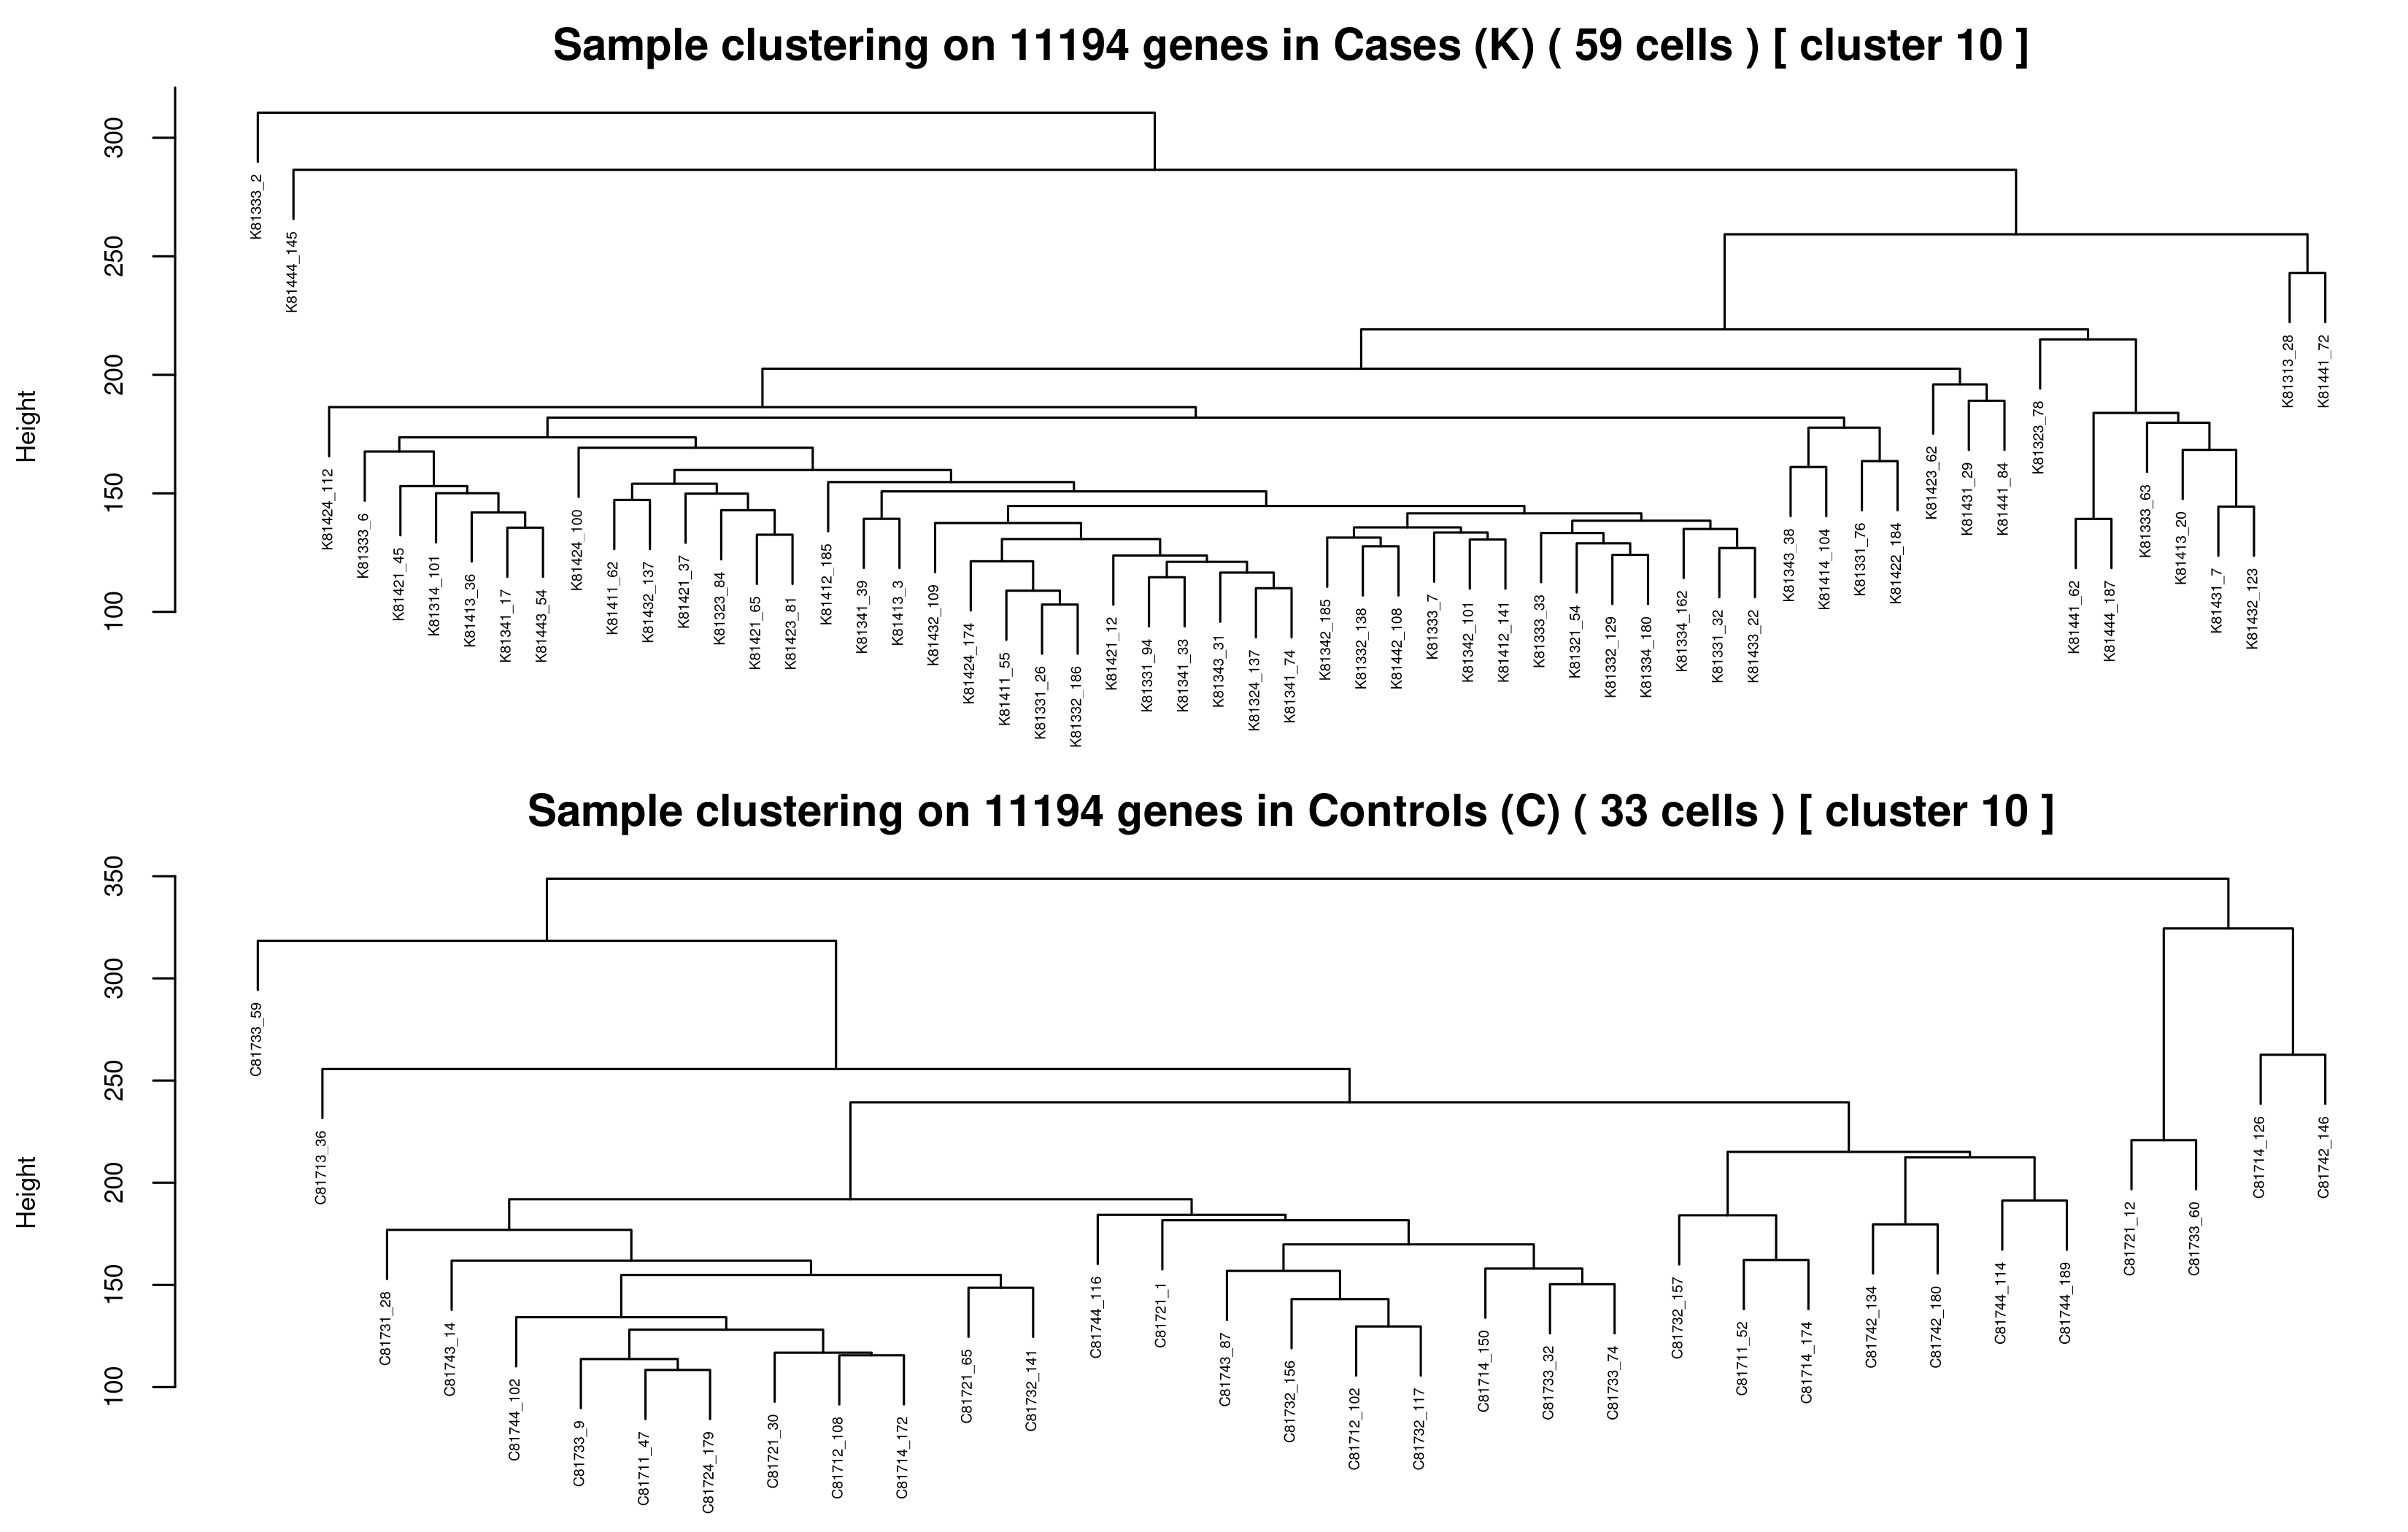

In [139]:
processClust(sc, cln=10)

outliers: none

Cluster 11



[1] "Controls= 16  Cases= 41  (+added)  57  expected= 57"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 41 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 16 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 14367 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 14367, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 14367, bad sample counts: 0, 0
Removing genes: 14367
[1] "[Cleaned] nSets= 2 nGenes= 9407 nSamples= 41 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 9407 nSamples= 16 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


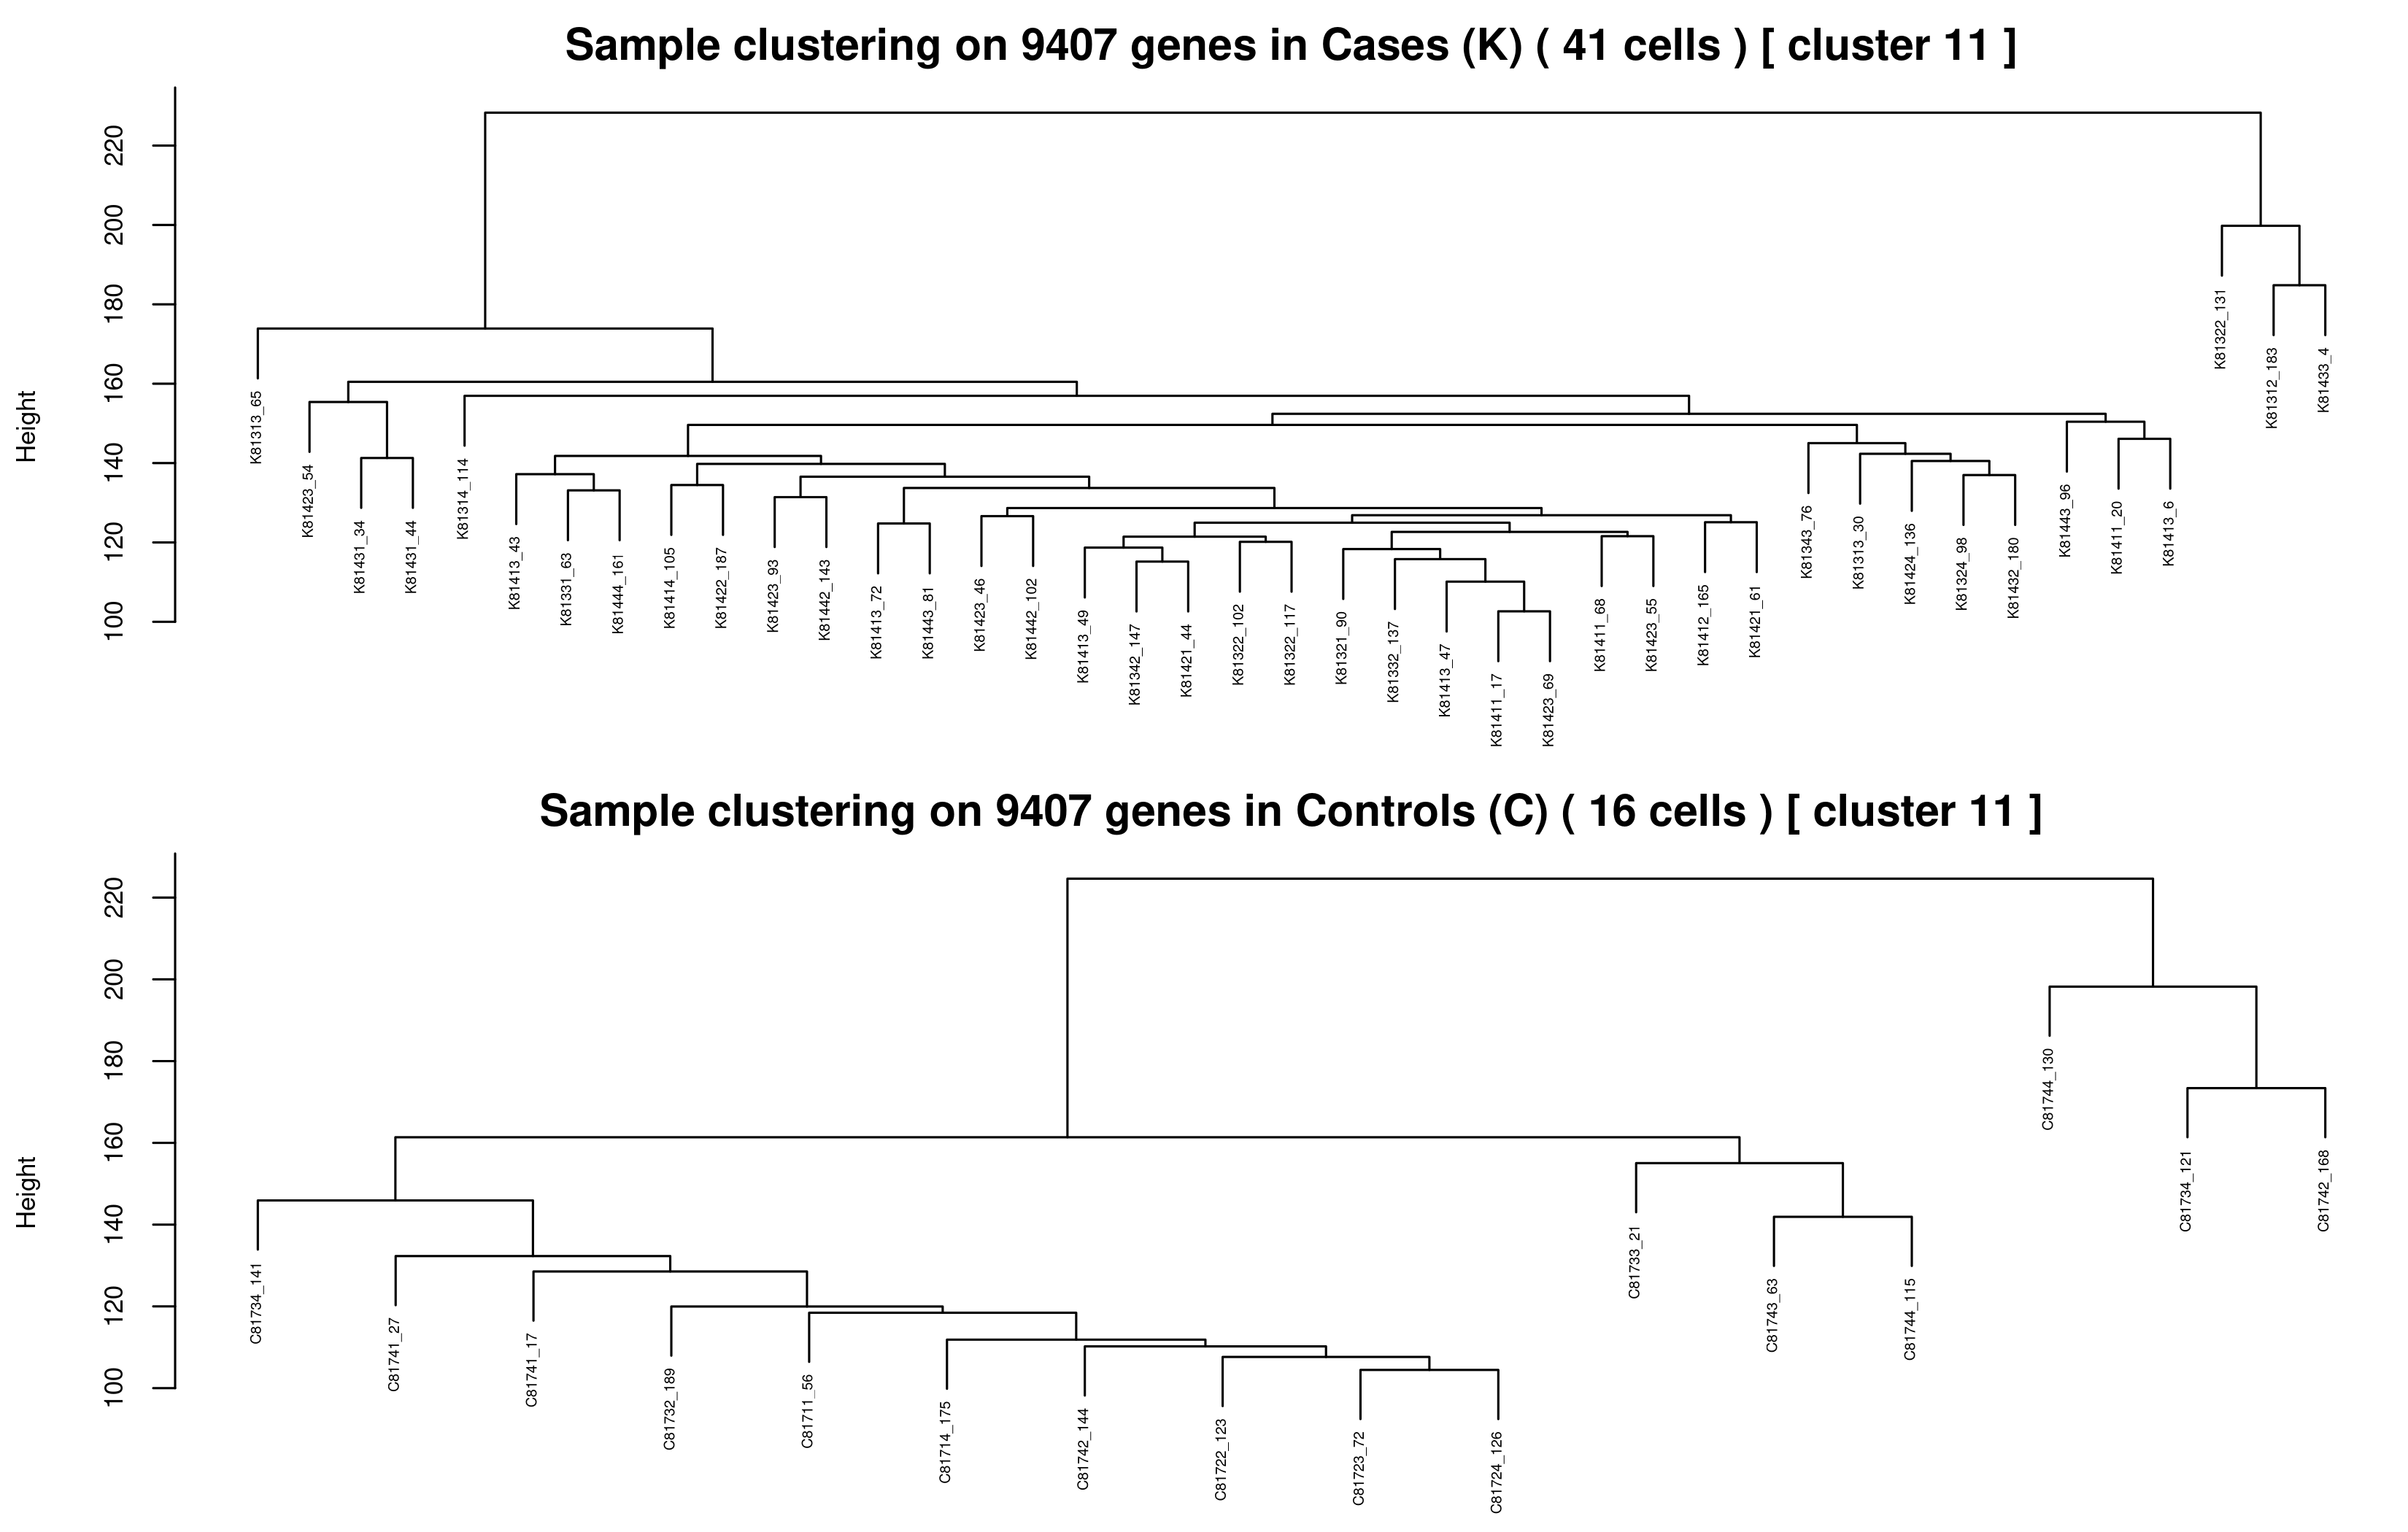

In [140]:
processClust(sc, cln=11)

outliers: 3 in cases (far right)

Cluster 12



[1] "Controls= 36  Cases= 124  (+added)  160  expected= 160"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 124 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 36 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 12081 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 12081, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 12081, bad sample counts: 0, 0
Removing genes: 12081
[1] "[Cleaned] nSets= 2 nGenes= 11693 nSamples= 124 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 11693 nSamples= 36 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


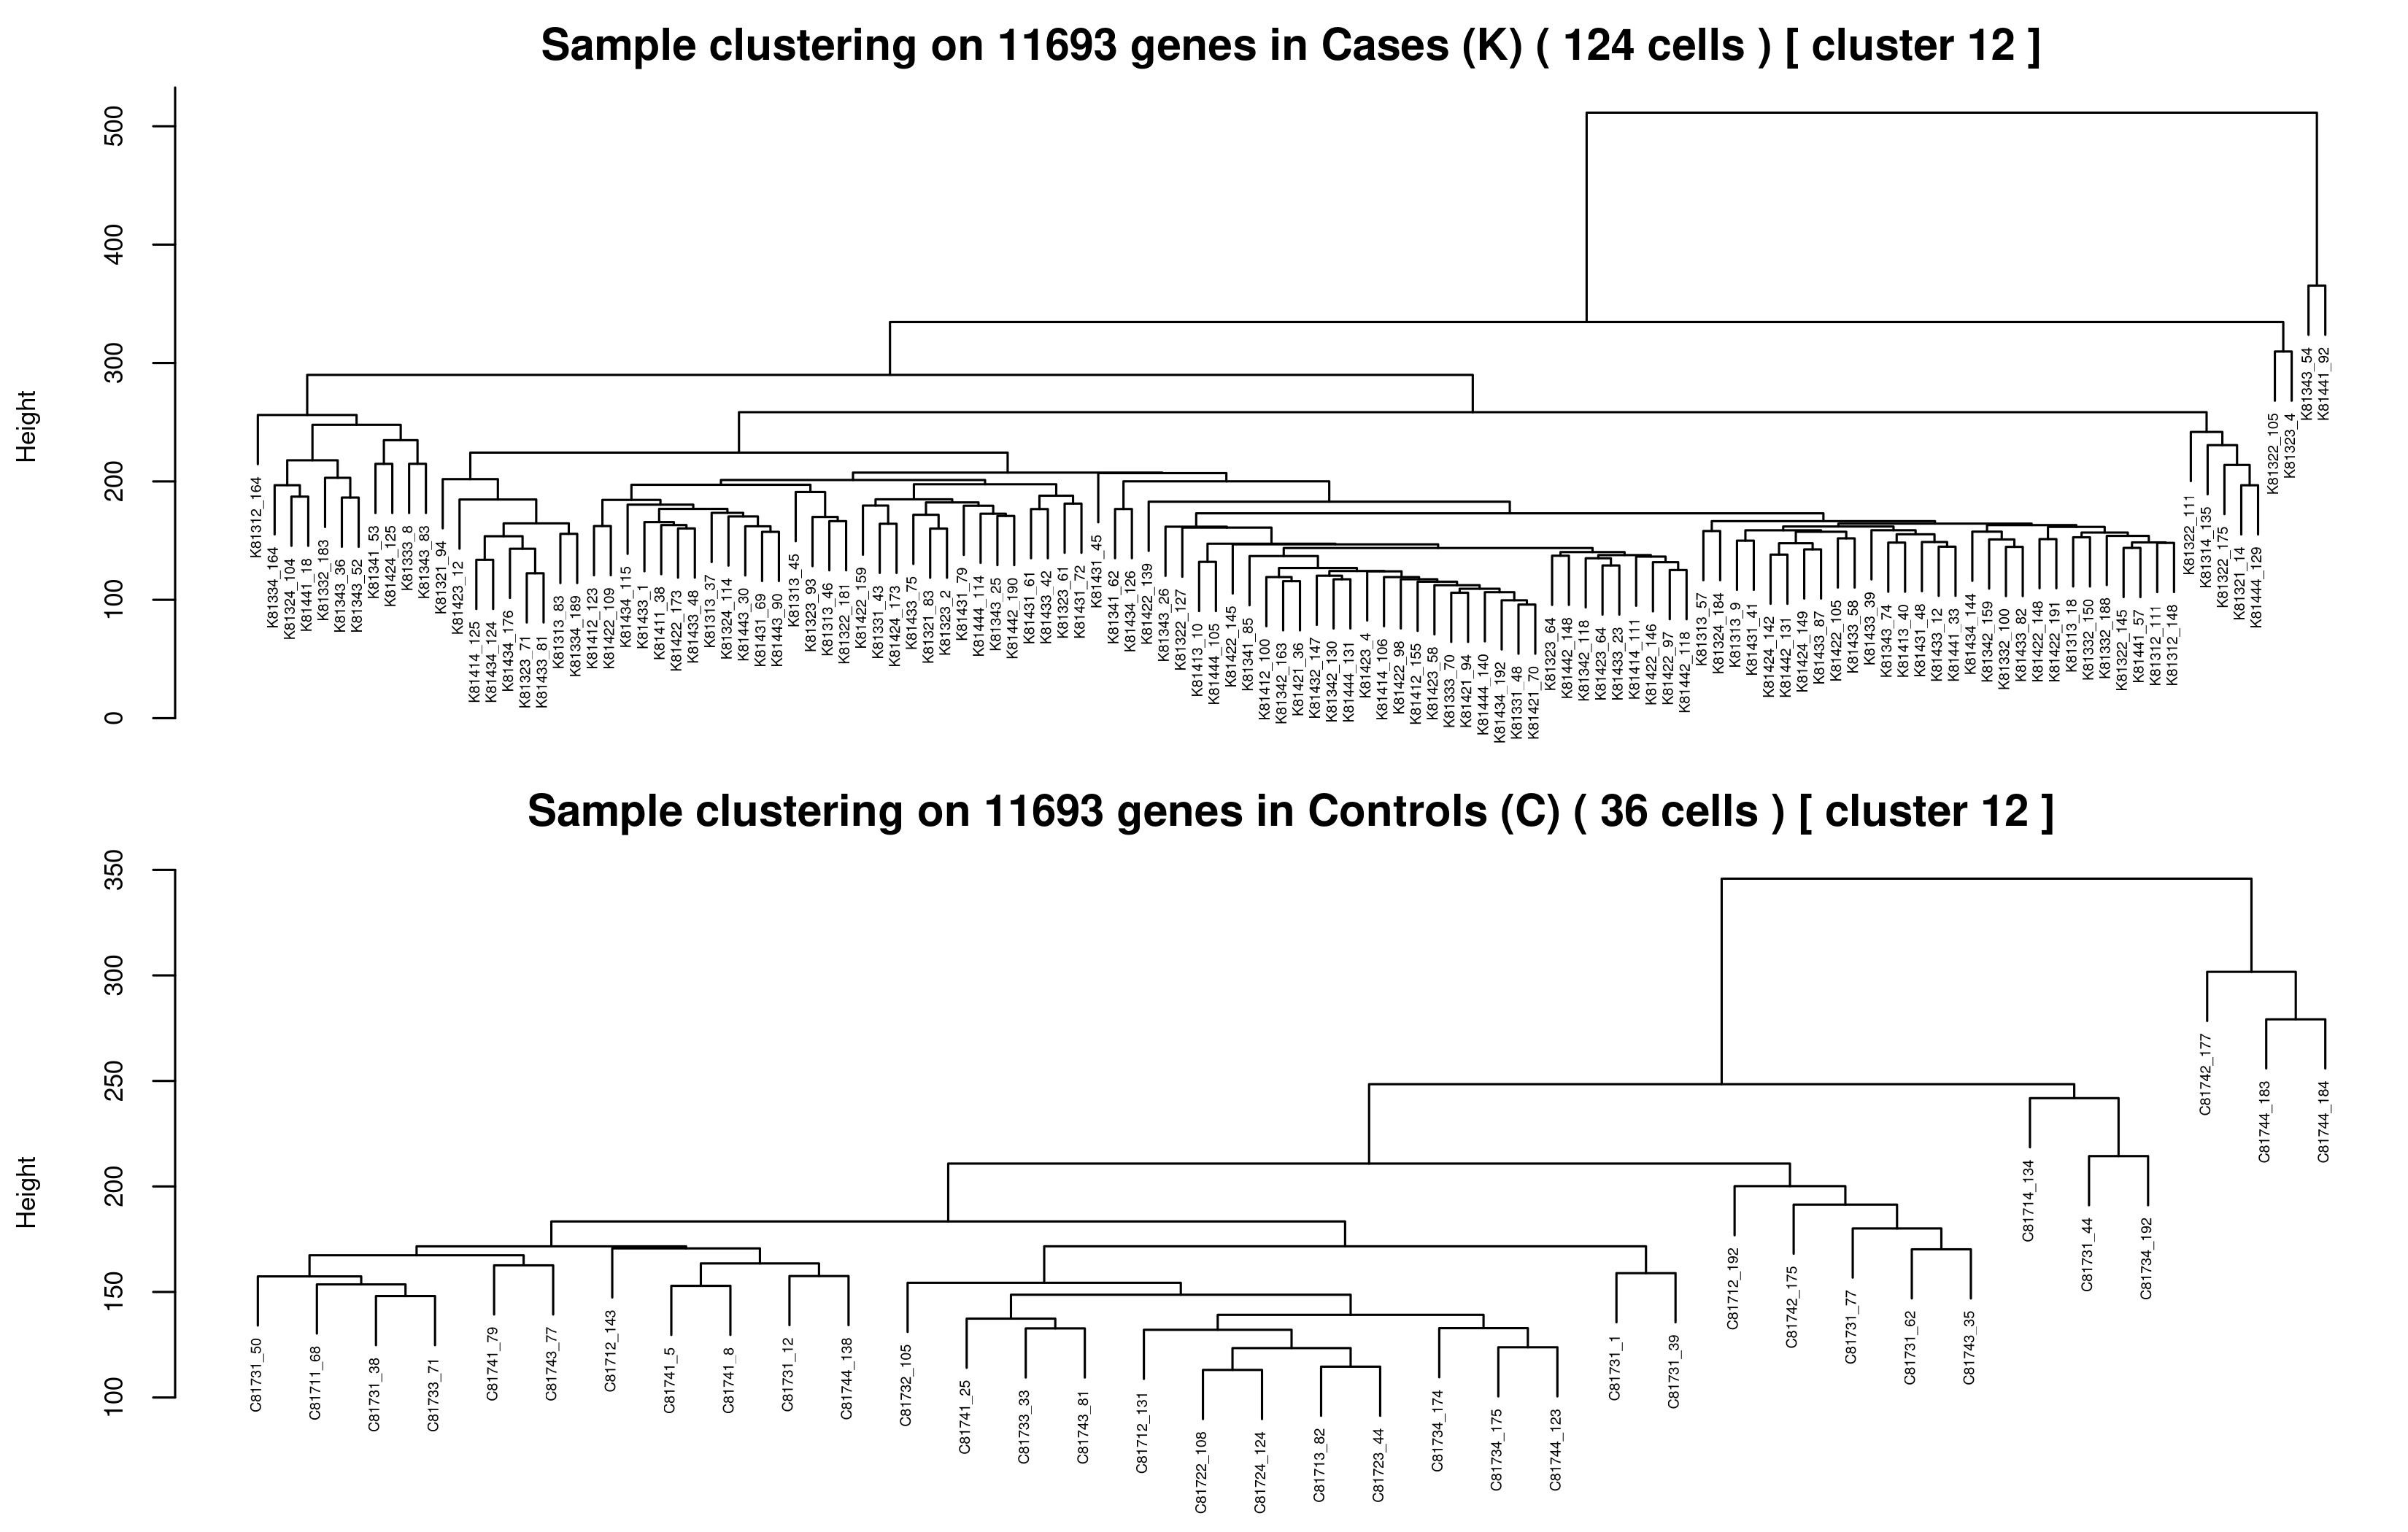

In [141]:
processClust(sc, cln=12)

outliers: possibly 2 in cases, not clear

Cluster 13



[1] "Controls= 28  Cases= 216  (+added)  244  expected= 244"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 216 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 28 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 12257 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 12257, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 12257, bad sample counts: 0, 0
Removing genes: 12257
[1] "[Cleaned] nSets= 2 nGenes= 11517 nSamples= 216 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 11517 nSamples= 28 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


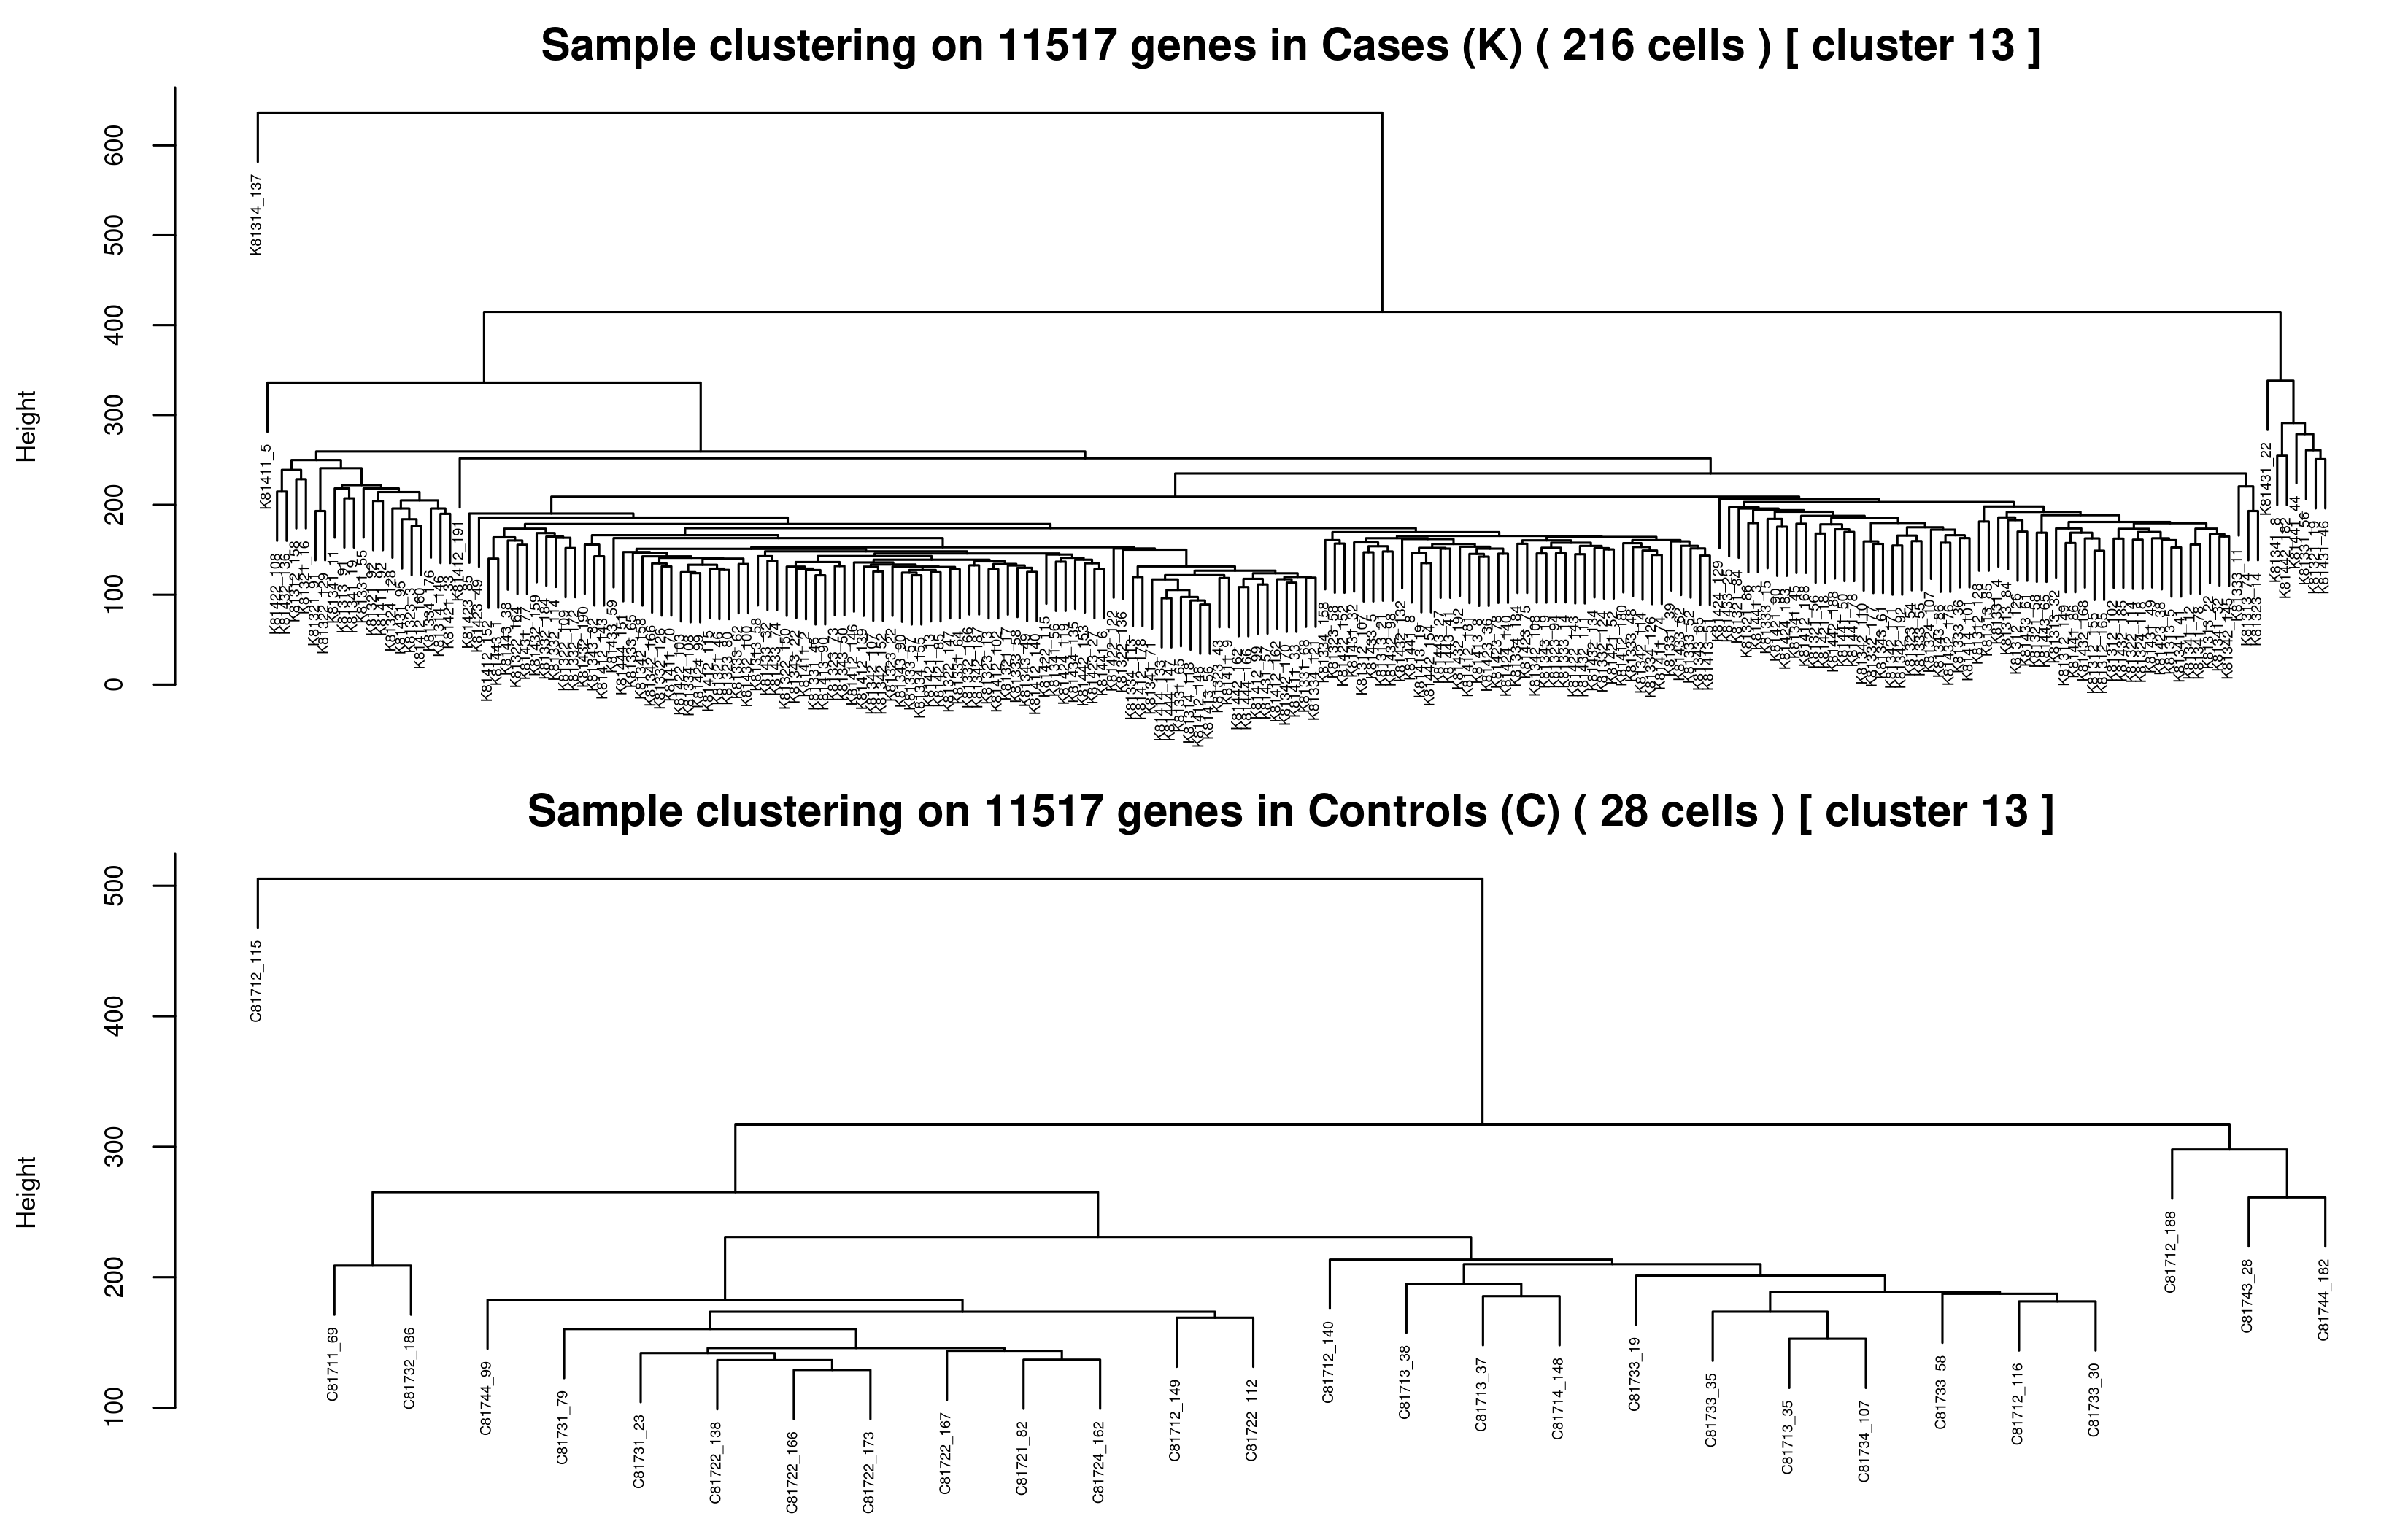

In [142]:
processClust(sc, cln=13)

outliers: 1 in cases and 1 in controls

Cluster 14



[1] "Controls= 96  Cases= 423  (+added)  519  expected= 519"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 423 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 96 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 11765 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 11765, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 11765, bad sample counts: 0, 0
Removing genes: 11765
[1] "[Cleaned] nSets= 2 nGenes= 12009 nSamples= 423 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 12009 nSamples= 96 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


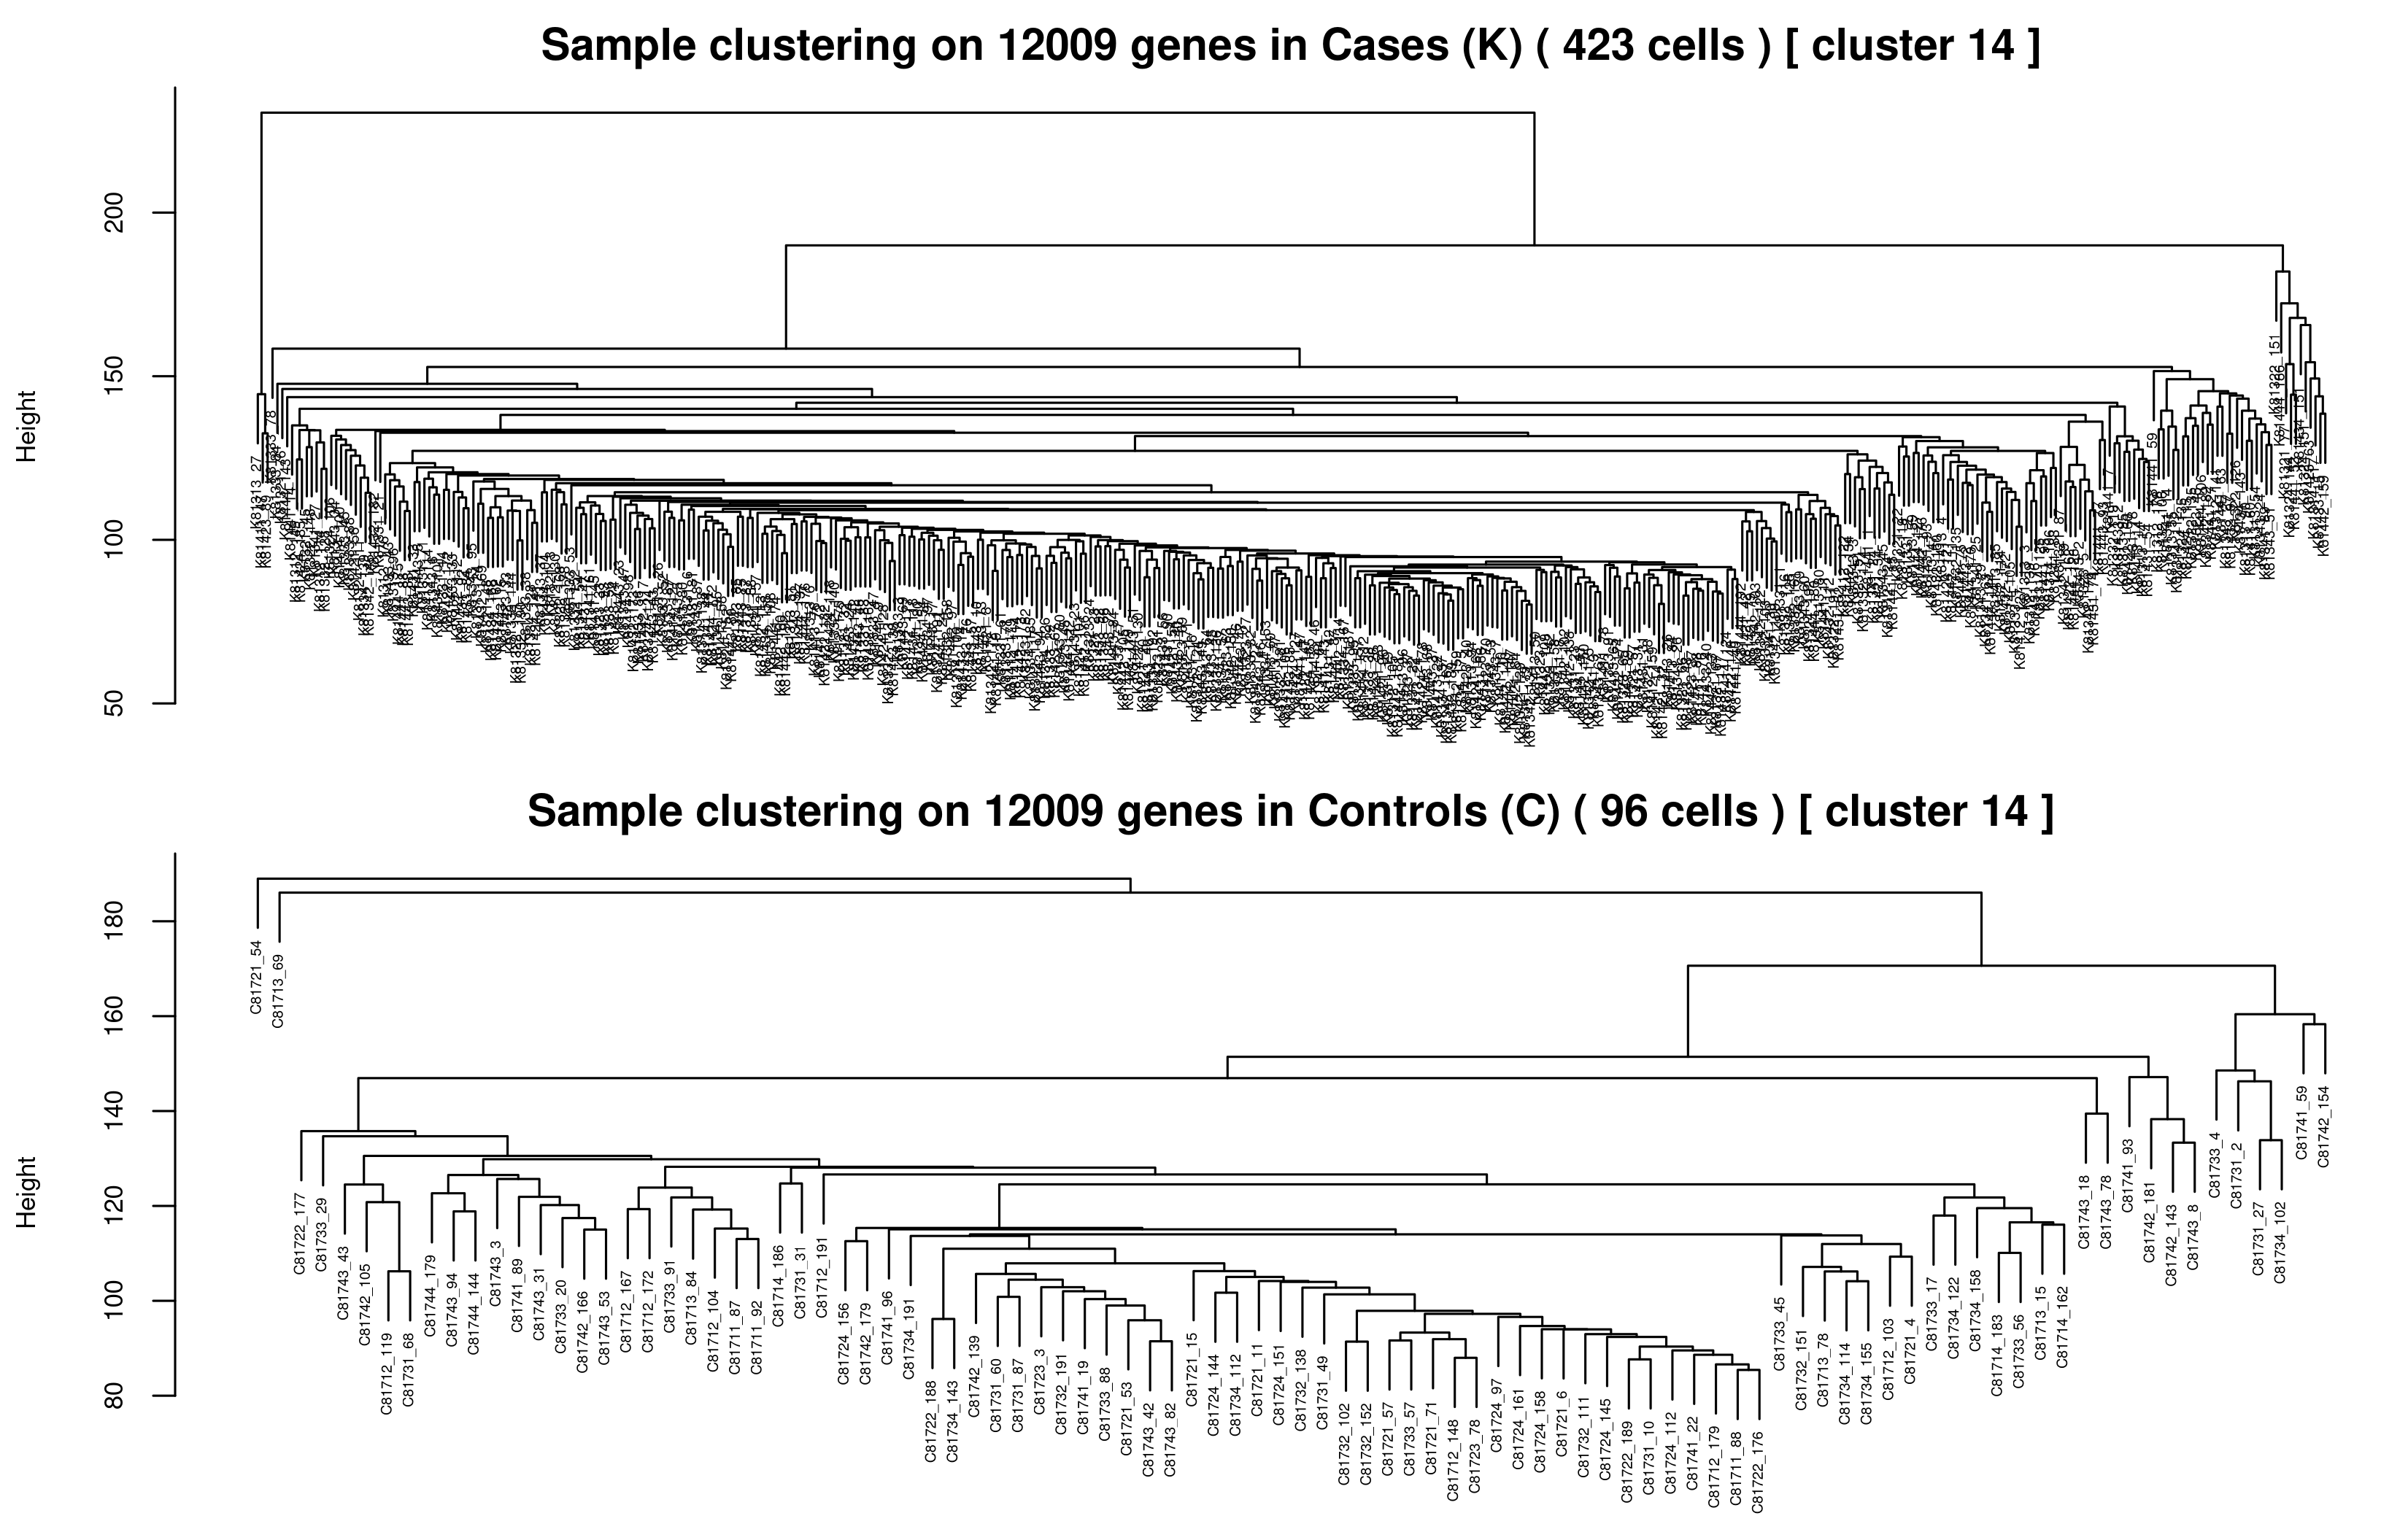

In [143]:
processClust(sc, cln=14)

outliers: 2 in controls

Cluster 15



[1] "Controls= 7  Cases= 9  (+added)  16  expected= 16"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 9 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 7 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 22839 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 22839, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 22839, bad sample counts: 0, 0
Removing genes: 22839
[1] "[Cleaned] nSets= 2 nGenes= 935 nSamples= 9 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 935 nSamples= 7 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


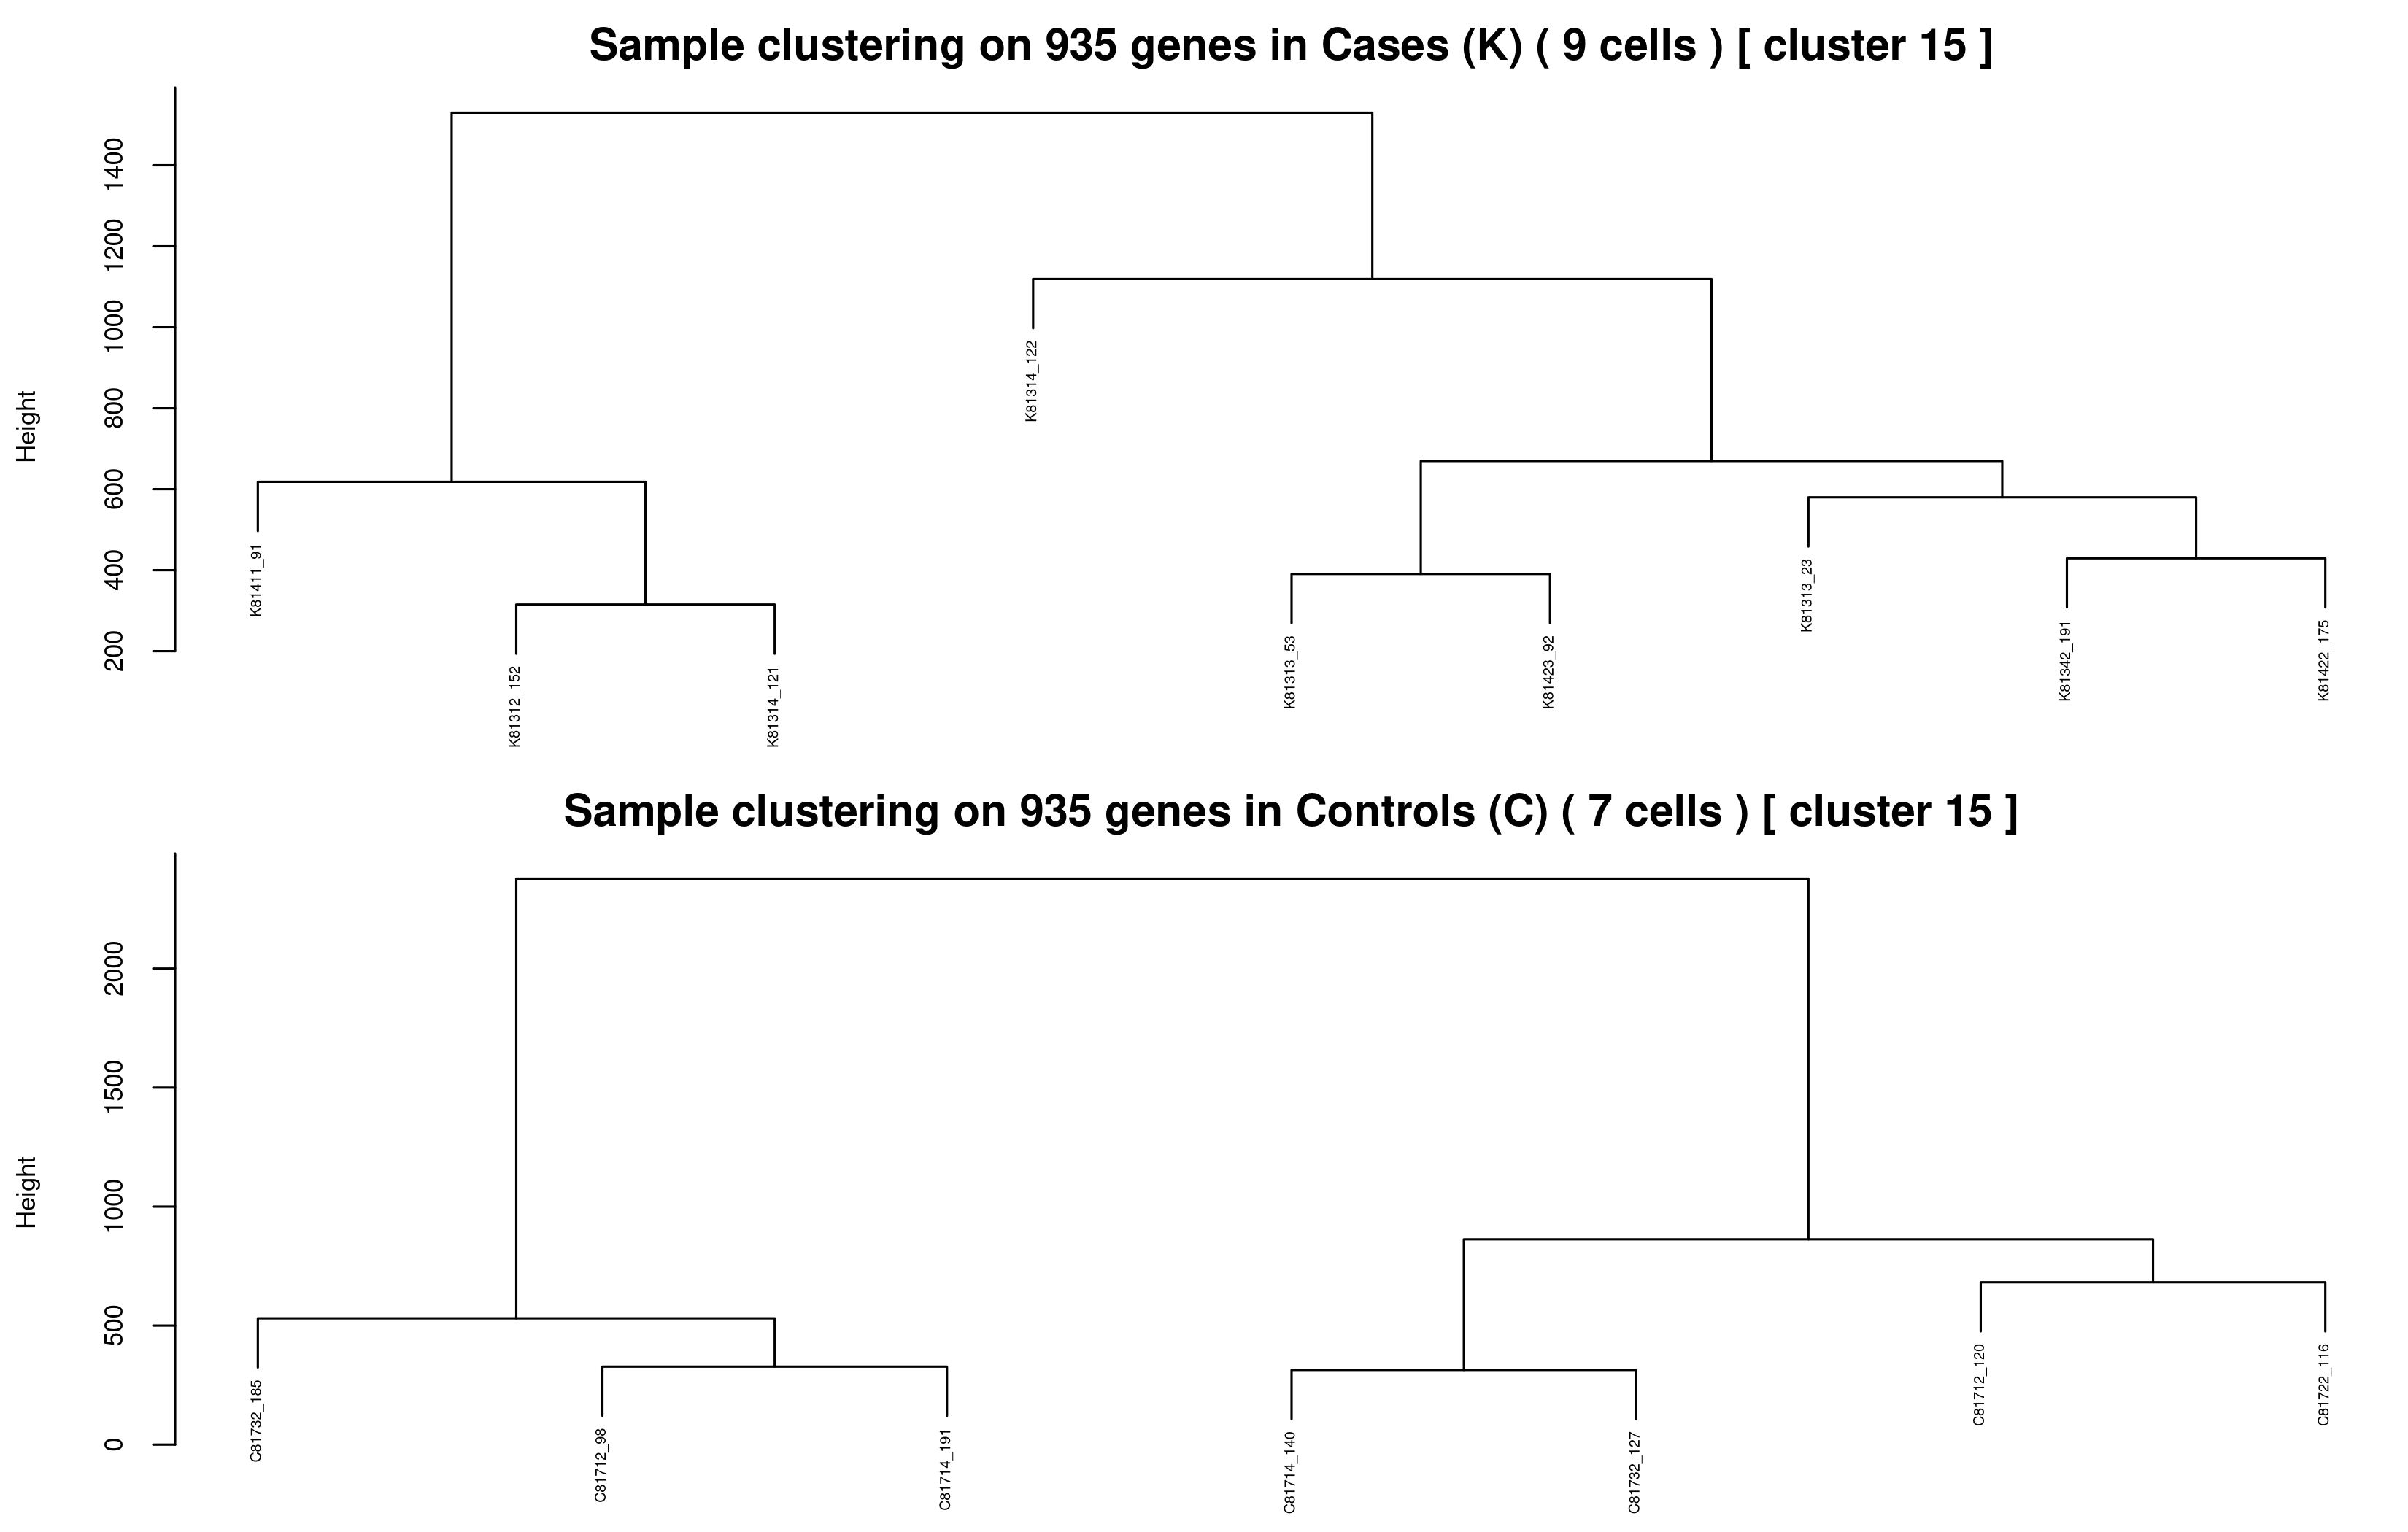

In [144]:
processClust(sc, cln=15)

outliers: none

Cluster 16



[1] "Controls= 12  Cases= 24  (+added)  36  expected= 36"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 24 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 12 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 15346 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 15346, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 15346, bad sample counts: 0, 0
Removing genes: 15346
[1] "[Cleaned] nSets= 2 nGenes= 8428 nSamples= 24 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 8428 nSamples= 12 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


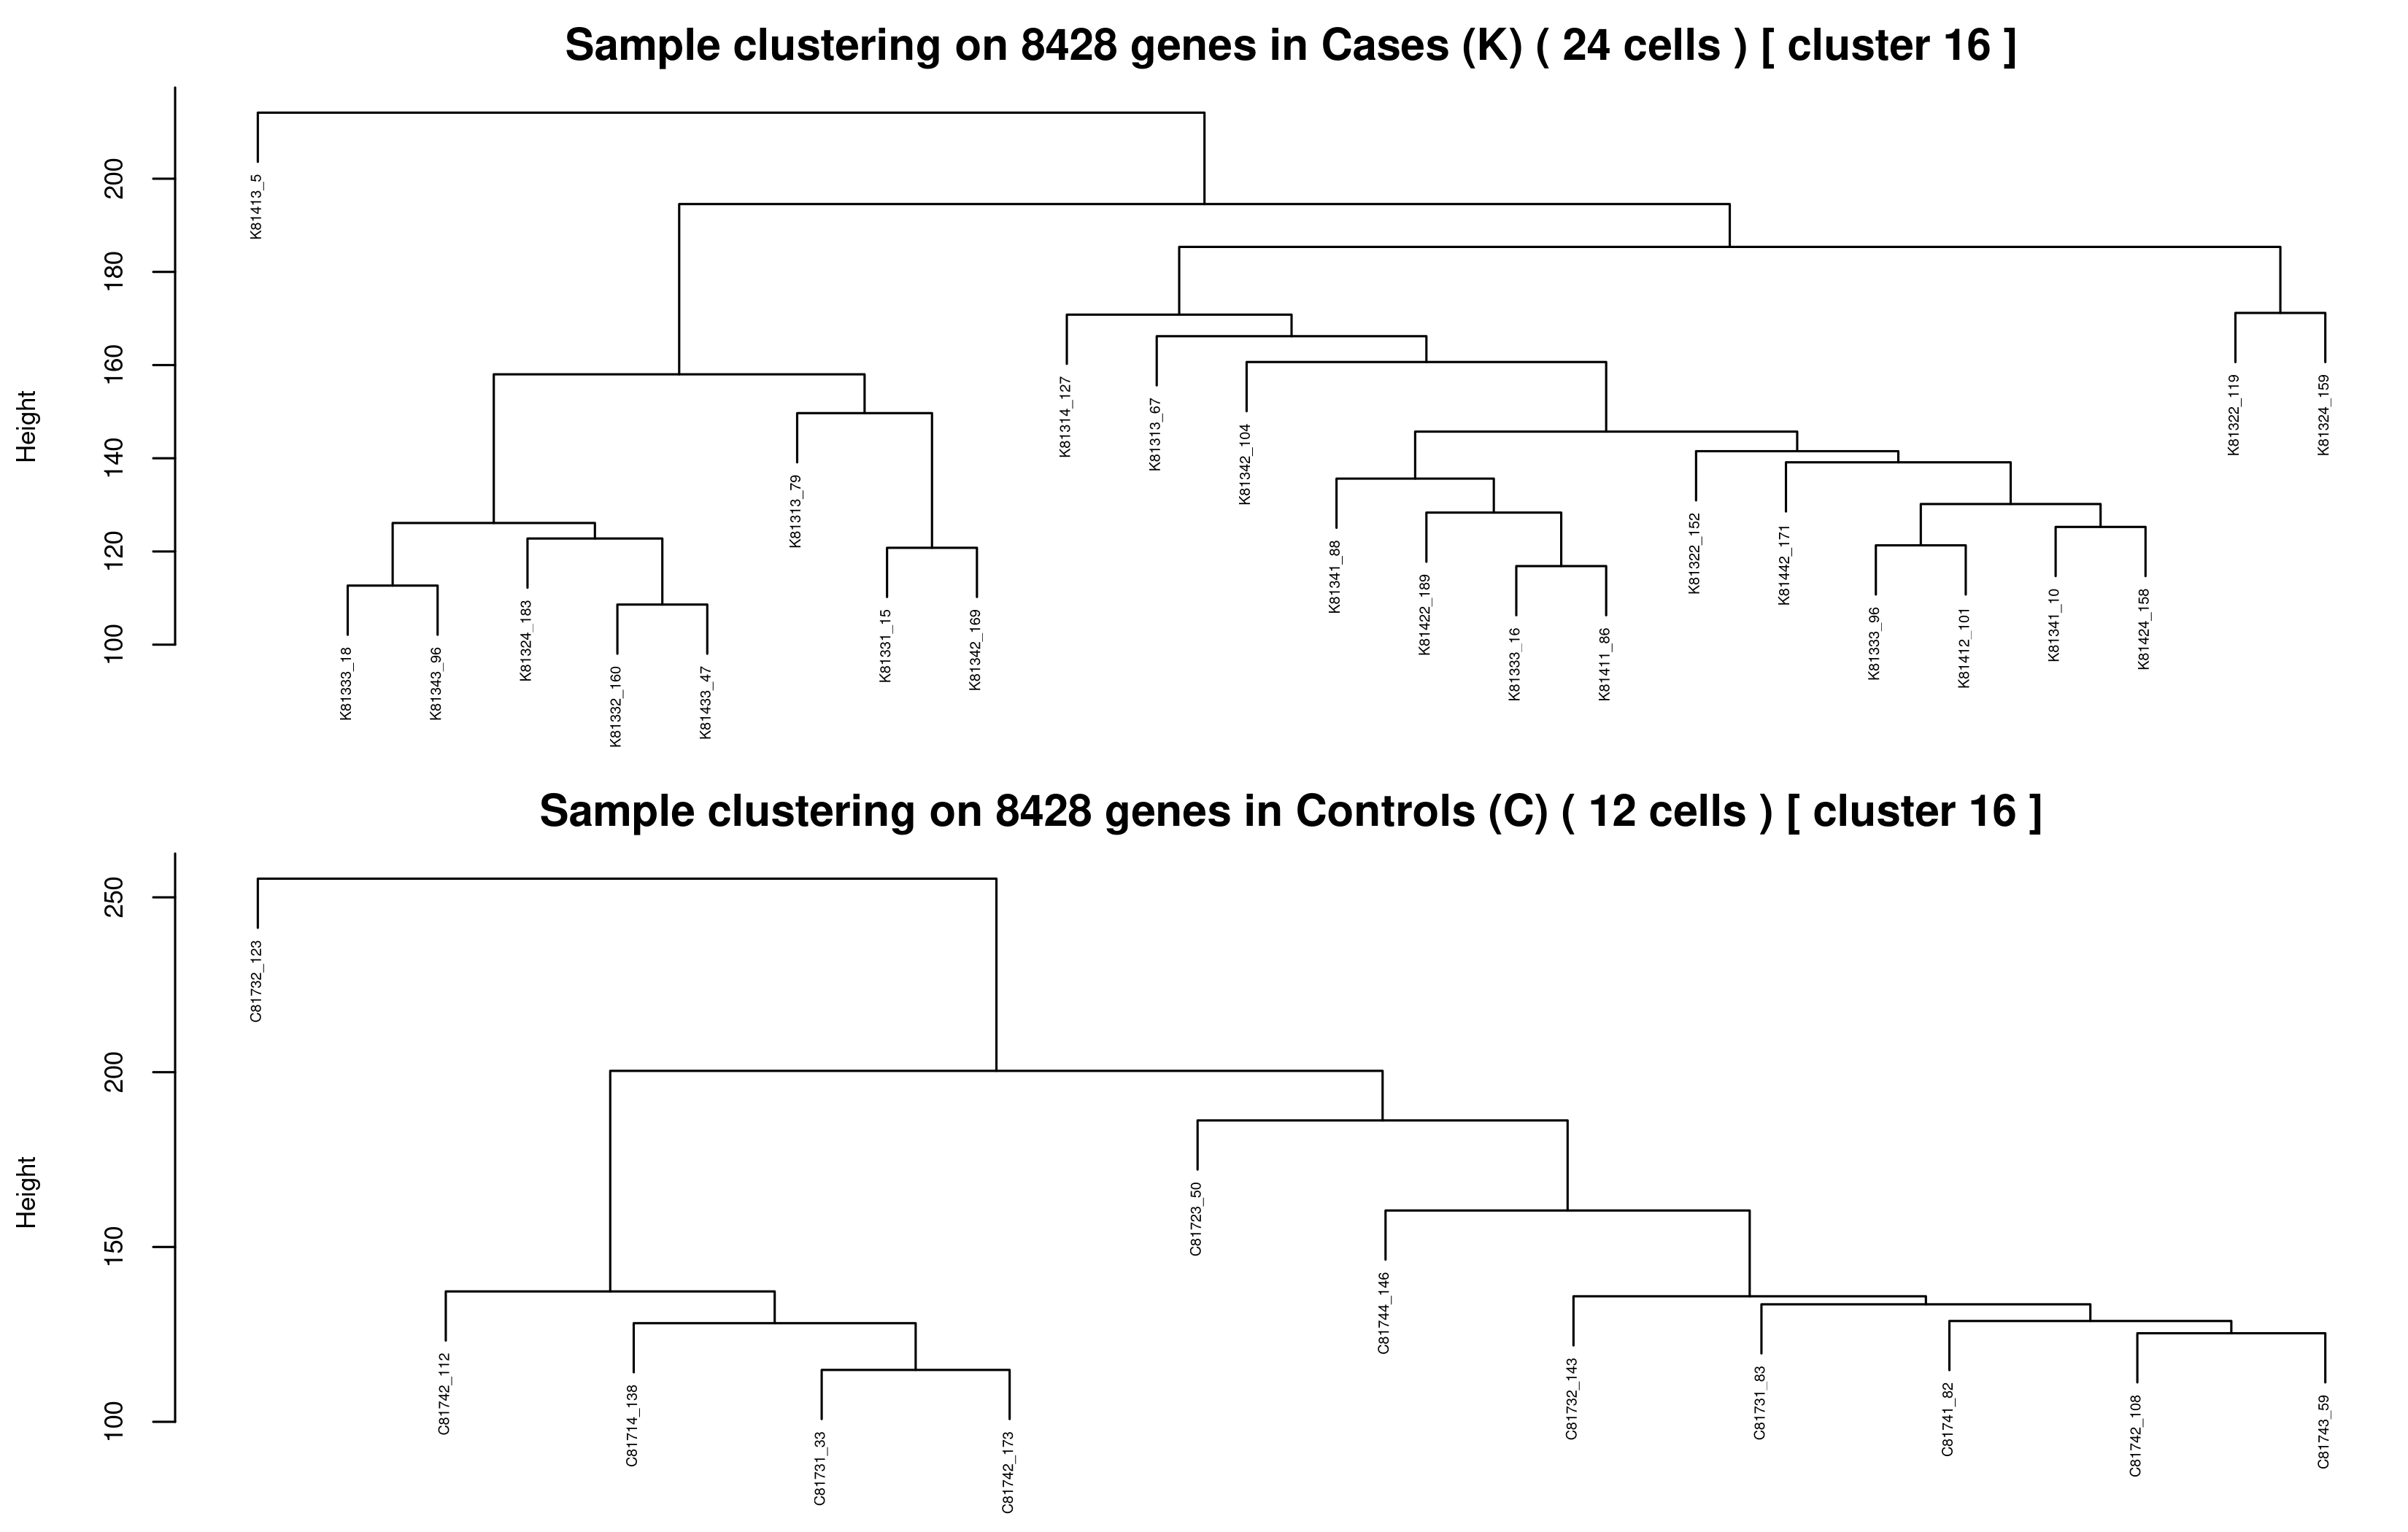

In [145]:
processClust(sc, cln=16)

outliers: possibly 1 in each

Cluster 17



[1] "Controls= 5  Cases= 59  (+added)  64  expected= 64"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 59 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 5 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 14004 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 14004, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 14004, bad sample counts: 0, 0
Removing genes: 14004
[1] "[Cleaned] nSets= 2 nGenes= 9770 nSamples= 59 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 9770 nSamples= 5 structureOK= TRUE" 
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


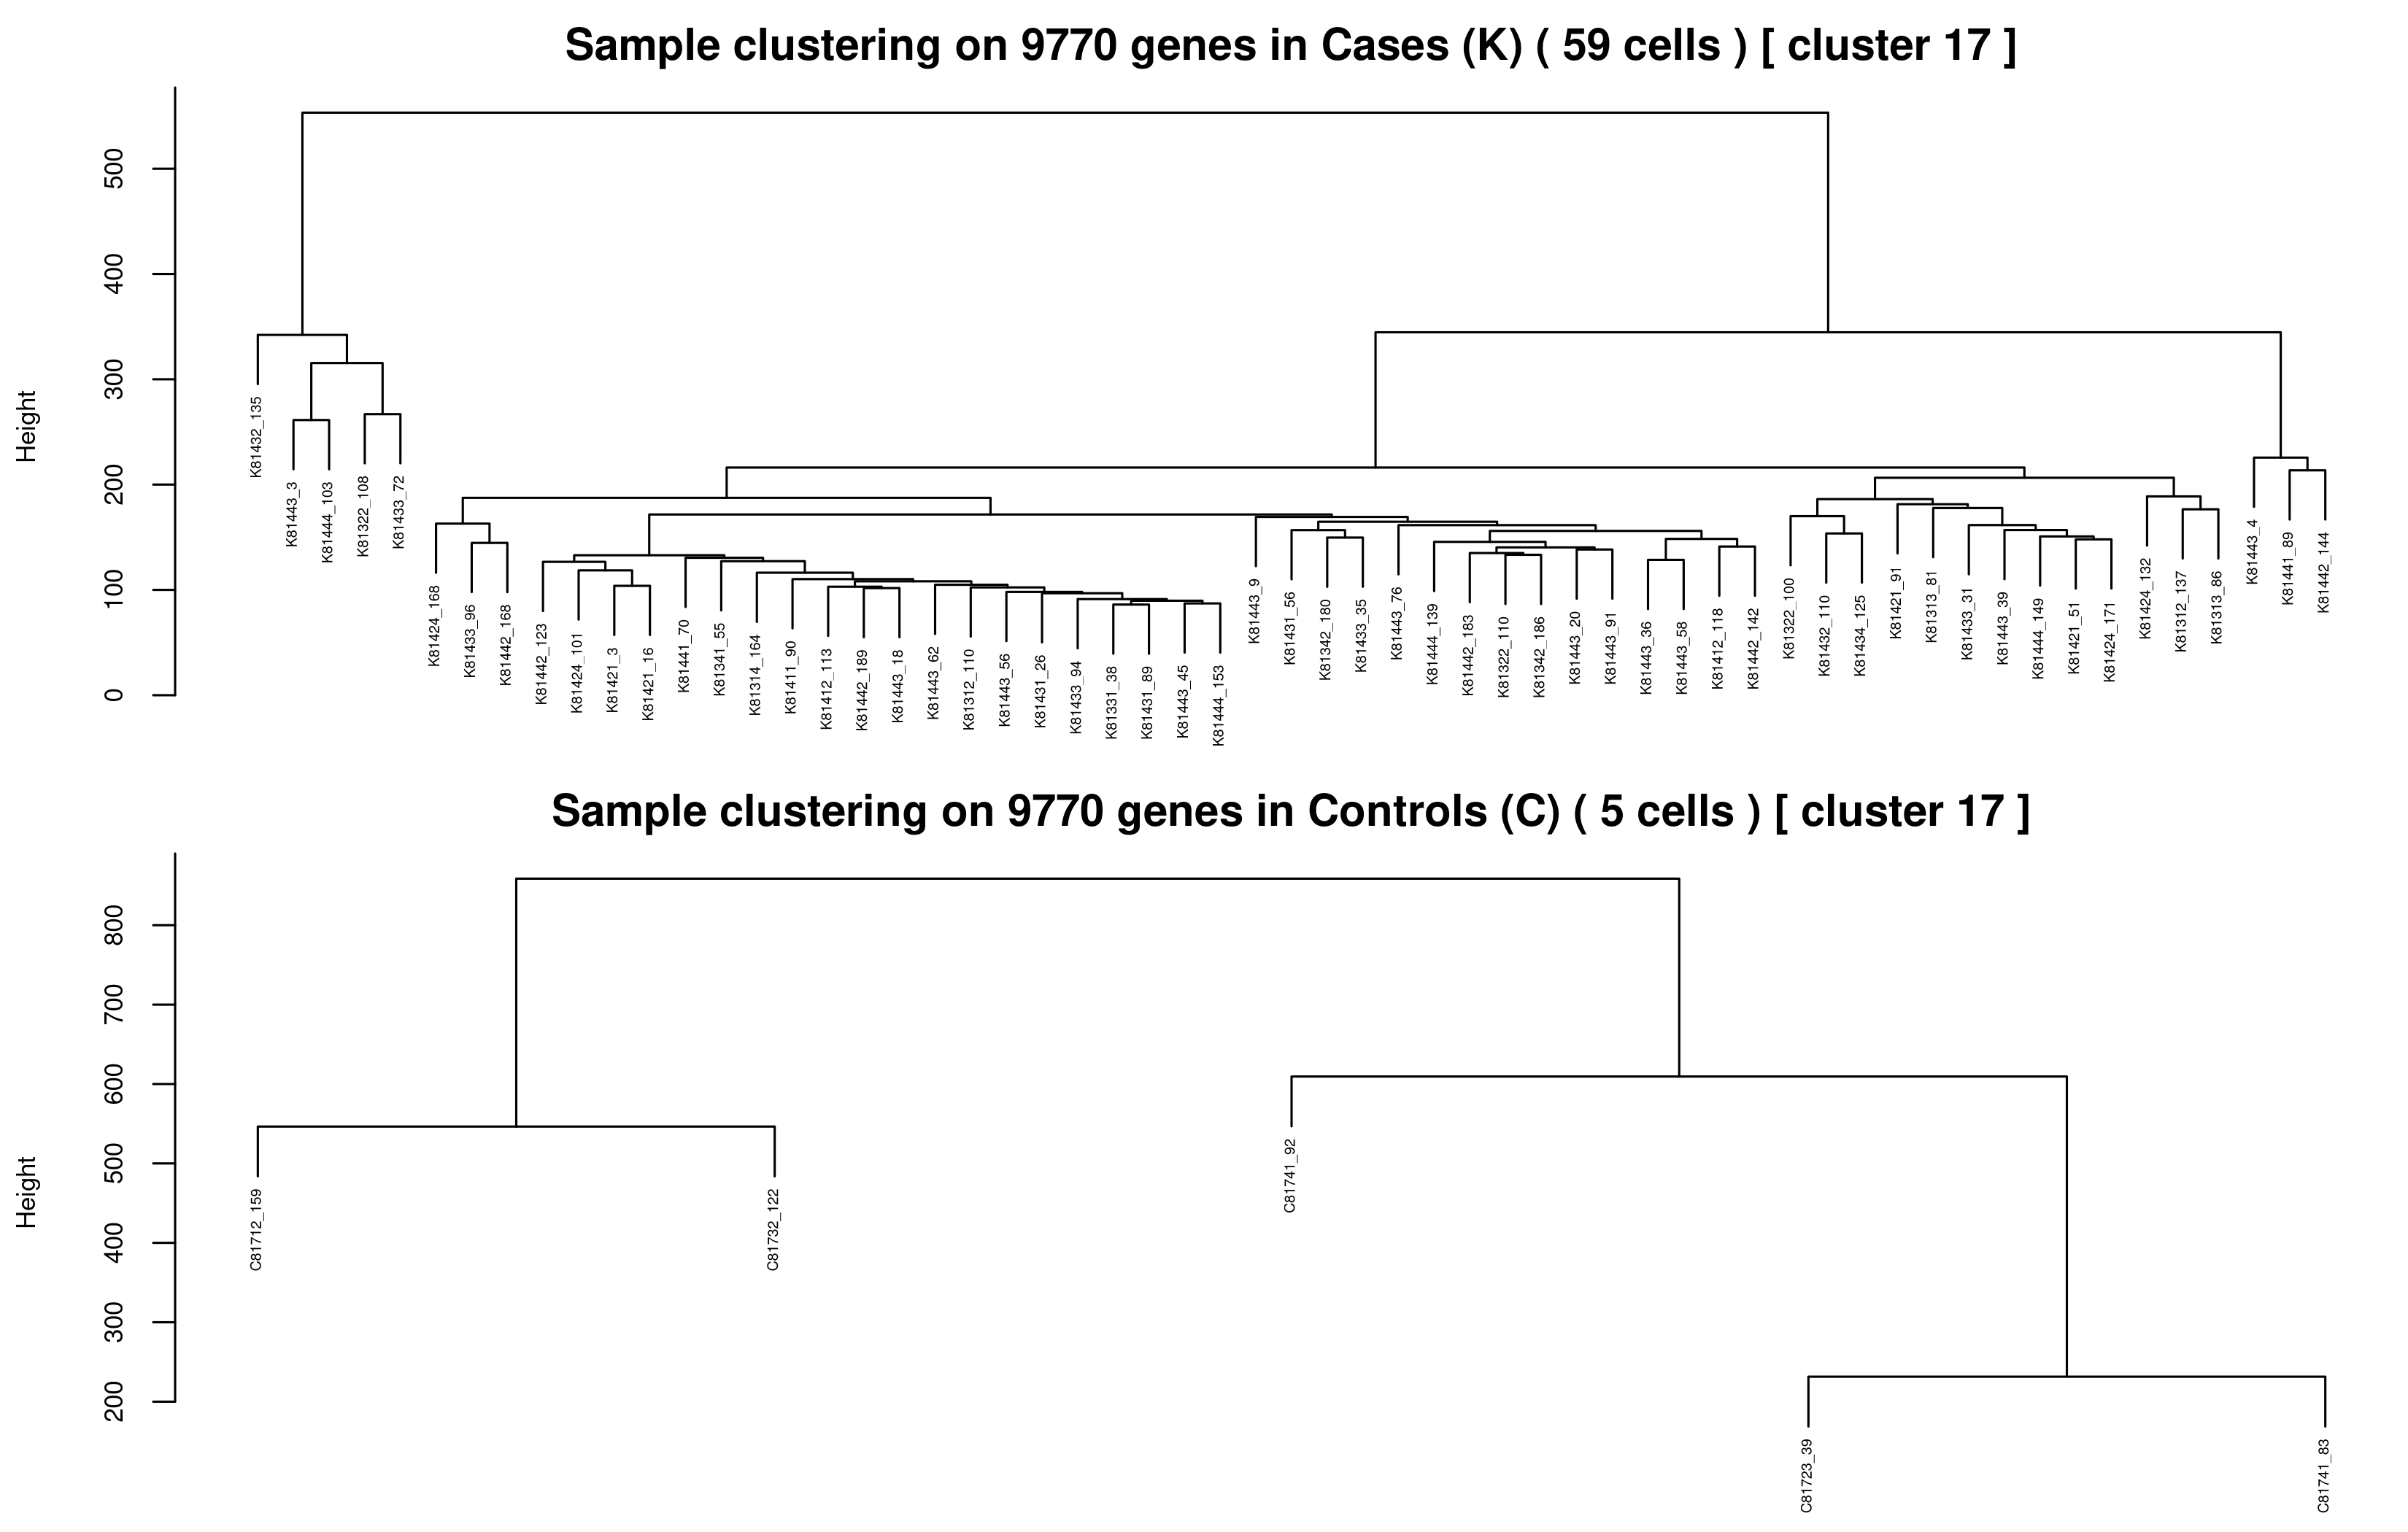

In [146]:
processClust(sc, cln=17)

outliers: none

Cluster 18



[1] "Controls= 12  Cases= 32  (+added)  44  expected= 44"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 32 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 12 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 14270 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 14270, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 14270, bad sample counts: 0, 0
Removing genes: 14270
[1] "[Cleaned] nSets= 2 nGenes= 9504 nSamples= 32 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 9504 nSamples= 12 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


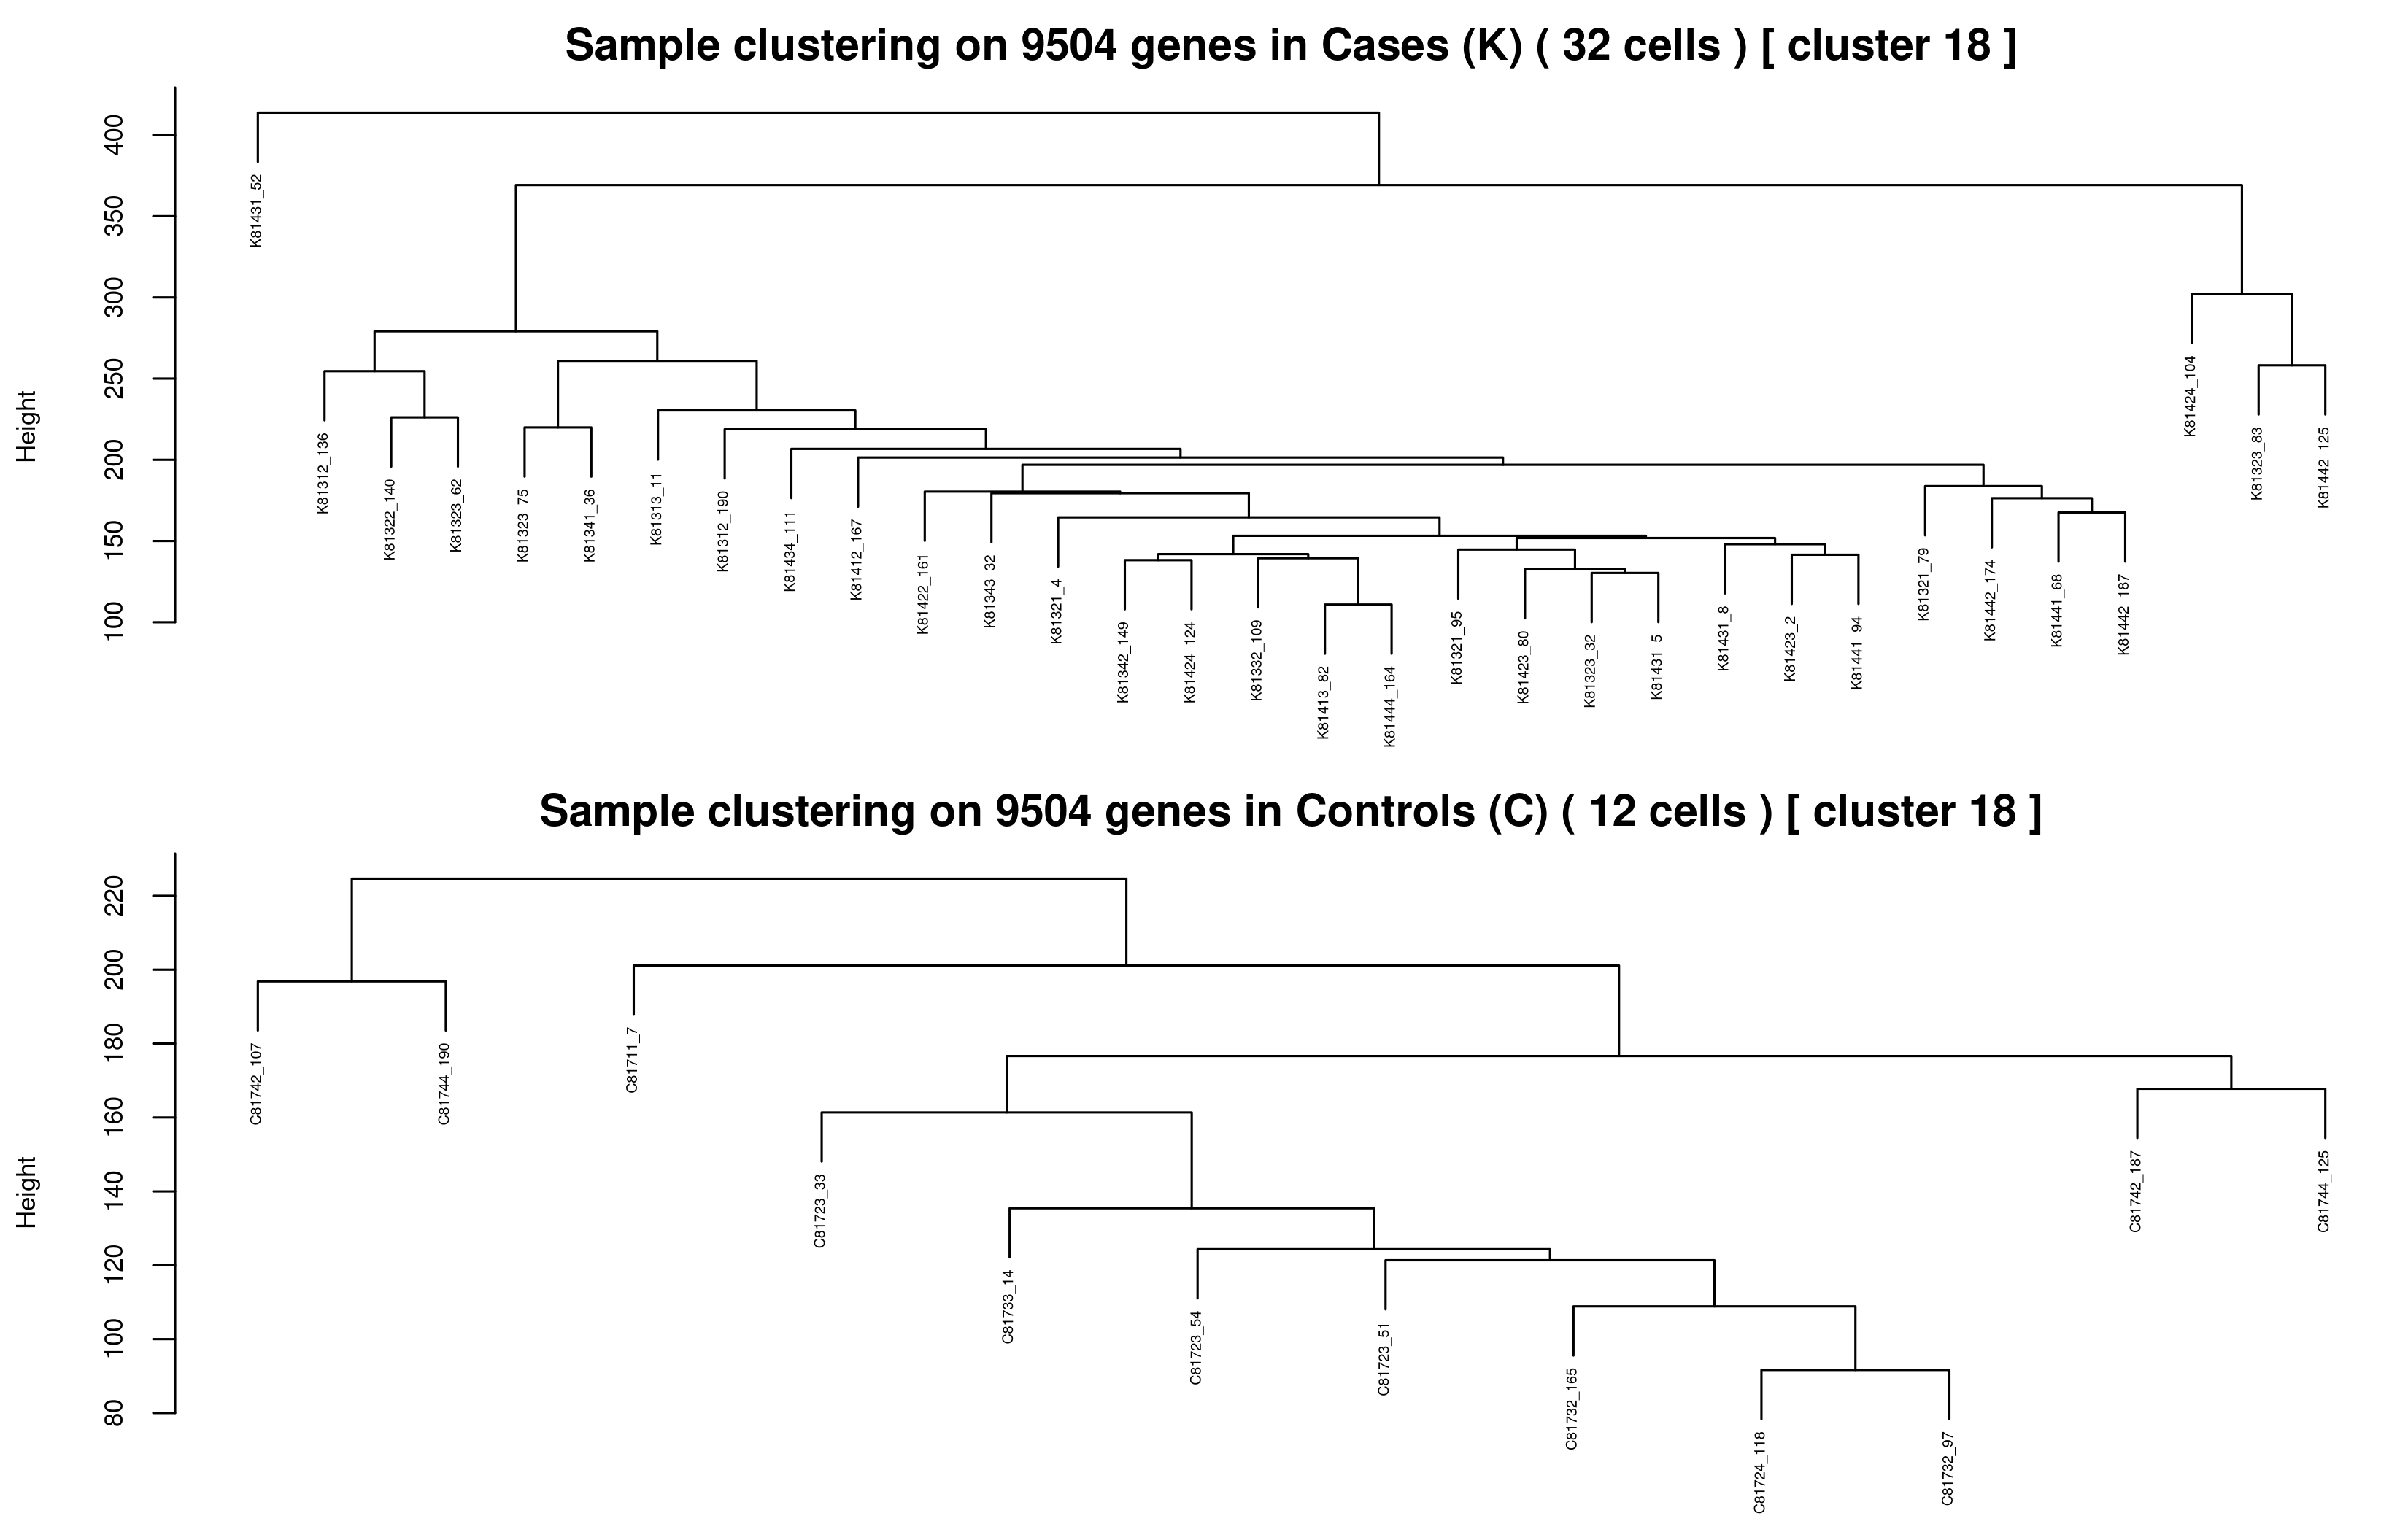

In [147]:
processClust(sc, cln=18)

outliers: 1 in cases

In [150]:
##processClust(sc, cln=19)

cluster 19 had only 5 cells, so it crashed...

Cluster 20



[1] "Controls= 4  Cases= 5  (+added)  9  expected= 9"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 5 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 4 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 18480 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 18480, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 18480, bad sample counts: 0, 0
Removing genes: 18480
[1] "[Cleaned] nSets= 2 nGenes= 5294 nSamples= 5 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 5294 nSamples= 4 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


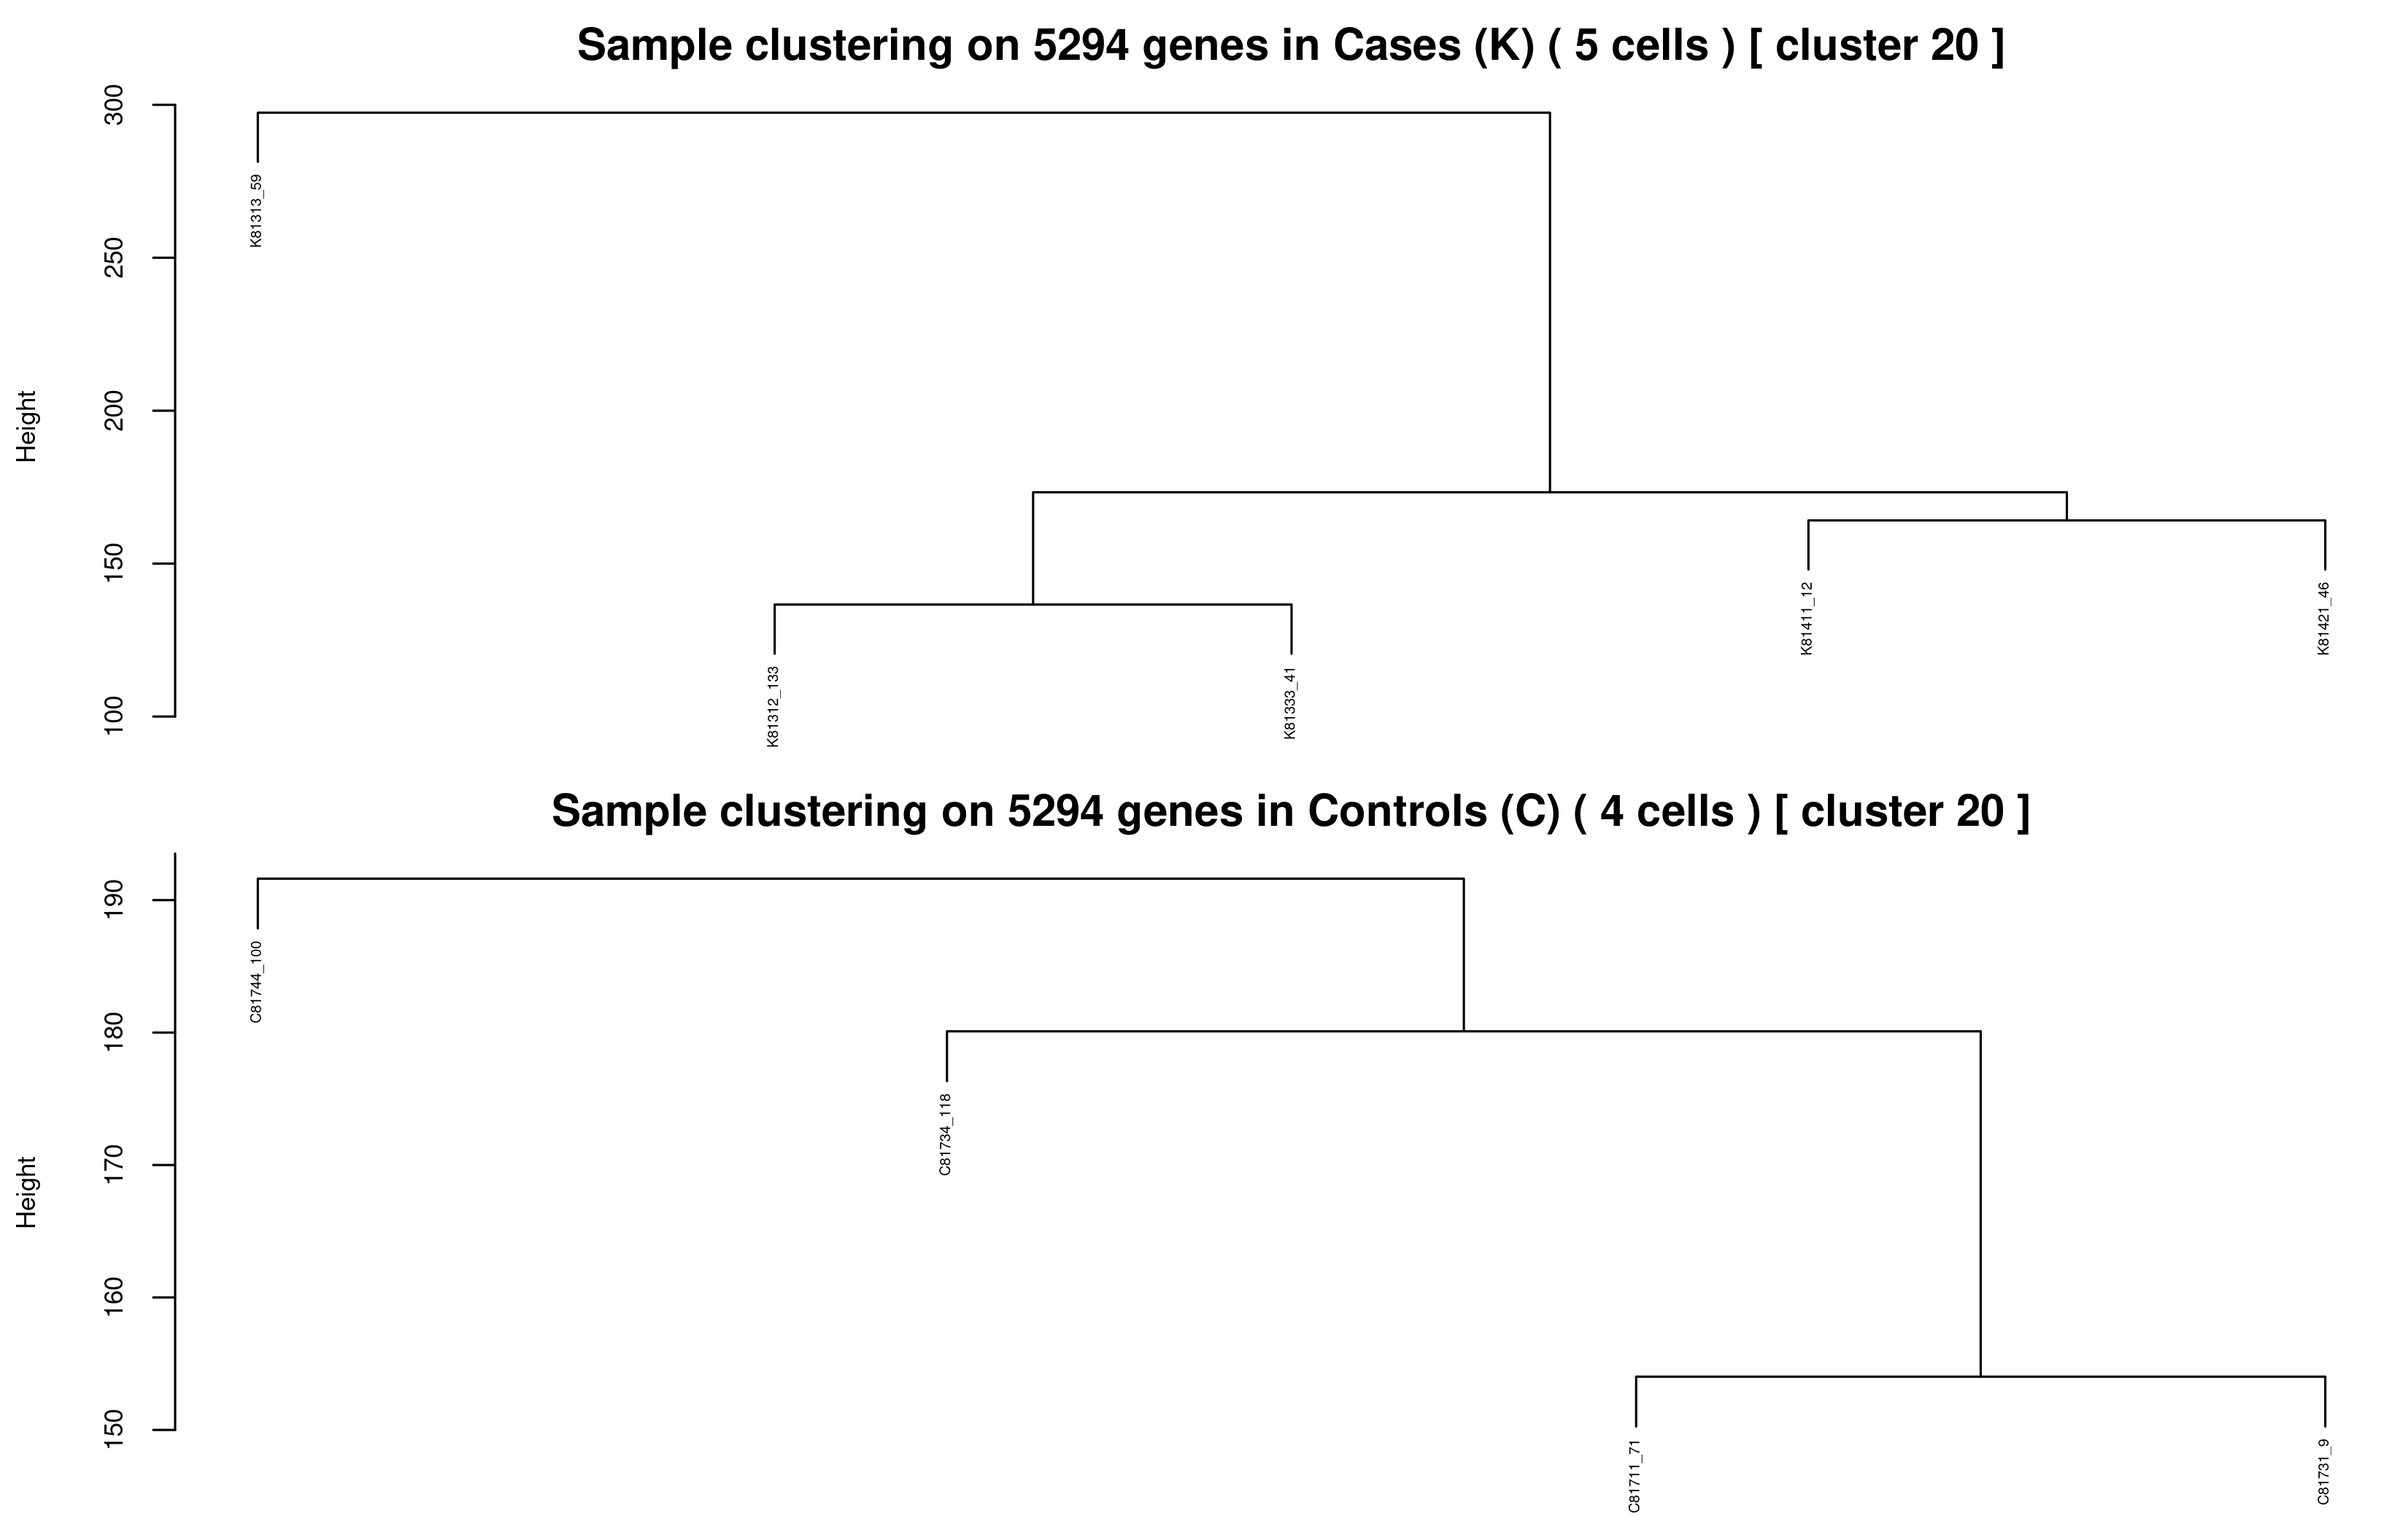

In [151]:
processClust(sc, cln=20)

outliers: I mean....

In [154]:
##processClust(sc, cln=21)

Cluster 21 had only 10 cells, crashed...

In [156]:
##processClust(sc, cln=22)

Cluster 22 had 0 cells...

Cluster 23



[1] "Controls= 24  Cases= 37  (+added)  61  expected= 61"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 37 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 24 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 13803 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 13803, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 13803, bad sample counts: 0, 0
Removing genes: 13803
[1] "[Cleaned] nSets= 2 nGenes= 9971 nSamples= 37 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 9971 nSamples= 24 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


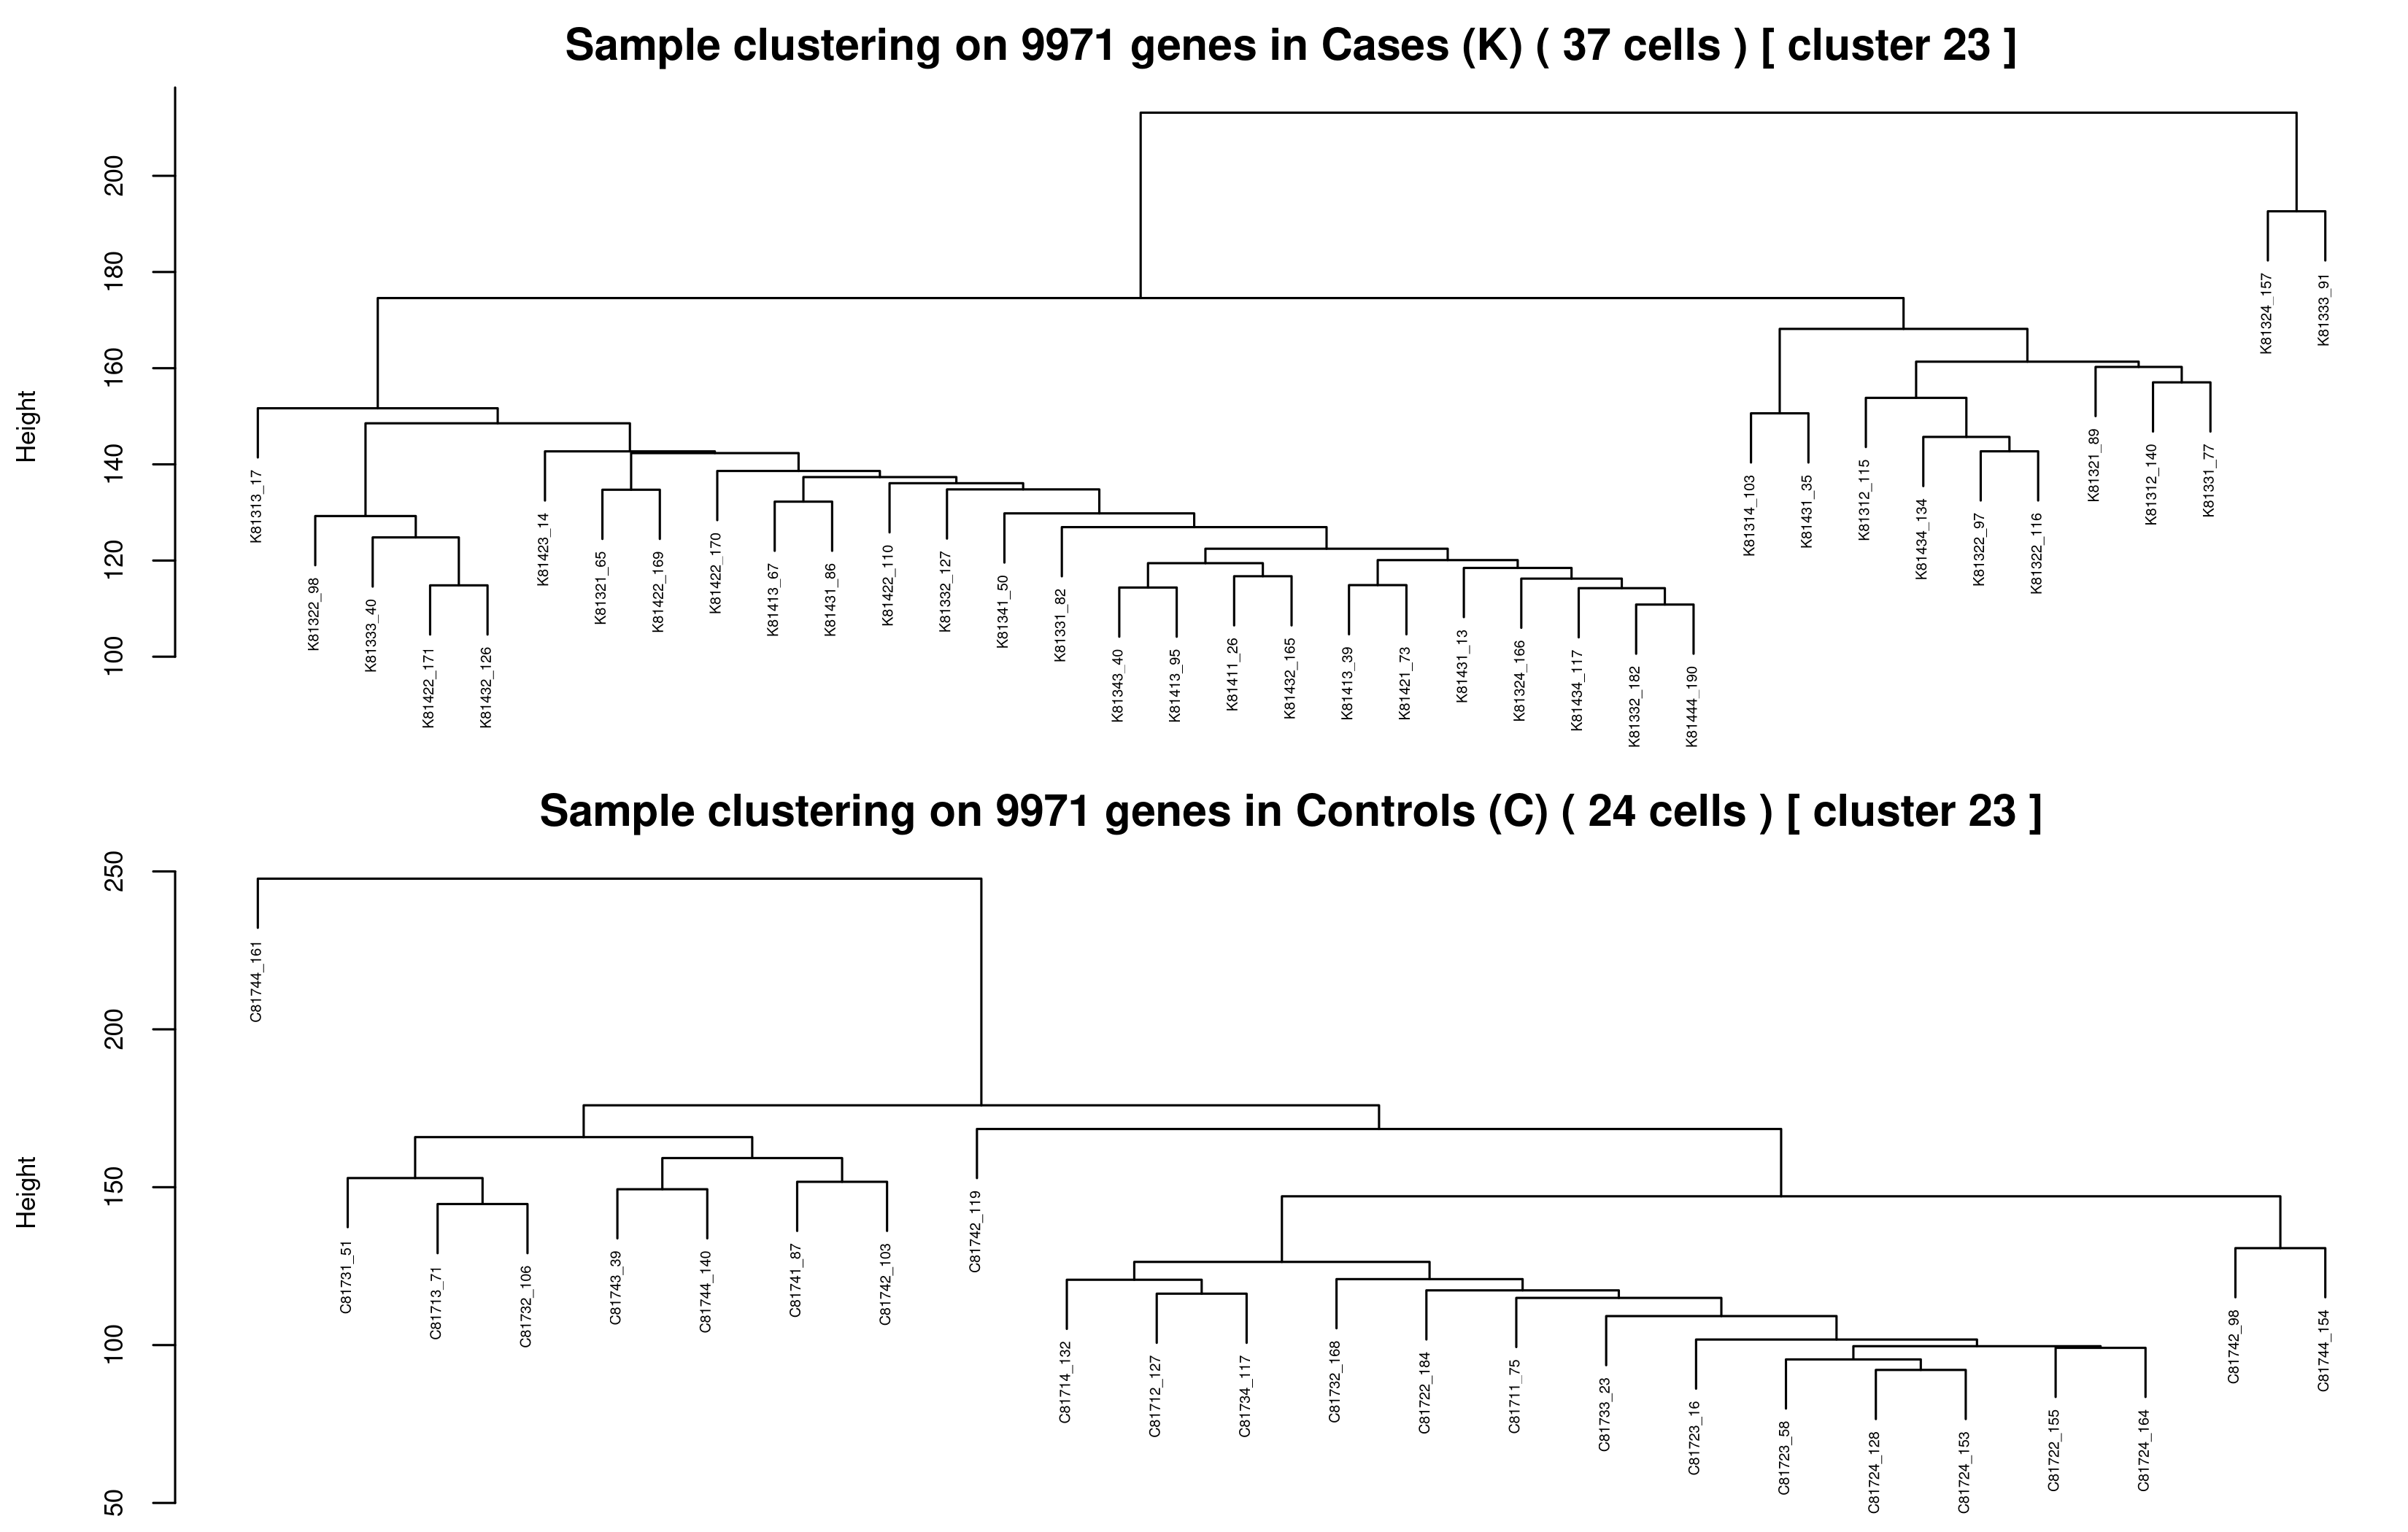

In [157]:
processClust(sc, cln=23)

outliers: 1 in controls

In [159]:
##processClust(sc, cln=24)

Cluster 24 has only 2 cells...

Cluster 25



[1] "Controls= 13  Cases= 15  (+added)  28  expected= 28"
[1] "[Initial] nSets= 2 nGenes= 23774 nSamples= 15 structureOK= TRUE"
[2] "[Initial] nSets= 2 nGenes= 23774 nSamples= 13 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 15277 genes from the calculation due to too many missing samples or zero variance.
   ..bad gene count: 15277, bad sample counts: 0, 0
  ..step 2
   ..bad gene count: 15277, bad sample counts: 0, 0
Removing genes: 15277
[1] "[Cleaned] nSets= 2 nGenes= 8497 nSamples= 15 structureOK= TRUE"
[2] "[Cleaned] nSets= 2 nGenes= 8497 nSamples= 13 structureOK= TRUE"
 Flagging genes and samples with too many missing values...
  ..step 1
   ..bad gene count: 0, bad sample counts: 0, 0


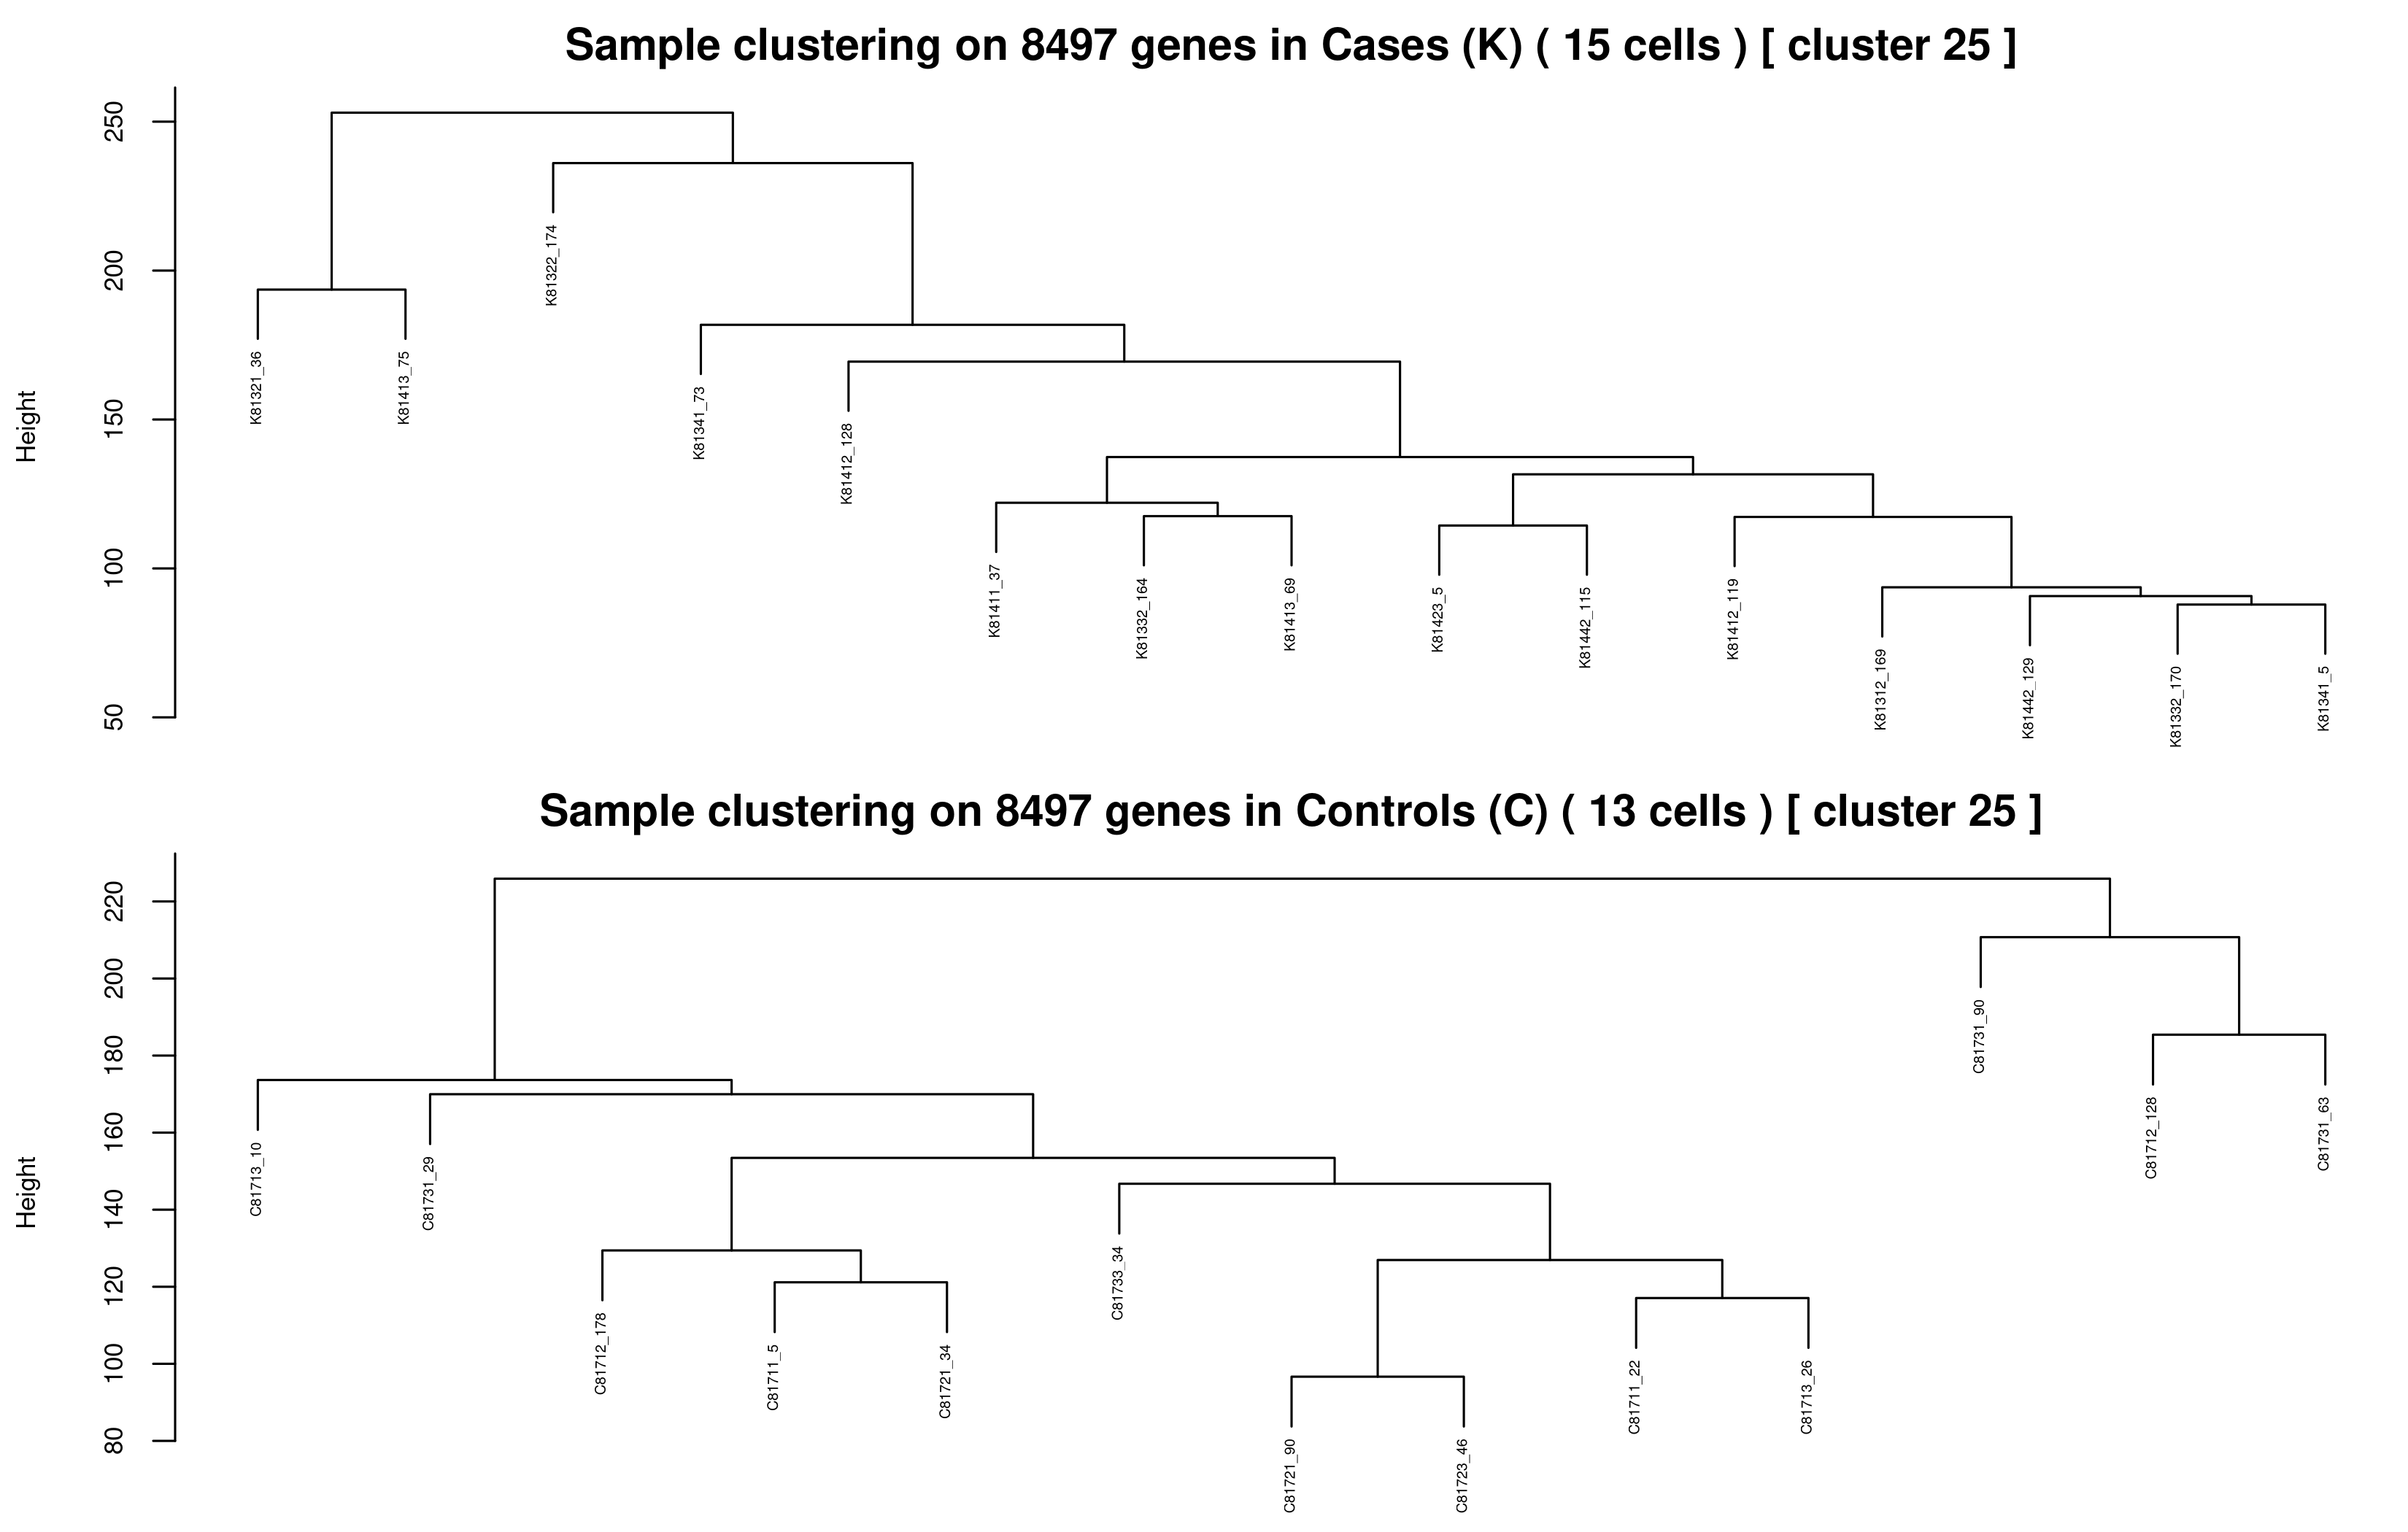

In [160]:
processClust(sc, cln=25)

outliers: none.

### How to proceed

We use the saved checkpoint files from `files/7_wgcna2/clusterN.RDS` to investigate each cluster.